In [1]:
import numpy as np
import cv2
import os
import json
import torch
from torch.utils.data import Dataset

In [2]:
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score, auc
import seaborn as sns
import pandas as pd
from scipy import interp
import seaborn as sns
def mkdir(file_dir):
    if os.path.exists(file_dir):
        shutil.rmtree(file_dir)  # 删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)

def plot_roc_curve_with(fpr, tpr, thresholds, roc_auc, n_bootstrap=1000, save_dir=None):
    plt.figure(figsize=(6, 5))
    plt.title('Normal Classification ROC',  fontsize=14)
    plt.plot(fpr, tpr, color='#C9244C', label='Classification AUC = %0.3f' % roc_auc)
    ci_values = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(tpr), len(tpr))
        tpr_bootstrap = tpr[idx]
        fpr_bootstrap = fpr[idx]
        ci_lower = np.maximum(tpr_bootstrap - fpr_bootstrap, 0)
        ci_values.append(ci_lower)
        
    ci_values = np.percentile(ci_values, [2.5, 97.5], axis=0)
    lower_tprs, upper_tprs = ci_values[0], ci_values[1]

    
    plt.plot([0, 1], [0, 1], color='#C0C0C0', linestyle='--', alpha=0.5)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('Sentivity')
    plt.xlabel('1 - Specifity')
    legend =plt.legend(loc='lower right', frameon=True)
    frame = legend.get_frame()
    frame.set_edgecolor('#5D565A')  # 设置图例边框颜色为指定的颜色
    frame.set_linewidth(1)  # 设置图例边框线宽度为1

    best_threshold_index = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_index]
    best_fpr = fpr[best_threshold_index]
    best_tpr = tpr[best_threshold_index]

    # 计算并显示sensitivity、specificity、precision的值和置信区间
    specificity = 1 - fpr
    sensitivity = tpr
    denominator = sensitivity + fpr
    precision = np.divide(sensitivity, denominator, out=np.zeros_like(sensitivity), where=denominator!=0)

    # 添加黑色边框
    for spine in plt.gca().spines.values():
        spine.set_color('black')

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'Resnet18 Cross ROC Normal.png'), dpi=300)
    plt.show()
    

In [3]:
def calculate_metrics(labels_one_hot_all, pred_scores_all, save_dir=None):
    new_dir = save_dir
    pred_scores_all = torch.cat(pred_scores_all, dim=0).numpy()
    labels_one_hot_all = torch.cat(labels_one_hot_all, dim=0).numpy()
    labels_all = np.argmax(labels_one_hot_all, axis=1)
    
    AUC = roc_auc_score(labels_one_hot_all, pred_scores_all)
    
    pred_scores_all = pred_scores_all[:, 1]
    fpr, tpr, thresholds = roc_curve(labels_all, pred_scores_all)
    if save_dir:
        np.save(os.path.join(new_dir, 'label.npy'), np.array(labels_all))
        np.save(os.path.join(new_dir, 'score.npy'), np.array(pred_scores_all))
    diff = tpr - fpr
    diff[0] = -10
    index = np.argmax(diff)
    thresholds_best = thresholds[index]
    pred_scores_all[pred_scores_all > thresholds_best] = 1
    pred_scores_all[pred_scores_all <= thresholds_best] = 0
    
    ACC = accuracy_score(labels_all, pred_scores_all)
    sensitivity = recall_score(labels_all, pred_scores_all)
    specifity = recall_score(labels_all, pred_scores_all, pos_label=0)
    precision = precision_score(labels_all, pred_scores_all)
    
    global best_AUC
    if AUC > best_AUC:
        best_AUC = AUC
        ROC =  plot_roc_curve_with(fpr, tpr, thresholds, AUC,  save_dir=save_dir) 
    
    return AUC, ACC, sensitivity, specifity, precision    

## three

In [14]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, good_mask, lung_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 
    

In [5]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

def seed_torch(seed=89):

    random.seed(seed) #
    np.random.seed(seed)  #
    torch.manual_seed(seed)   #
    torch.cuda.manual_seed(seed)   #
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed_all(seed)   #
    #set_determinism(seed,use_deterministic_algorithms=True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
    torch.use_deterministic_algorithms(True,warn_only=True)
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    


data_root = r'/home/uii/loraya/DDR_carat/235例分割代码及结果/DDR_data_235/'
abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array
normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 

total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y



writer = SummaryWriter('./path/to/log')

# 10折交叉验证
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.665  train_accuracy: 0.589


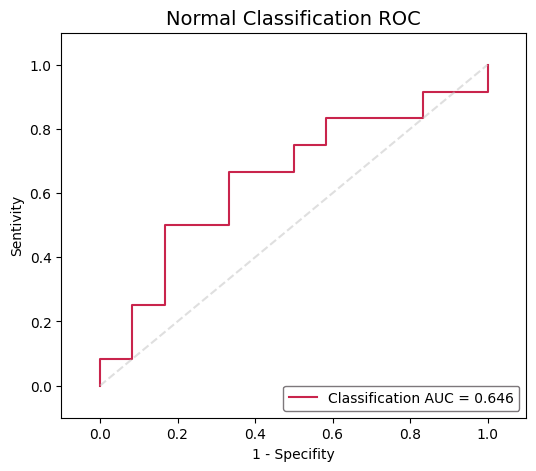

Val_AUC: 0.6458333333333333 Val_ACC: 0.625 Val_SEN: 0.4166666666666667 Val_SPE: 0.8333333333333334 Val_PRE: 0.7142857142857143
[epoch 2] train_loss: 0.620  train_accuracy: 0.671
Val_AUC: 0.6041666666666667 Val_ACC: 0.5833333333333334 Val_SEN: 0.25 Val_SPE: 0.9166666666666666 Val_PRE: 0.75
[epoch 3] train_loss: 0.575  train_accuracy: 0.710
Val_AUC: 0.5208333333333333 Val_ACC: 0.5416666666666666 Val_SEN: 0.75 Val_SPE: 0.3333333333333333 Val_PRE: 0.5294117647058824
[epoch 4] train_loss: 0.566  train_accuracy: 0.720


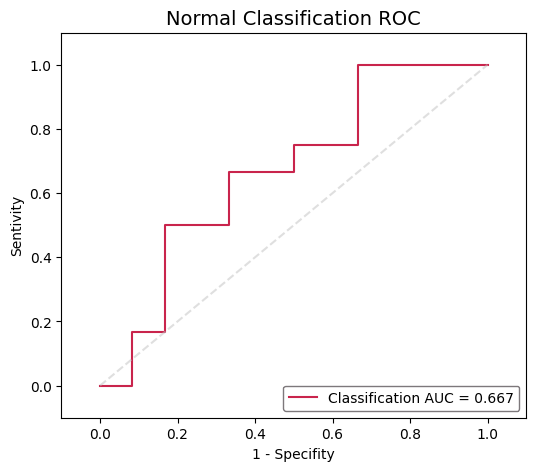

Val_AUC: 0.6666666666666667 Val_ACC: 0.625 Val_SEN: 0.4166666666666667 Val_SPE: 0.8333333333333334 Val_PRE: 0.7142857142857143
[epoch 5] train_loss: 0.539  train_accuracy: 0.792


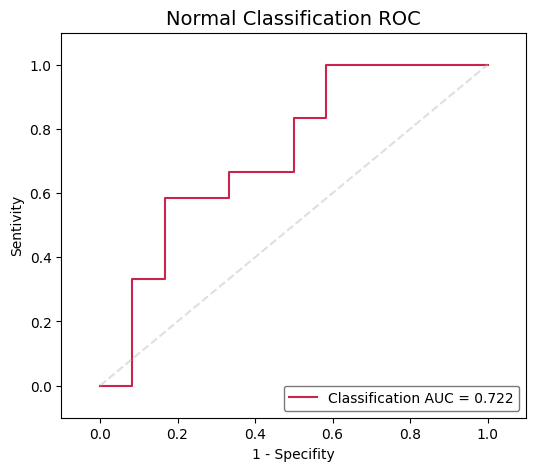

Val_AUC: 0.7222222222222222 Val_ACC: 0.6666666666666666 Val_SEN: 0.5 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 6] train_loss: 0.504  train_accuracy: 0.816
Val_AUC: 0.7152777777777778 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 7] train_loss: 0.530  train_accuracy: 0.768
Val_AUC: 0.7083333333333333 Val_ACC: 0.6666666666666666 Val_SEN: 0.9166666666666666 Val_SPE: 0.4166666666666667 Val_PRE: 0.6111111111111112
[epoch 8] train_loss: 0.498  train_accuracy: 0.787


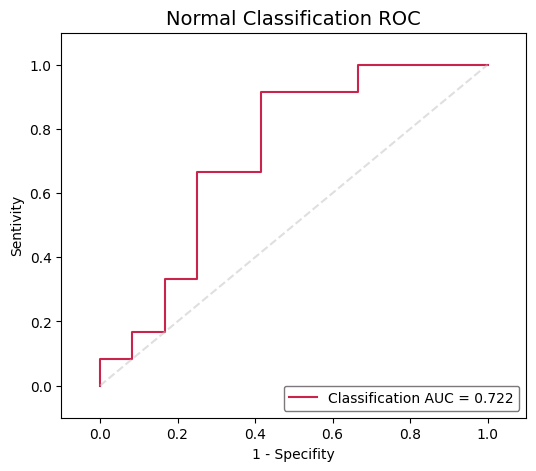

Val_AUC: 0.7222222222222223 Val_ACC: 0.7083333333333334 Val_SEN: 0.8333333333333334 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 9] train_loss: 0.518  train_accuracy: 0.768
Val_AUC: 0.7013888888888888 Val_ACC: 0.6666666666666666 Val_SEN: 0.6666666666666666 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 10] train_loss: 0.516  train_accuracy: 0.783
Val_AUC: 0.6805555555555556 Val_ACC: 0.6666666666666666 Val_SEN: 0.75 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 11] train_loss: 0.486  train_accuracy: 0.812
Val_AUC: 0.6736111111111112 Val_ACC: 0.6666666666666666 Val_SEN: 0.8333333333333334 Val_SPE: 0.5 Val_PRE: 0.625
[epoch 12] train_loss: 0.452  train_accuracy: 0.855
Val_AUC: 0.6111111111111112 Val_ACC: 0.625 Val_SEN: 0.6666666666666666 Val_SPE: 0.5833333333333334 Val_PRE: 0.6153846153846154
[epoch 13] train_loss: 0.480  train_accuracy: 0.831
Val_AUC: 0.6180555555555556 Val_ACC: 0.625 Val_SEN: 0.75 Val_SPE: 0.5 Val_PRE: 0.6
[epoch 14] tr

[epoch 59] train_loss: 0.424  train_accuracy: 0.879
Val_AUC: 0.6736111111111112 Val_ACC: 0.625 Val_SEN: 0.5 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 60] train_loss: 0.413  train_accuracy: 0.903
Val_AUC: 0.6736111111111112 Val_ACC: 0.6666666666666666 Val_SEN: 0.75 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 61] train_loss: 0.418  train_accuracy: 0.889
Val_AUC: 0.6736111111111112 Val_ACC: 0.6666666666666666 Val_SEN: 0.75 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 62] train_loss: 0.421  train_accuracy: 0.903
Val_AUC: 0.6805555555555556 Val_ACC: 0.625 Val_SEN: 0.5 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 63] train_loss: 0.412  train_accuracy: 0.908
Val_AUC: 0.6875 Val_ACC: 0.6666666666666666 Val_SEN: 0.75 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 64] train_loss: 0.425  train_accuracy: 0.874
Val_AUC: 0.6805555555555556 Val_ACC: 0.625 Val_SEN: 0.5 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 65] train_loss: 0.428

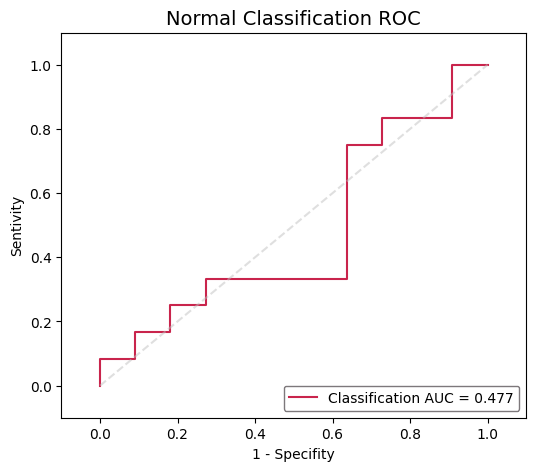

Val_AUC: 0.4772727272727273 Val_ACC: 0.5217391304347826 Val_SEN: 0.6666666666666666 Val_SPE: 0.36363636363636365 Val_PRE: 0.5333333333333333
[epoch 2] train_loss: 0.612  train_accuracy: 0.736


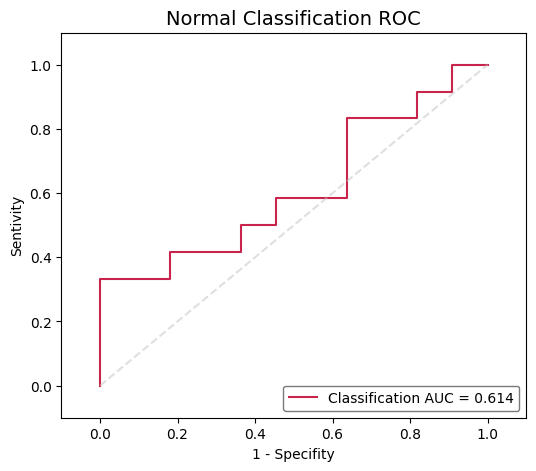

Val_AUC: 0.6136363636363636 Val_ACC: 0.6086956521739131 Val_SEN: 0.25 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 3] train_loss: 0.575  train_accuracy: 0.760


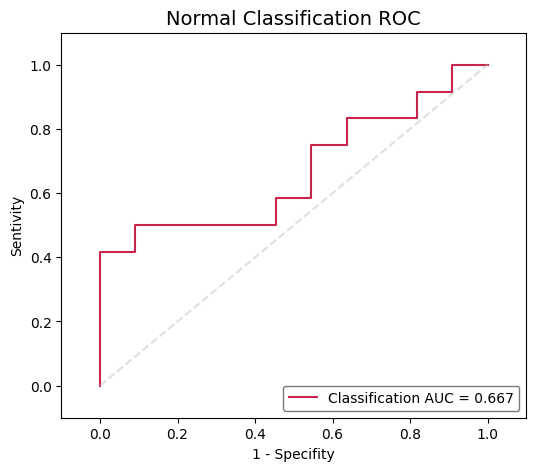

Val_AUC: 0.6666666666666667 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.576  train_accuracy: 0.740
Val_AUC: 0.6590909090909091 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 5] train_loss: 0.555  train_accuracy: 0.740


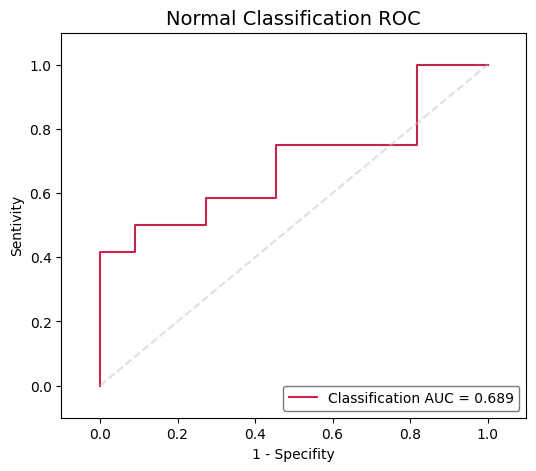

Val_AUC: 0.6893939393939394 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 6] train_loss: 0.547  train_accuracy: 0.760
Val_AUC: 0.6893939393939394 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 7] train_loss: 0.517  train_accuracy: 0.760


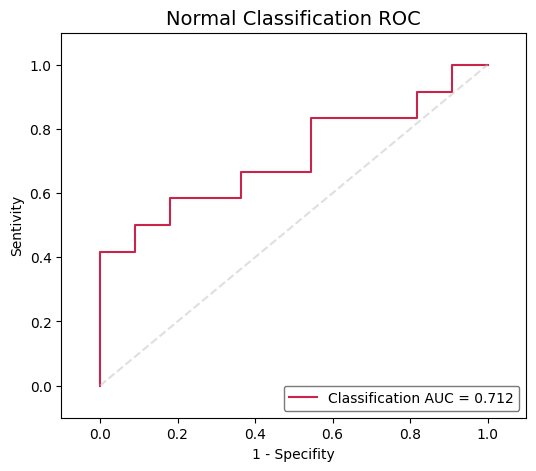

Val_AUC: 0.7121212121212122 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 8] train_loss: 0.532  train_accuracy: 0.788
Val_AUC: 0.7045454545454546 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 9] train_loss: 0.504  train_accuracy: 0.793


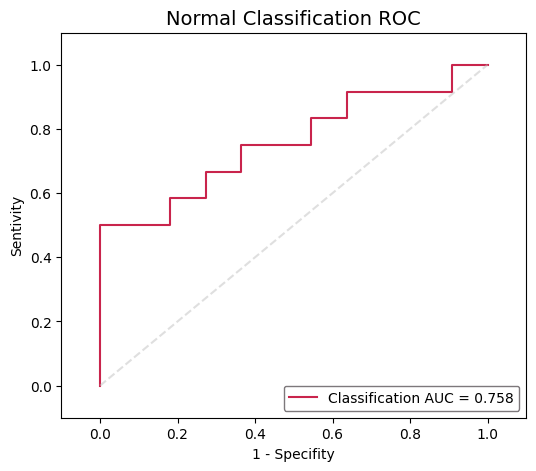

Val_AUC: 0.7575757575757576 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 10] train_loss: 0.474  train_accuracy: 0.837
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.5833333333333334 Val_SPE: 0.8181818181818182 Val_PRE: 0.7777777777777778
[epoch 11] train_loss: 0.523  train_accuracy: 0.740
Val_AUC: 0.7575757575757576 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 12] train_loss: 0.488  train_accuracy: 0.832
Val_AUC: 0.7272727272727273 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 13] train_loss: 0.466  train_accuracy: 0.837


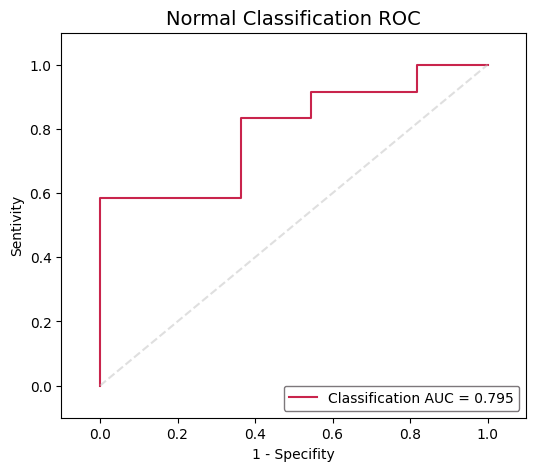

Val_AUC: 0.7954545454545454 Val_ACC: 0.7391304347826086 Val_SEN: 0.5 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 14] train_loss: 0.477  train_accuracy: 0.822


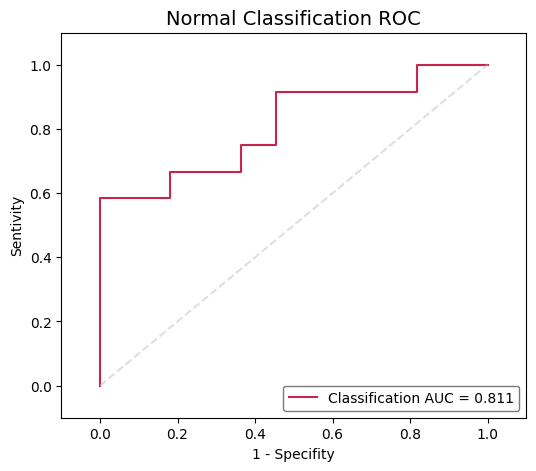

Val_AUC: 0.8106060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.5 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 15] train_loss: 0.430  train_accuracy: 0.885
Val_AUC: 0.7803030303030303 Val_ACC: 0.7391304347826086 Val_SEN: 0.75 Val_SPE: 0.7272727272727273 Val_PRE: 0.75
[epoch 16] train_loss: 0.448  train_accuracy: 0.870
Val_AUC: 0.7727272727272727 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 17] train_loss: 0.463  train_accuracy: 0.822
Val_AUC: 0.7954545454545454 Val_ACC: 0.7391304347826086 Val_SEN: 0.6666666666666666 Val_SPE: 0.8181818181818182 Val_PRE: 0.8
[epoch 18] train_loss: 0.424  train_accuracy: 0.889
Val_AUC: 0.7803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 19] train_loss: 0.460  train_accuracy: 0.841
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 20] train_loss: 0.435  train_accuracy: 0.875
Val_AUC: 0.780303030303030

Val_AUC: 0.7045454545454545 Val_ACC: 0.6521739130434783 Val_SEN: 0.4166666666666667 Val_SPE: 0.9090909090909091 Val_PRE: 0.8333333333333334
[epoch 65] train_loss: 0.421  train_accuracy: 0.875
Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 66] train_loss: 0.433  train_accuracy: 0.880
Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 67] train_loss: 0.419  train_accuracy: 0.889
Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 68] train_loss: 0.417  train_accuracy: 0.899
Val_AUC: 0.7196969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 69] train_loss: 0.442  train_accuracy: 0.865
Val_AUC: 0.7121212121212122 Val_ACC: 0.6521739130434783 Val_SEN: 0.3333333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 70] train_loss: 0.427  train_accuracy: 0.87

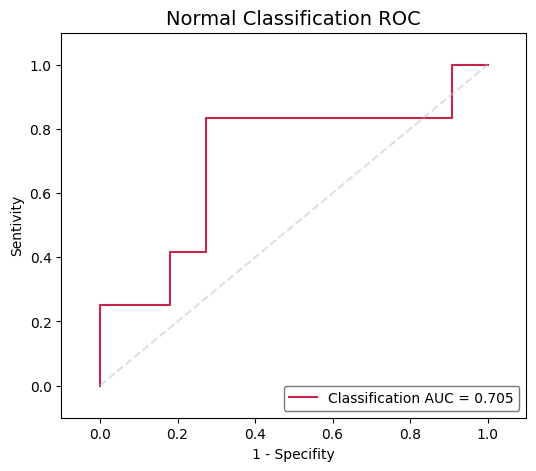

Val_AUC: 0.7045454545454546 Val_ACC: 0.7391304347826086 Val_SEN: 0.75 Val_SPE: 0.7272727272727273 Val_PRE: 0.75
[epoch 2] train_loss: 0.620  train_accuracy: 0.678


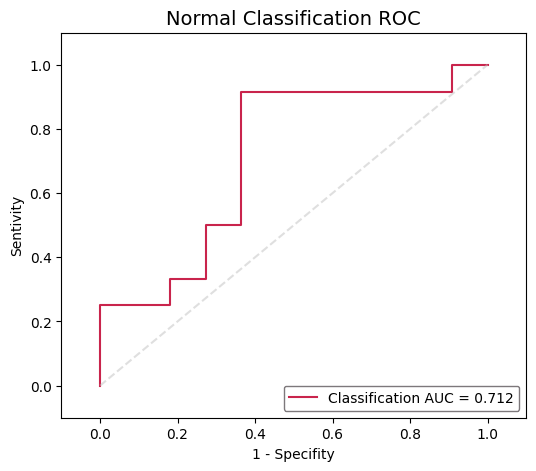

Val_AUC: 0.7121212121212122 Val_ACC: 0.7391304347826086 Val_SEN: 0.8333333333333334 Val_SPE: 0.6363636363636364 Val_PRE: 0.7142857142857143
[epoch 3] train_loss: 0.600  train_accuracy: 0.707
Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.8333333333333334 Val_SPE: 0.5454545454545454 Val_PRE: 0.6666666666666666
[epoch 4] train_loss: 0.577  train_accuracy: 0.731


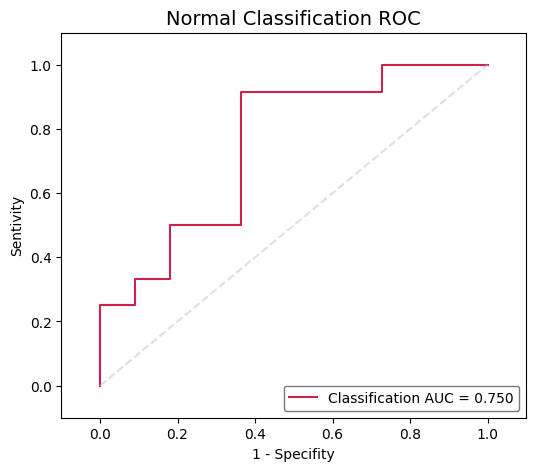

Val_AUC: 0.75 Val_ACC: 0.7391304347826086 Val_SEN: 0.8333333333333334 Val_SPE: 0.6363636363636364 Val_PRE: 0.7142857142857143
[epoch 5] train_loss: 0.517  train_accuracy: 0.774


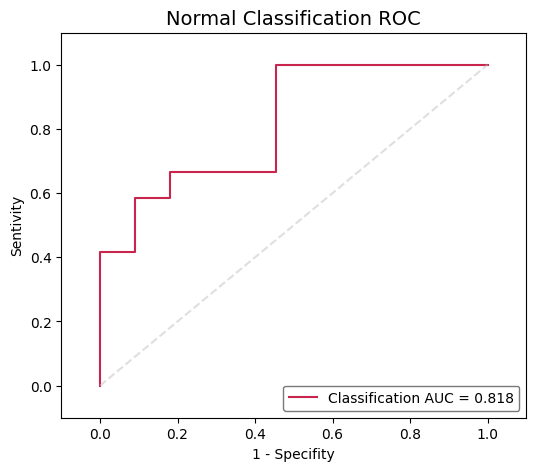

Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.9166666666666666 Val_SPE: 0.5454545454545454 Val_PRE: 0.6875
[epoch 6] train_loss: 0.525  train_accuracy: 0.774


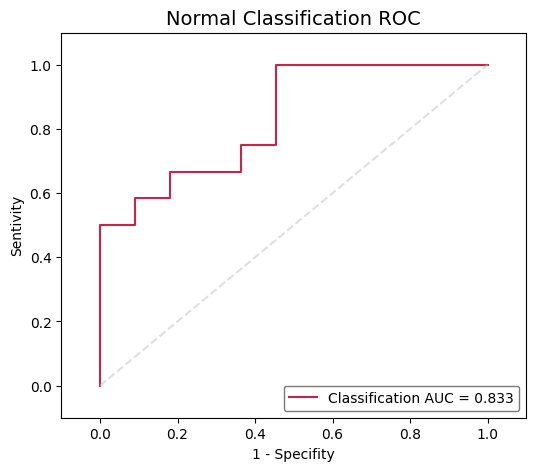

Val_AUC: 0.8333333333333333 Val_ACC: 0.7391304347826086 Val_SEN: 0.9166666666666666 Val_SPE: 0.5454545454545454 Val_PRE: 0.6875
[epoch 7] train_loss: 0.516  train_accuracy: 0.793


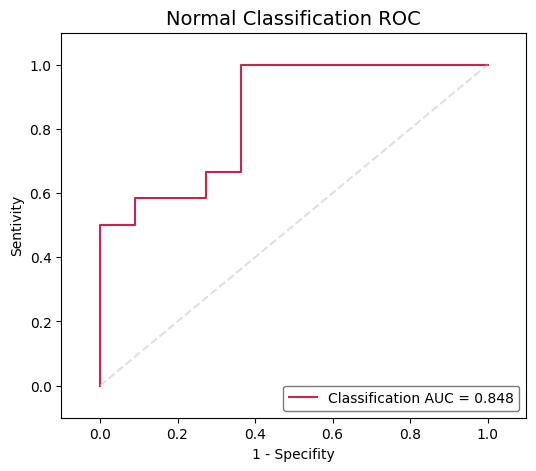

Val_AUC: 0.8484848484848484 Val_ACC: 0.782608695652174 Val_SEN: 0.9166666666666666 Val_SPE: 0.6363636363636364 Val_PRE: 0.7333333333333333
[epoch 8] train_loss: 0.534  train_accuracy: 0.760
Val_AUC: 0.8106060606060606 Val_ACC: 0.782608695652174 Val_SEN: 0.9166666666666666 Val_SPE: 0.6363636363636364 Val_PRE: 0.7333333333333333
[epoch 9] train_loss: 0.509  train_accuracy: 0.793
Val_AUC: 0.7727272727272727 Val_ACC: 0.782608695652174 Val_SEN: 0.8333333333333334 Val_SPE: 0.7272727272727273 Val_PRE: 0.7692307692307693
[epoch 10] train_loss: 0.493  train_accuracy: 0.817
Val_AUC: 0.7045454545454545 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 11] train_loss: 0.534  train_accuracy: 0.769
Val_AUC: 0.6515151515151516 Val_ACC: 0.6956521739130435 Val_SEN: 0.6666666666666666 Val_SPE: 0.7272727272727273 Val_PRE: 0.7272727272727273
[epoch 12] train_loss: 0.489  train_accuracy: 0.803
Val_AUC: 0.6439393939393939 Val_ACC: 0.6956521739130435 Val

[epoch 53] train_loss: 0.396  train_accuracy: 0.928
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 54] train_loss: 0.391  train_accuracy: 0.923
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 55] train_loss: 0.423  train_accuracy: 0.861
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 56] train_loss: 0.409  train_accuracy: 0.899
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 57] train_loss: 0.399  train_accuracy: 0.904
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Val_SPE: 0.6363636363636364 Val_PRE: 0.6923076923076923
[epoch 58] train_loss: 0.412  train_accuracy: 0.894
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.75 Va

[epoch 1] train_loss: 0.669  train_accuracy: 0.548


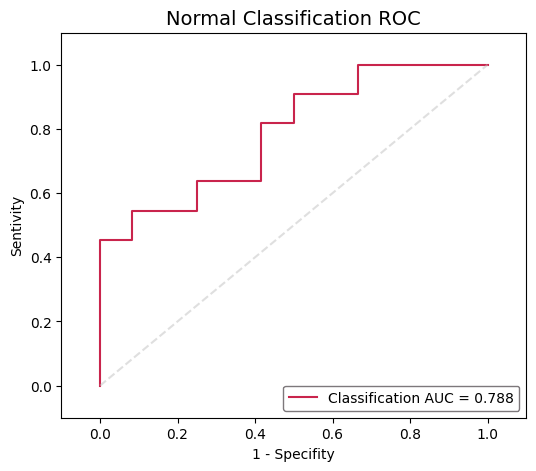

Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 2] train_loss: 0.619  train_accuracy: 0.639


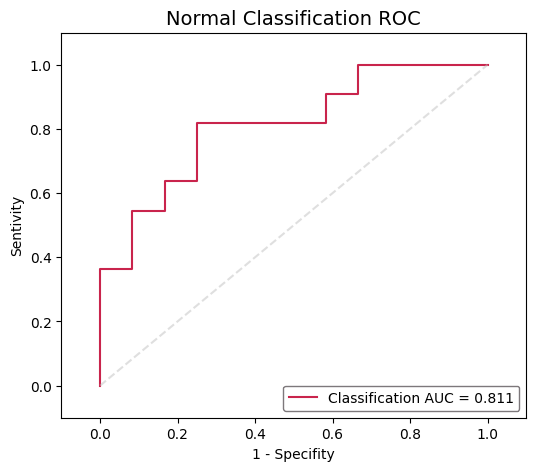

Val_AUC: 0.8106060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 3] train_loss: 0.568  train_accuracy: 0.745


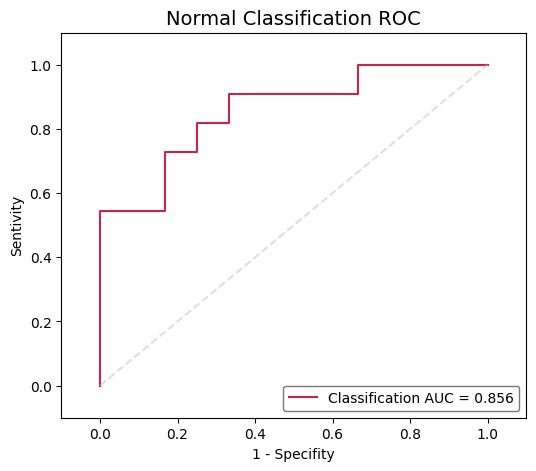

Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 4] train_loss: 0.562  train_accuracy: 0.745


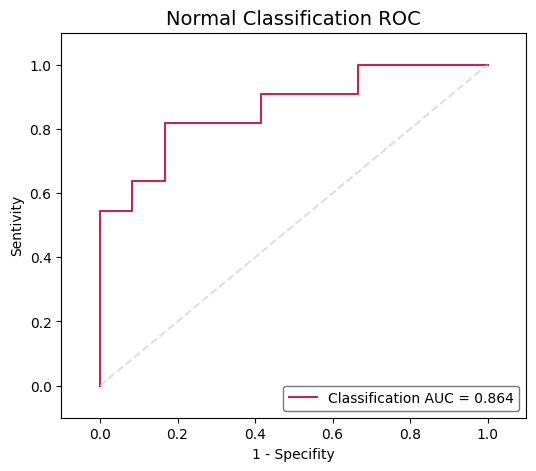

Val_AUC: 0.8636363636363635 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 5] train_loss: 0.540  train_accuracy: 0.774
Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 6] train_loss: 0.547  train_accuracy: 0.745


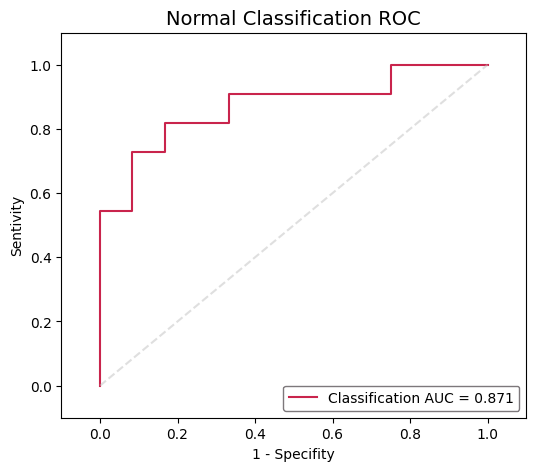

Val_AUC: 0.8712121212121211 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 7] train_loss: 0.515  train_accuracy: 0.803


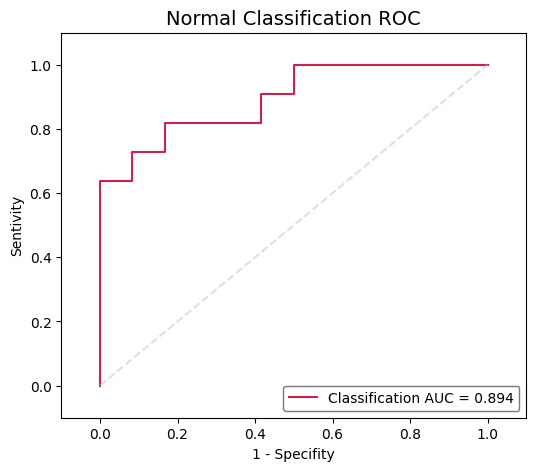

Val_AUC: 0.893939393939394 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 8] train_loss: 0.569  train_accuracy: 0.745


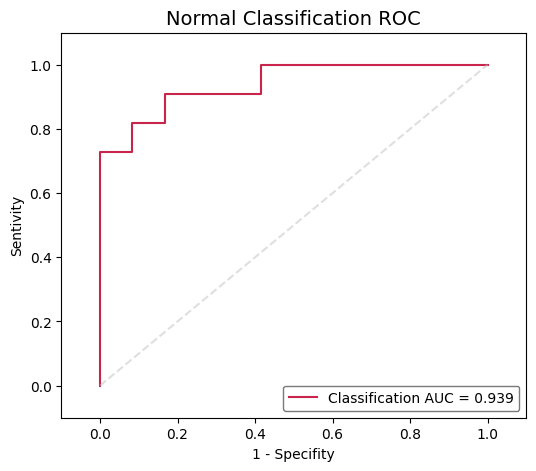

Val_AUC: 0.9393939393939393 Val_ACC: 0.8260869565217391 Val_SEN: 0.8181818181818182 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 9] train_loss: 0.510  train_accuracy: 0.774
Val_AUC: 0.9015151515151515 Val_ACC: 0.8260869565217391 Val_SEN: 0.7272727272727273 Val_SPE: 0.9166666666666666 Val_PRE: 0.8888888888888888
[epoch 10] train_loss: 0.516  train_accuracy: 0.798
Val_AUC: 0.9242424242424243 Val_ACC: 0.8260869565217391 Val_SEN: 0.6363636363636364 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 11] train_loss: 0.505  train_accuracy: 0.812
Val_AUC: 0.9015151515151515 Val_ACC: 0.8260869565217391 Val_SEN: 0.6363636363636364 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 12] train_loss: 0.462  train_accuracy: 0.856
Val_AUC: 0.8863636363636362 Val_ACC: 0.8260869565217391 Val_SEN: 0.6363636363636364 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 13] train_loss: 0.453  train_accuracy: 0.865
Val_AUC: 0.9090909090909092 Val_ACC: 0.8260869565217391 Val_SEN: 0.7272727272727273 Val_SPE: 0.9166666666666666 Val_PRE: 0.88888888

[epoch 56] train_loss: 0.460  train_accuracy: 0.832
Val_AUC: 0.9166666666666667 Val_ACC: 0.8260869565217391 Val_SEN: 0.8181818181818182 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 57] train_loss: 0.436  train_accuracy: 0.861
Val_AUC: 0.9015151515151515 Val_ACC: 0.8260869565217391 Val_SEN: 0.8181818181818182 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 58] train_loss: 0.431  train_accuracy: 0.861
Val_AUC: 0.8939393939393939 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 59] train_loss: 0.430  train_accuracy: 0.865
Val_AUC: 0.9015151515151515 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 60] train_loss: 0.427  train_accuracy: 0.875
Val_AUC: 0.8939393939393939 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 61] train_loss: 0.424  train_accuracy: 0.885
Val_AUC: 0.9015151515151515 Val_ACC: 0.782608695652174 Val_SEN: 0.818181818

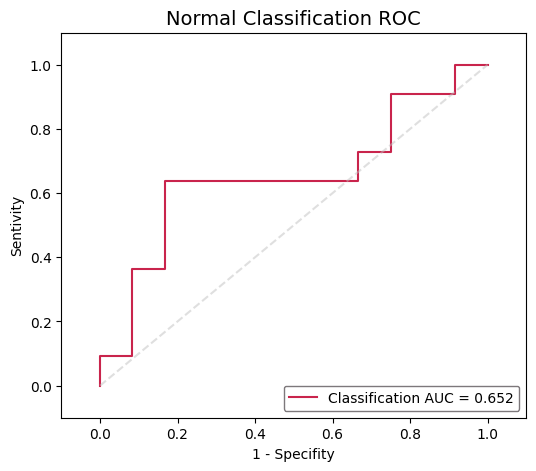

Val_AUC: 0.6515151515151515 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 2] train_loss: 0.610  train_accuracy: 0.702
Val_AUC: 0.6287878787878788 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 3] train_loss: 0.590  train_accuracy: 0.707
Val_AUC: 0.6439393939393939 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 4] train_loss: 0.582  train_accuracy: 0.731
Val_AUC: 0.6287878787878789 Val_ACC: 0.5652173913043478 Val_SEN: 0.8181818181818182 Val_SPE: 0.3333333333333333 Val_PRE: 0.5294117647058824
[epoch 5] train_loss: 0.530  train_accuracy: 0.784


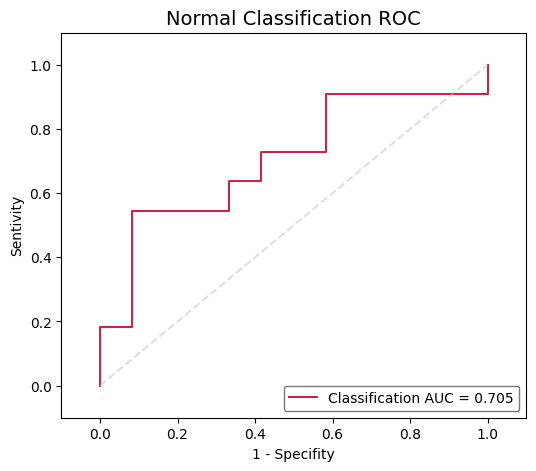

Val_AUC: 0.7045454545454545 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 6] train_loss: 0.542  train_accuracy: 0.755


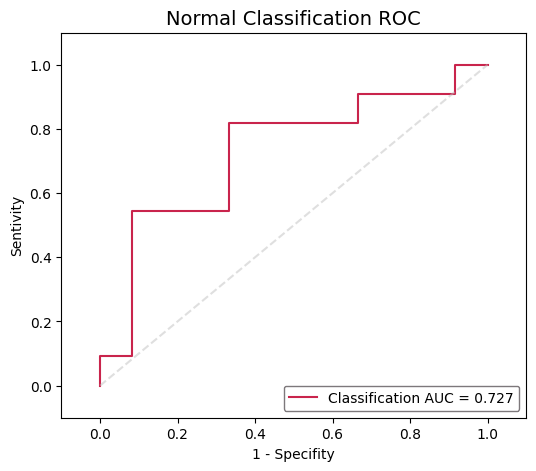

Val_AUC: 0.7272727272727273 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 7] train_loss: 0.541  train_accuracy: 0.755
Val_AUC: 0.6818181818181819 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 8] train_loss: 0.482  train_accuracy: 0.832
Val_AUC: 0.7272727272727273 Val_ACC: 0.6521739130434783 Val_SEN: 0.7272727272727273 Val_SPE: 0.5833333333333334 Val_PRE: 0.6153846153846154
[epoch 9] train_loss: 0.471  train_accuracy: 0.841


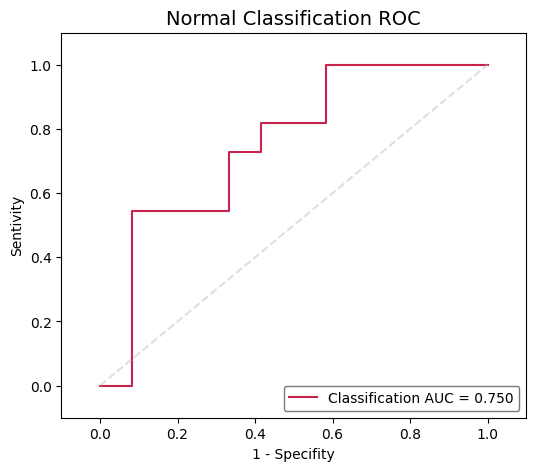

Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 10] train_loss: 0.482  train_accuracy: 0.808
Val_AUC: 0.7348484848484849 Val_ACC: 0.6521739130434783 Val_SEN: 0.7272727272727273 Val_SPE: 0.5833333333333334 Val_PRE: 0.6153846153846154
[epoch 11] train_loss: 0.493  train_accuracy: 0.808


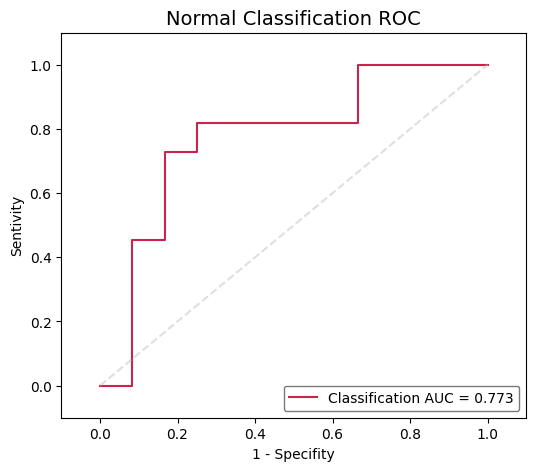

Val_AUC: 0.7727272727272727 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 12] train_loss: 0.477  train_accuracy: 0.841


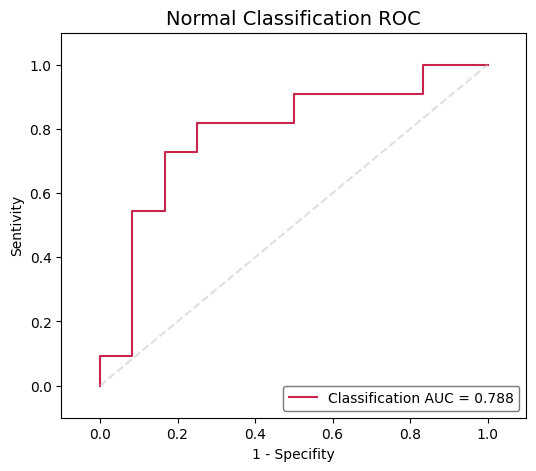

Val_AUC: 0.7878787878787878 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 13] train_loss: 0.482  train_accuracy: 0.827
Val_AUC: 0.7272727272727273 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 14] train_loss: 0.460  train_accuracy: 0.827
Val_AUC: 0.6742424242424242 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 15] train_loss: 0.478  train_accuracy: 0.817
Val_AUC: 0.6666666666666667 Val_ACC: 0.6521739130434783 Val_SEN: 0.5454545454545454 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 16] train_loss: 0.455  train_accuracy: 0.841
Val_AUC: 0.6666666666666667 Val_ACC: 0.6521739130434783 Val_SEN: 0.5454545454545454 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 17] train_loss: 0.448  train_accuracy: 0.861
Val_AUC: 0.6590909090909091 Val_ACC: 0.6521739130434783 Val_SEN: 0.5454545454545454 Val_SPE: 0.7

[epoch 60] train_loss: 0.404  train_accuracy: 0.899
Val_AUC: 0.696969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 61] train_loss: 0.419  train_accuracy: 0.904
Val_AUC: 0.6893939393939394 Val_ACC: 0.6521739130434783 Val_SEN: 0.6363636363636364 Val_SPE: 0.6666666666666666 Val_PRE: 0.6363636363636364
[epoch 62] train_loss: 0.406  train_accuracy: 0.909
Val_AUC: 0.696969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 63] train_loss: 0.423  train_accuracy: 0.885
Val_AUC: 0.7045454545454546 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 64] train_loss: 0.412  train_accuracy: 0.889
Val_AUC: 0.696969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 65] train_loss: 0.414  train_accuracy: 0.885
Val_AUC: 0.696969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0

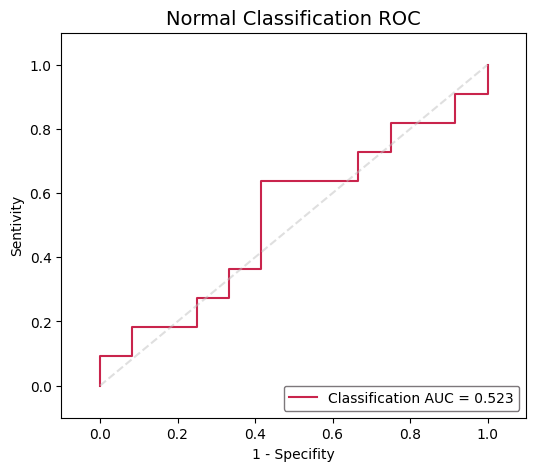

Val_AUC: 0.5227272727272727 Val_ACC: 0.5652173913043478 Val_SEN: 0.5454545454545454 Val_SPE: 0.5833333333333334 Val_PRE: 0.5454545454545454
[epoch 2] train_loss: 0.653  train_accuracy: 0.601


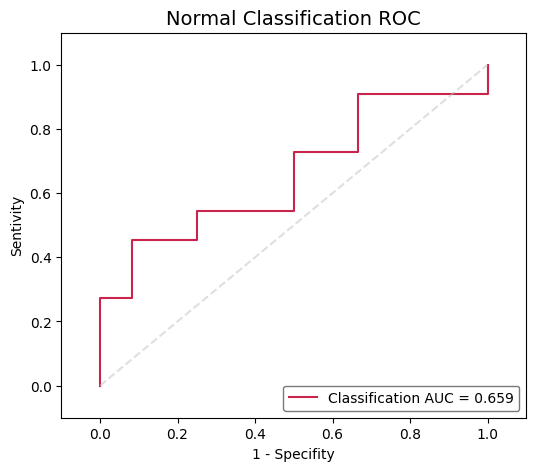

Val_AUC: 0.6590909090909091 Val_ACC: 0.6521739130434783 Val_SEN: 0.36363636363636365 Val_SPE: 0.9166666666666666 Val_PRE: 0.8
[epoch 3] train_loss: 0.598  train_accuracy: 0.726


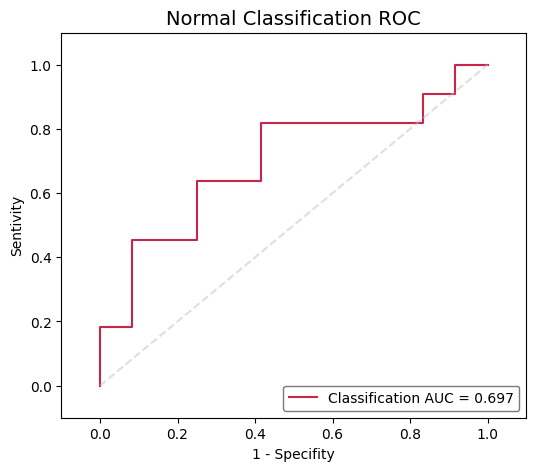

Val_AUC: 0.6969696969696969 Val_ACC: 0.6521739130434783 Val_SEN: 0.7272727272727273 Val_SPE: 0.5833333333333334 Val_PRE: 0.6153846153846154
[epoch 4] train_loss: 0.641  train_accuracy: 0.644


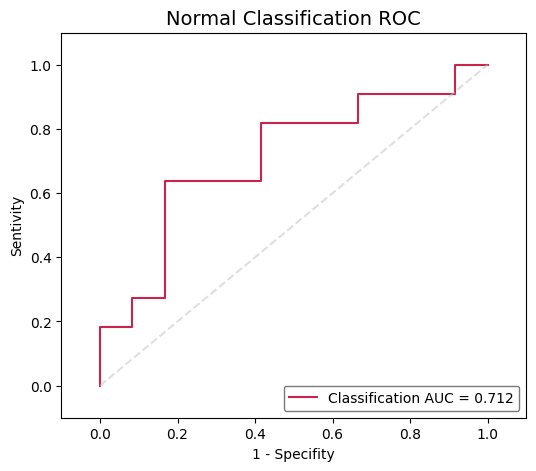

Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 5] train_loss: 0.578  train_accuracy: 0.721


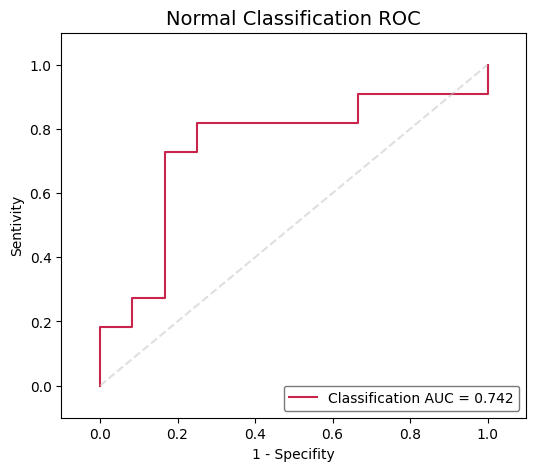

Val_AUC: 0.7424242424242424 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 6] train_loss: 0.545  train_accuracy: 0.750
Val_AUC: 0.7272727272727273 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 7] train_loss: 0.557  train_accuracy: 0.740


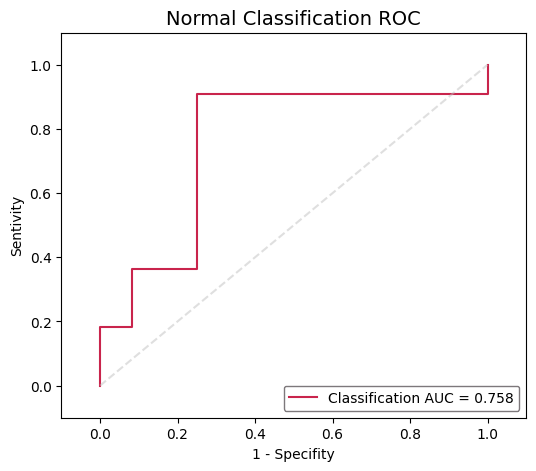

Val_AUC: 0.7575757575757576 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 8] train_loss: 0.501  train_accuracy: 0.803


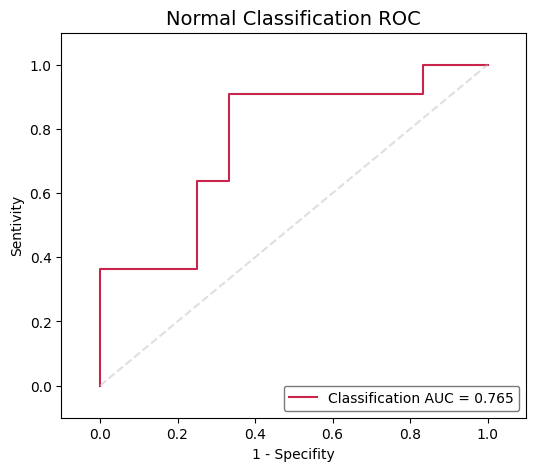

Val_AUC: 0.7651515151515151 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 9] train_loss: 0.527  train_accuracy: 0.784
Val_AUC: 0.7272727272727273 Val_ACC: 0.6521739130434783 Val_SEN: 0.7272727272727273 Val_SPE: 0.5833333333333334 Val_PRE: 0.6153846153846154
[epoch 10] train_loss: 0.529  train_accuracy: 0.769
Val_AUC: 0.7348484848484849 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.502  train_accuracy: 0.798
Val_AUC: 0.6893939393939394 Val_ACC: 0.6521739130434783 Val_SEN: 0.6363636363636364 Val_SPE: 0.6666666666666666 Val_PRE: 0.6363636363636364
[epoch 12] train_loss: 0.506  train_accuracy: 0.808
Val_AUC: 0.7121212121212122 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 13] train_loss: 0.519  train_accuracy: 0.779
Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435

Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 53] train_loss: 0.422  train_accuracy: 0.889
Val_AUC: 0.7575757575757576 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 54] train_loss: 0.419  train_accuracy: 0.889
Val_AUC: 0.7575757575757576 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 55] train_loss: 0.415  train_accuracy: 0.889
Val_AUC: 0.75 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 56] train_loss: 0.427  train_accuracy: 0.889
Val_AUC: 0.75 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 57] train_loss: 0.440  train_accuracy: 0.865
Val_AUC: 0.75 Val_ACC: 0.7391304347826086 Val_SEN: 0.818181818181818

[epoch 97] train_loss: 0.421  train_accuracy: 0.880
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 98] train_loss: 0.430  train_accuracy: 0.889
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 99] train_loss: 0.421  train_accuracy: 0.904
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 100] train_loss: 0.425  train_accuracy: 0.894
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
Finished Training
Start trainning: the 6 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.692  train_accuracy: 0.558


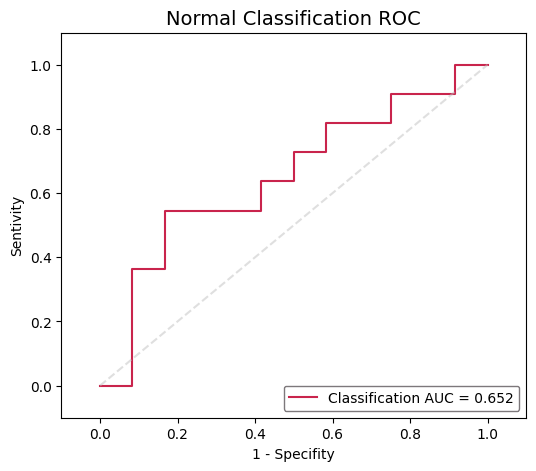

Val_AUC: 0.6515151515151515 Val_ACC: 0.6521739130434783 Val_SEN: 0.45454545454545453 Val_SPE: 0.8333333333333334 Val_PRE: 0.7142857142857143
[epoch 2] train_loss: 0.614  train_accuracy: 0.654
Val_AUC: 0.6515151515151515 Val_ACC: 0.6521739130434783 Val_SEN: 0.36363636363636365 Val_SPE: 0.9166666666666666 Val_PRE: 0.8
[epoch 3] train_loss: 0.591  train_accuracy: 0.688


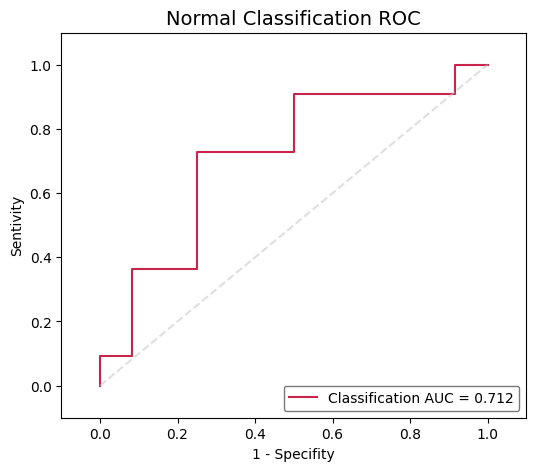

Val_AUC: 0.7121212121212122 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 4] train_loss: 0.567  train_accuracy: 0.750


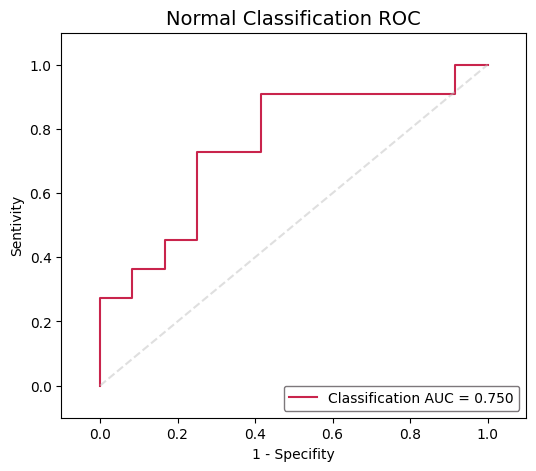

Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 5] train_loss: 0.571  train_accuracy: 0.707


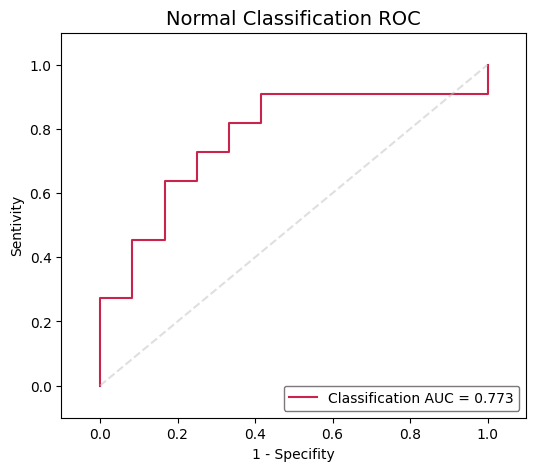

Val_AUC: 0.7727272727272727 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 6] train_loss: 0.551  train_accuracy: 0.721


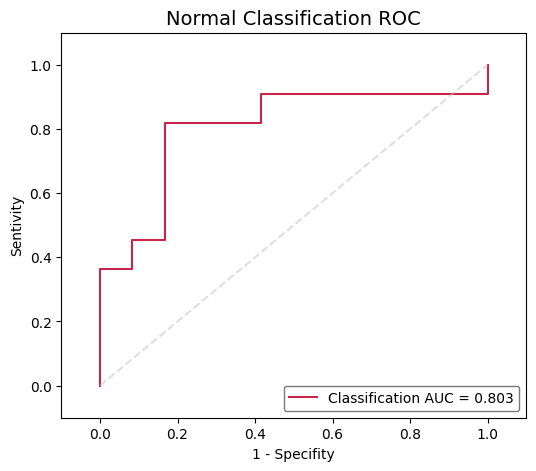

Val_AUC: 0.803030303030303 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 7] train_loss: 0.540  train_accuracy: 0.764
Val_AUC: 0.803030303030303 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 8] train_loss: 0.520  train_accuracy: 0.803
Val_AUC: 0.7954545454545454 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 9] train_loss: 0.502  train_accuracy: 0.808


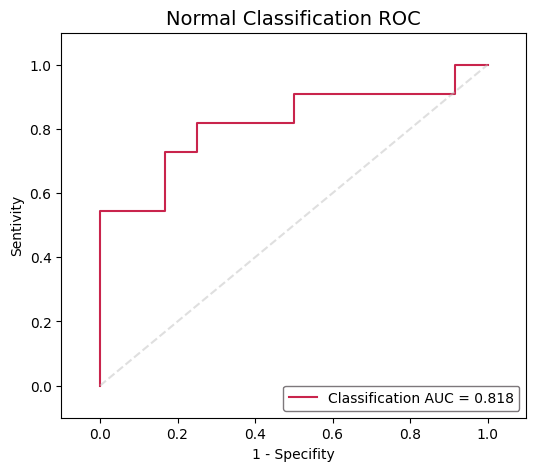

Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 10] train_loss: 0.473  train_accuracy: 0.817
Val_AUC: 0.7803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.503  train_accuracy: 0.803
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 12] train_loss: 0.469  train_accuracy: 0.832


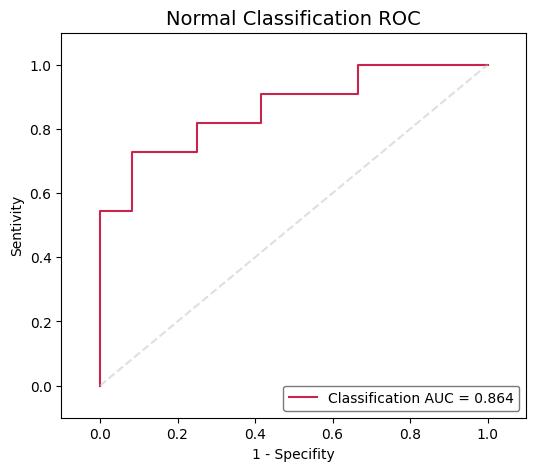

Val_AUC: 0.8636363636363635 Val_ACC: 0.782608695652174 Val_SEN: 0.6363636363636364 Val_SPE: 0.9166666666666666 Val_PRE: 0.875
[epoch 13] train_loss: 0.469  train_accuracy: 0.837
Val_AUC: 0.8484848484848484 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 14] train_loss: 0.455  train_accuracy: 0.827
Val_AUC: 0.8484848484848485 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 15] train_loss: 0.458  train_accuracy: 0.851
Val_AUC: 0.8333333333333333 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 16] train_loss: 0.452  train_accuracy: 0.870
Val_AUC: 0.8257575757575758 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 17] train_loss: 0.442  train_accuracy: 0.841
Val_AUC: 0.8106060606060607 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7

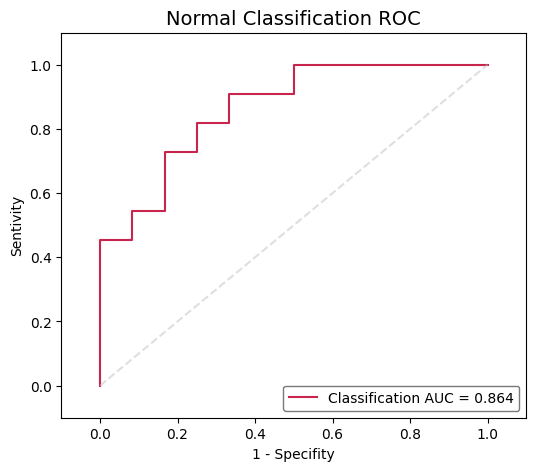

Val_AUC: 0.8636363636363638 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 30] train_loss: 0.405  train_accuracy: 0.899
Val_AUC: 0.8484848484848485 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 31] train_loss: 0.413  train_accuracy: 0.885
Val_AUC: 0.8409090909090909 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 32] train_loss: 0.414  train_accuracy: 0.899
Val_AUC: 0.8560606060606061 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 33] train_loss: 0.475  train_accuracy: 0.841
Val_AUC: 0.8333333333333333 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 34] train_loss: 0.423  train_accuracy: 0.865
Val_AUC: 0.8484848484848485 Val_ACC: 0.7

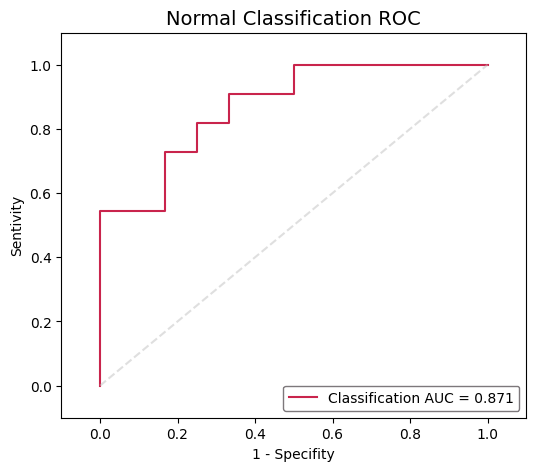

Val_AUC: 0.8712121212121212 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 37] train_loss: 0.414  train_accuracy: 0.899
Val_AUC: 0.8636363636363635 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 38] train_loss: 0.425  train_accuracy: 0.894
Val_AUC: 0.8636363636363635 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 39] train_loss: 0.420  train_accuracy: 0.870
Val_AUC: 0.8636363636363638 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 40] train_loss: 0.424  train_accuracy: 0.880
Val_AUC: 0.8333333333333333 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 41] train_loss: 0.397  train_accuracy: 0.904
Val_AUC: 0.8560606060606061 Val_ACC: 0.7

[epoch 79] train_loss: 0.402  train_accuracy: 0.894
Val_AUC: 0.8636363636363635 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 80] train_loss: 0.423  train_accuracy: 0.885
Val_AUC: 0.8636363636363635 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 81] train_loss: 0.410  train_accuracy: 0.913
Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 82] train_loss: 0.438  train_accuracy: 0.865
Val_AUC: 0.8636363636363638 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 83] train_loss: 0.411  train_accuracy: 0.909
Val_AUC: 0.8560606060606061 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 84] train_loss: 0.426  train_accur

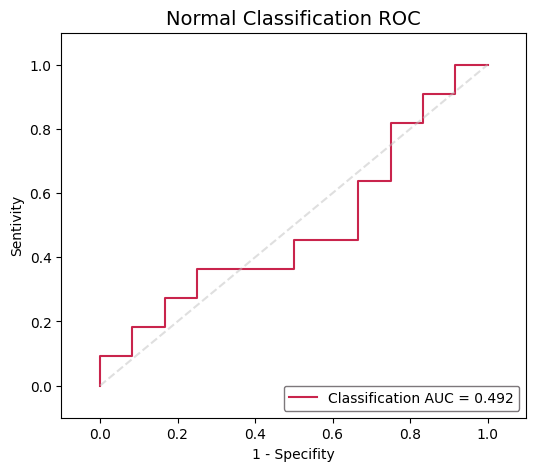

Val_AUC: 0.49242424242424243 Val_ACC: 0.5217391304347826 Val_SEN: 0.2727272727272727 Val_SPE: 0.75 Val_PRE: 0.5
[epoch 2] train_loss: 0.655  train_accuracy: 0.596


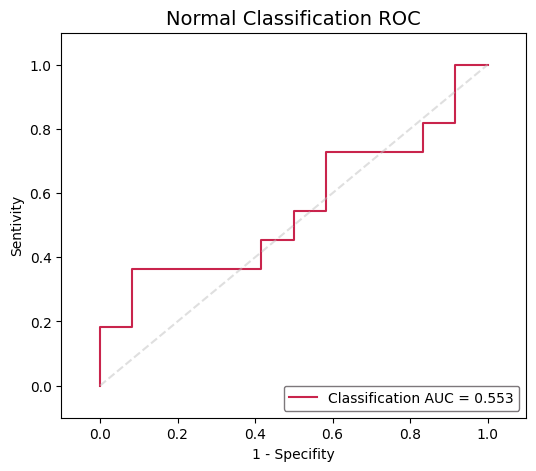

Val_AUC: 0.553030303030303 Val_ACC: 0.6086956521739131 Val_SEN: 0.2727272727272727 Val_SPE: 0.9166666666666666 Val_PRE: 0.75
[epoch 3] train_loss: 0.614  train_accuracy: 0.635


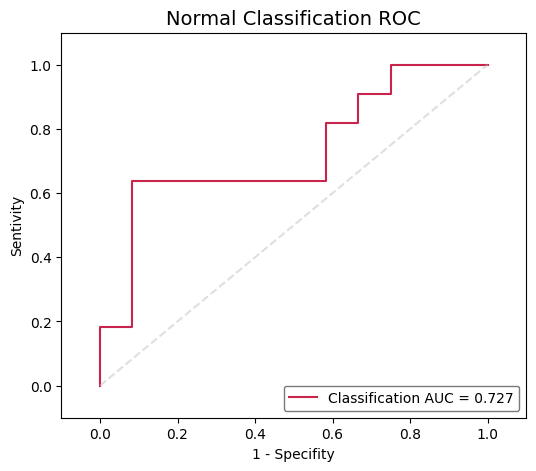

Val_AUC: 0.7272727272727273 Val_ACC: 0.7391304347826086 Val_SEN: 0.5454545454545454 Val_SPE: 0.9166666666666666 Val_PRE: 0.8571428571428571
[epoch 4] train_loss: 0.573  train_accuracy: 0.726
Val_AUC: 0.6590909090909092 Val_ACC: 0.6521739130434783 Val_SEN: 0.5454545454545454 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 5] train_loss: 0.556  train_accuracy: 0.750
Val_AUC: 0.6818181818181819 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 6] train_loss: 0.573  train_accuracy: 0.712


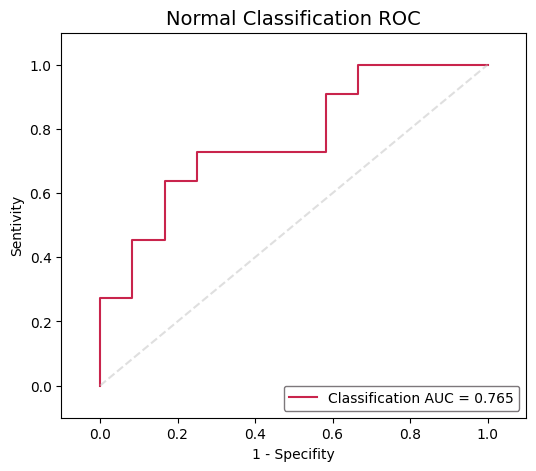

Val_AUC: 0.7651515151515151 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 7] train_loss: 0.523  train_accuracy: 0.779
Val_AUC: 0.696969696969697 Val_ACC: 0.6521739130434783 Val_SEN: 0.9090909090909091 Val_SPE: 0.4166666666666667 Val_PRE: 0.5882352941176471
[epoch 8] train_loss: 0.563  train_accuracy: 0.750
Val_AUC: 0.7045454545454546 Val_ACC: 0.6521739130434783 Val_SEN: 0.45454545454545453 Val_SPE: 0.8333333333333334 Val_PRE: 0.7142857142857143
[epoch 9] train_loss: 0.550  train_accuracy: 0.716
Val_AUC: 0.7348484848484849 Val_ACC: 0.6521739130434783 Val_SEN: 0.9090909090909091 Val_SPE: 0.4166666666666667 Val_PRE: 0.5882352941176471
[epoch 10] train_loss: 0.507  train_accuracy: 0.779
Val_AUC: 0.6590909090909092 Val_ACC: 0.6521739130434783 Val_SEN: 0.36363636363636365 Val_SPE: 0.9166666666666666 Val_PRE: 0.8
[epoch 11] train_loss: 0.502  train_accuracy: 0.793
Val_AUC: 0.7045454545454546 Val_ACC: 0.6521739130434783 Val_SEN: 0.5454545454545454 Va

[epoch 51] train_loss: 0.424  train_accuracy: 0.885
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 52] train_loss: 0.414  train_accuracy: 0.880
Val_AUC: 0.7348484848484849 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 53] train_loss: 0.423  train_accuracy: 0.894
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 54] train_loss: 0.429  train_accuracy: 0.875
Val_AUC: 0.7424242424242424 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 55] train_loss: 0.405  train_accuracy: 0.899
Val_AUC: 0.7272727272727273 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 56] train_loss: 0.426  train_accuracy: 0.875
Val_AUC: 0.

[epoch 96] train_loss: 0.443  train_accuracy: 0.856
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 97] train_loss: 0.426  train_accuracy: 0.885
Val_AUC: 0.7575757575757576 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 98] train_loss: 0.432  train_accuracy: 0.885
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 99] train_loss: 0.431  train_accuracy: 0.894
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
[epoch 100] train_loss: 0.428  train_accuracy: 0.899
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.45454545454545453 Val_SPE: 0.9166666666666666 Val_PRE: 0.8333333333333334
Finished Training
Start trainning: the 8 fold
Using 8 dataloader workers every process
[ep

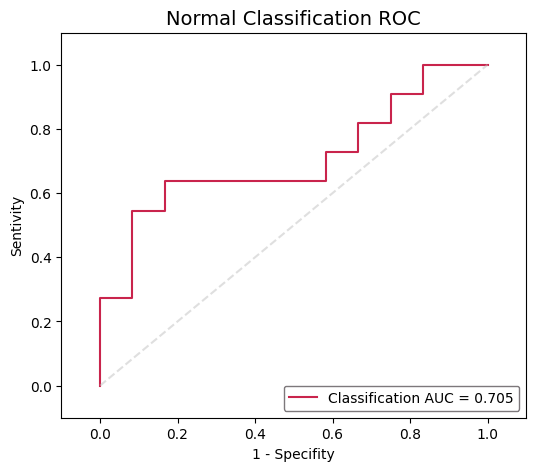

Val_AUC: 0.7045454545454546 Val_ACC: 0.6956521739130435 Val_SEN: 0.5454545454545454 Val_SPE: 0.8333333333333334 Val_PRE: 0.75
[epoch 2] train_loss: 0.649  train_accuracy: 0.611
Val_AUC: 0.6439393939393939 Val_ACC: 0.6086956521739131 Val_SEN: 0.8181818181818182 Val_SPE: 0.4166666666666667 Val_PRE: 0.5625
[epoch 3] train_loss: 0.609  train_accuracy: 0.663
Val_AUC: 0.7045454545454546 Val_ACC: 0.6521739130434783 Val_SEN: 0.8181818181818182 Val_SPE: 0.5 Val_PRE: 0.6
[epoch 4] train_loss: 0.550  train_accuracy: 0.745
Val_AUC: 0.6666666666666667 Val_ACC: 0.6521739130434783 Val_SEN: 0.45454545454545453 Val_SPE: 0.8333333333333334 Val_PRE: 0.7142857142857143
[epoch 5] train_loss: 0.568  train_accuracy: 0.726
Val_AUC: 0.6742424242424243 Val_ACC: 0.6521739130434783 Val_SEN: 0.6363636363636364 Val_SPE: 0.6666666666666666 Val_PRE: 0.6363636363636364
[epoch 6] train_loss: 0.521  train_accuracy: 0.793


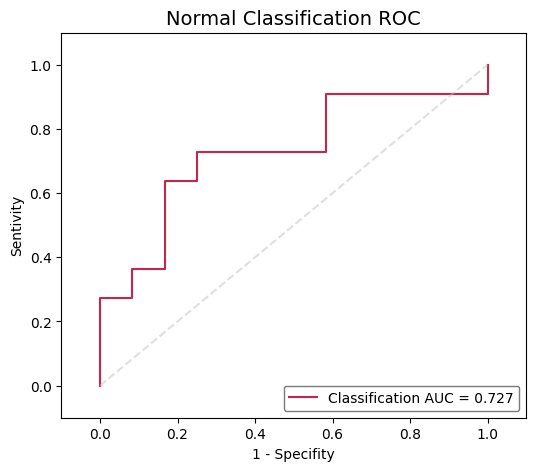

Val_AUC: 0.7272727272727273 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 7] train_loss: 0.543  train_accuracy: 0.793


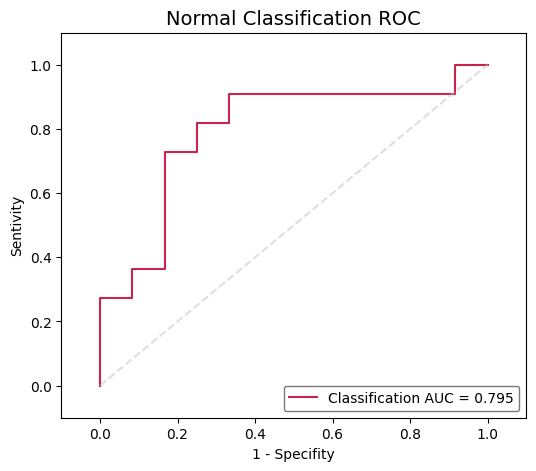

Val_AUC: 0.7954545454545454 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 8] train_loss: 0.508  train_accuracy: 0.788
Val_AUC: 0.7878787878787878 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 9] train_loss: 0.554  train_accuracy: 0.712
Val_AUC: 0.7878787878787878 Val_ACC: 0.7391304347826086 Val_SEN: 0.7272727272727273 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 10] train_loss: 0.491  train_accuracy: 0.793
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.495  train_accuracy: 0.812
Val_AUC: 0.75 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 12] train_loss: 0.452  train_accuracy: 0.832
Val_AUC: 0.7575757575757576 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 V

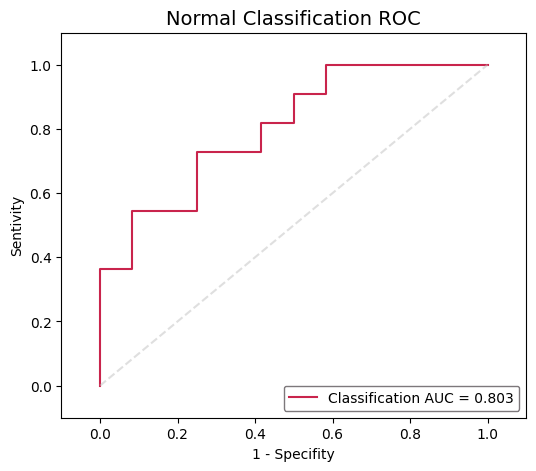

Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 16] train_loss: 0.441  train_accuracy: 0.870
Val_AUC: 0.7954545454545454 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 17] train_loss: 0.461  train_accuracy: 0.870
Val_AUC: 0.7954545454545454 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 18] train_loss: 0.451  train_accuracy: 0.875
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 19] train_loss: 0.447  train_accuracy: 0.851
Val_AUC: 0.7954545454545454 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 20] train_loss: 0.470  train_accuracy: 0.837


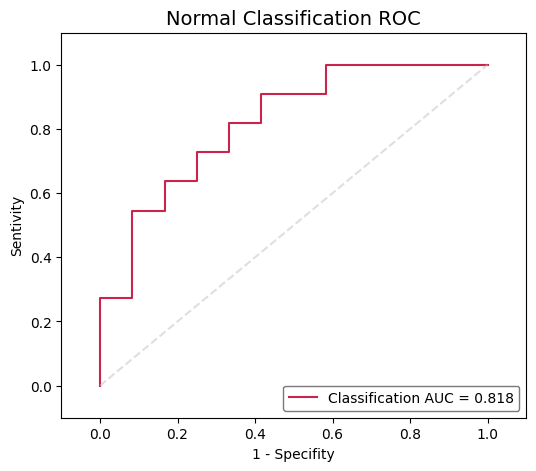

Val_AUC: 0.8181818181818181 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 21] train_loss: 0.429  train_accuracy: 0.885
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 22] train_loss: 0.441  train_accuracy: 0.870
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 23] train_loss: 0.421  train_accuracy: 0.865
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.7272727272727273 Val_SPE: 0.6666666666666666 Val_PRE: 0.6666666666666666
[epoch 24] train_loss: 0.427  train_accuracy: 0.885
Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 25] train_loss: 0.465  train_accuracy: 0.837
Val_AUC: 0.8106060606060606 Val_ACC: 0.69

[epoch 63] train_loss: 0.418  train_accuracy: 0.880
Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 64] train_loss: 0.427  train_accuracy: 0.875
Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 65] train_loss: 0.428  train_accuracy: 0.889
Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 66] train_loss: 0.411  train_accuracy: 0.904
Val_AUC: 0.7878787878787878 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 67] train_loss: 0.441  train_accuracy: 0.865
Val_AUC: 0.803030303030303 Val_ACC: 0.6956521739130435 Val_SEN: 0.8181818181818182 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 68] train_loss: 0.423  train_accuracy

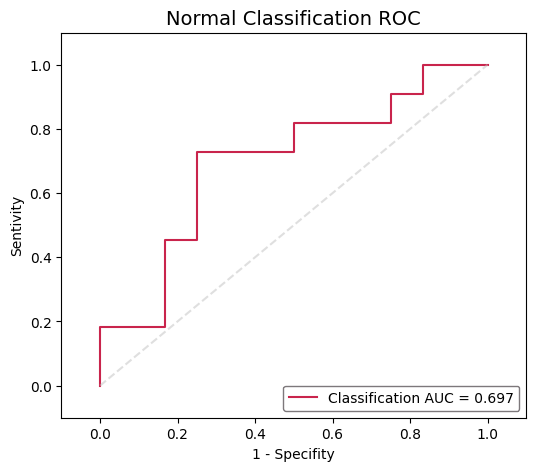

Val_AUC: 0.696969696969697 Val_ACC: 0.6956521739130435 Val_SEN: 0.6363636363636364 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 2] train_loss: 0.617  train_accuracy: 0.673


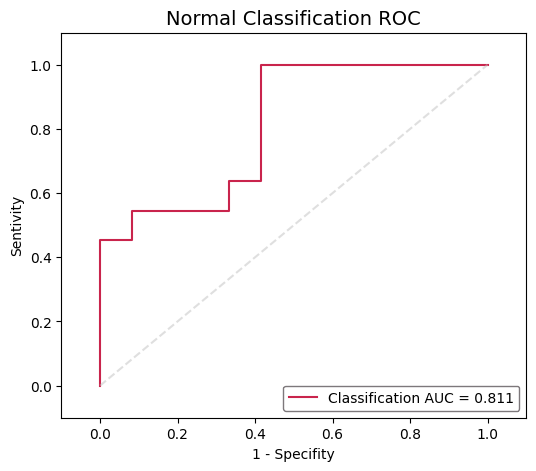

Val_AUC: 0.8106060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.9090909090909091 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 3] train_loss: 0.596  train_accuracy: 0.697
Val_AUC: 0.803030303030303 Val_ACC: 0.7391304347826086 Val_SEN: 0.9090909090909091 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 4] train_loss: 0.571  train_accuracy: 0.736


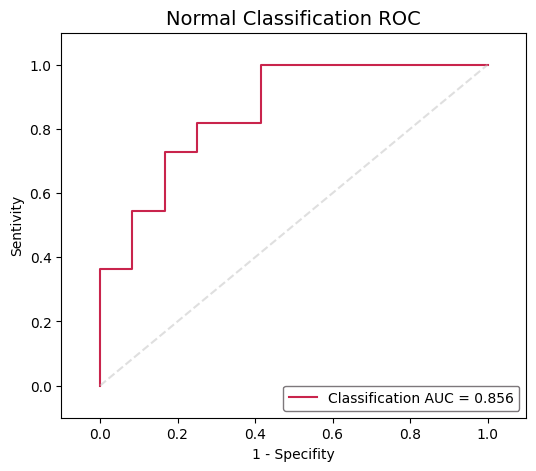

Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.9090909090909091 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 5] train_loss: 0.583  train_accuracy: 0.721


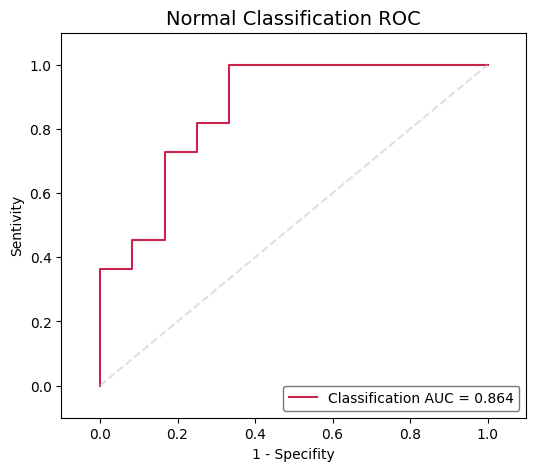

Val_AUC: 0.8636363636363638 Val_ACC: 0.782608695652174 Val_SEN: 0.9090909090909091 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 6] train_loss: 0.561  train_accuracy: 0.731
Val_AUC: 0.8560606060606061 Val_ACC: 0.8260869565217391 Val_SEN: 0.9090909090909091 Val_SPE: 0.75 Val_PRE: 0.7692307692307693
[epoch 7] train_loss: 0.550  train_accuracy: 0.745
Val_AUC: 0.8409090909090909 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 8] train_loss: 0.529  train_accuracy: 0.774
Val_AUC: 0.8484848484848485 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 9] train_loss: 0.499  train_accuracy: 0.803
Val_AUC: 0.8484848484848484 Val_ACC: 0.8260869565217391 Val_SEN: 0.8181818181818182 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 10] train_loss: 0.519  train_accuracy: 0.808
Val_AUC: 0.8409090909090908 Val_ACC: 0.7391304347826086 Val_SEN: 0.9090909090909091 Val_

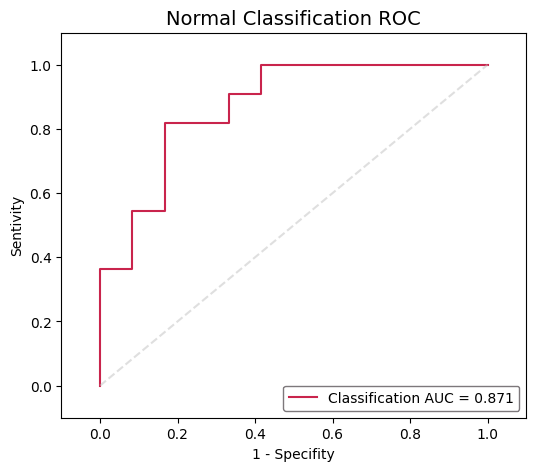

Val_AUC: 0.8712121212121211 Val_ACC: 0.782608695652174 Val_SEN: 0.7272727272727273 Val_SPE: 0.8333333333333334 Val_PRE: 0.8
[epoch 12] train_loss: 0.480  train_accuracy: 0.846
Val_AUC: 0.8257575757575758 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 13] train_loss: 0.444  train_accuracy: 0.875
Val_AUC: 0.8484848484848484 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 14] train_loss: 0.457  train_accuracy: 0.837


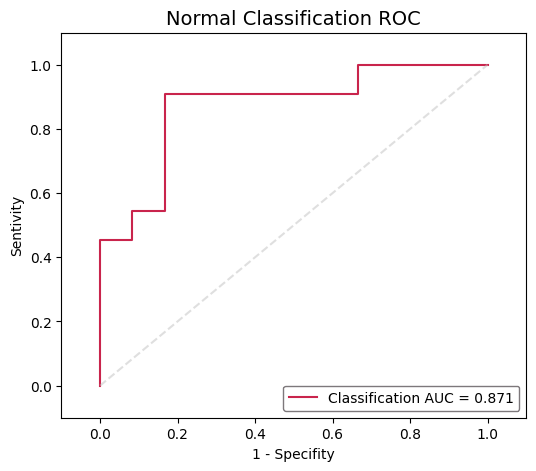

Val_AUC: 0.8712121212121212 Val_ACC: 0.8260869565217391 Val_SEN: 0.8181818181818182 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 15] train_loss: 0.449  train_accuracy: 0.846


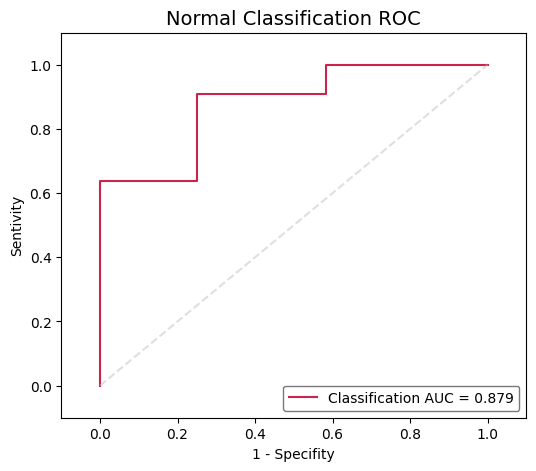

Val_AUC: 0.8787878787878788 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 16] train_loss: 0.461  train_accuracy: 0.841
Val_AUC: 0.8787878787878788 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 17] train_loss: 0.472  train_accuracy: 0.827
Val_AUC: 0.8712121212121212 Val_ACC: 0.782608695652174 Val_SEN: 0.8181818181818182 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 18] train_loss: 0.469  train_accuracy: 0.837
Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 19] train_loss: 0.435  train_accuracy: 0.870
Val_AUC: 0.856060606060606 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 20] train_loss: 0.480  train_accuracy: 0.817
Val_AUC: 0.8257575757575757 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.692307

[epoch 59] train_loss: 0.414  train_accuracy: 0.889
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 60] train_loss: 0.427  train_accuracy: 0.875
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 61] train_loss: 0.418  train_accuracy: 0.894
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 62] train_loss: 0.398  train_accuracy: 0.923
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 63] train_loss: 0.426  train_accuracy: 0.865
Val_AUC: 0.8181818181818181 Val_ACC: 0.7391304347826086 Val_SEN: 0.8181818181818182 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 64] train_loss: 0.432  train_accu

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

seed = 89
seed_torch(seed)
g = torch.Generator()
g.manual_seed(seed)

train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 100

fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/235例分割代码及结果/res_18_three1/Cross_valiation_fold/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    #输入
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset =DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8, pin_memory=True,worker_init_fn=seed_worker,generator = g)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    best_AUC = 0.0
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_sen,CM_spe,CM_pre = calculate_metrics(val_pre_labels, predict_scores)
        print('Val_AUC: {} Val_ACC: {} Val_SEN: {} Val_SPE: {} Val_PRE: {}'.format(CM_auc,CM_acc,CM_sen,CM_spe,CM_pre))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_,_,_ = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/235例分割代码及结果/res_18_three1/Cross_valiation_fold/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} Sen: {CM_sen} Spe: {CM_spe} Pre: {CM_pre}\n')
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

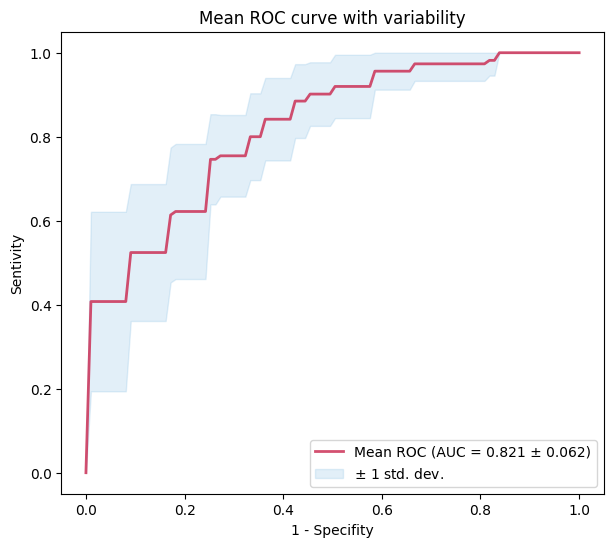

ROC curves saved successfully.


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)



fig, ax = plt.subplots(figsize=(7, 6))


for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/res_18_three1/Cross_valiation_fold/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/res_18_three1/Cross_valiation_fold/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#6EB1DE",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_carat/235例分割代码及结果/res_18_three1/Cross_valiation_fold/inter_roc_fold1.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

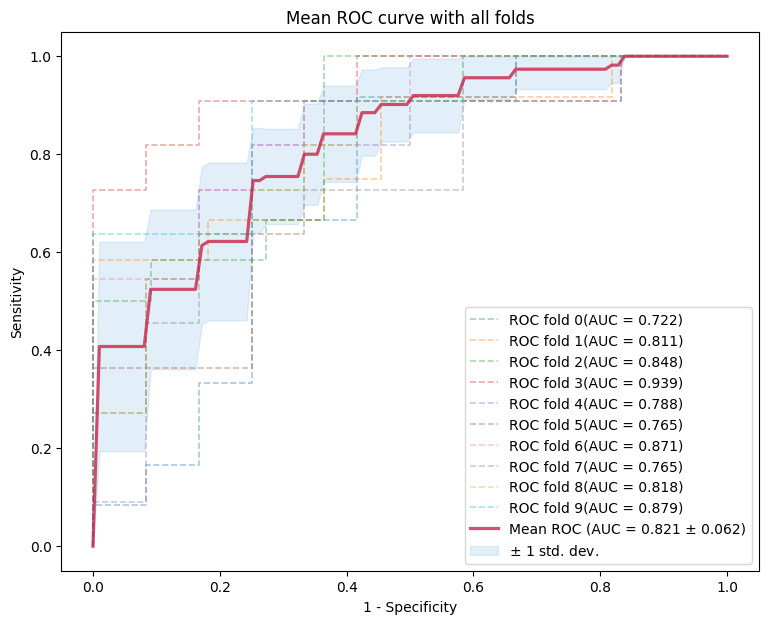

ROC curves saved successfully.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

mean_fpr = np.linspace(0, 1, 100)

# input_name = ['res_18_three','res_18_good_good_good','res_18_hui_good_good','res_18_hui_hui_good'
#               ,'res_18_lung_good_good','res_18_lung_lung_good']
input_name = ['res_18_three1']

for input_ in input_name:
    tprs = []
    aucs = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

        # 使用细线和虚线，并增加透明度
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(
            ax=ax,
            name=f"ROC fold {fold}(AUC = {three_auc:.3f})",
            linestyle='--',  # 设置虚线
            alpha=0.4,       # 设置透明度
            lw=1.2,            # 设置细线
        )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # 设置主要的平均ROC曲线，增加线宽
    ax.plot(
        mean_fpr,
        mean_tpr,
        color='#C9244C',
        label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2.3,  # 增加线宽
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="#6EB1DE",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="1 - Specificity",
        ylabel="Sensitivity",
        title=f"Mean ROC curve with all folds",
    )
    ax.legend(loc="lower right")

    plt.savefig((f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/inter_roc_fold.png'), dpi=500)
    plt.show()

print("ROC curves saved successfully.")

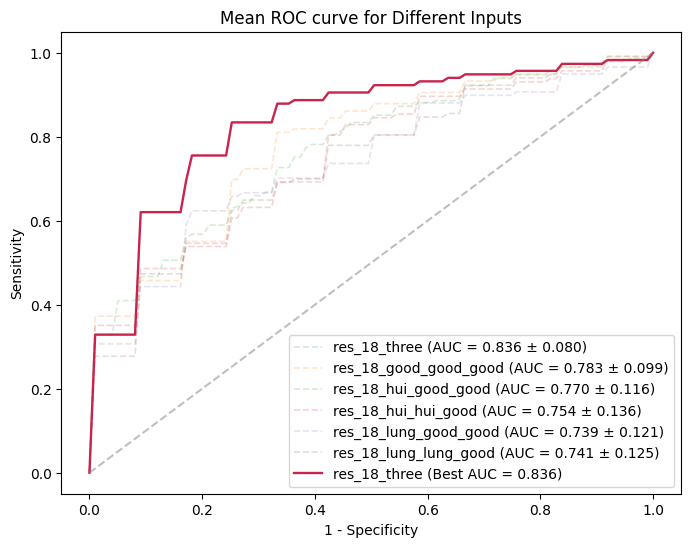

Mean ROC curve saved successfully.


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)
input_name = ['res_18_three','res_18_good_good_good','res_18_hui_good_good','res_18_hui_hui_good'
              ,'res_18_lung_good_good','res_18_lung_lung_good']

fig, ax = plt.subplots(figsize=(8, 6))
best_auc = 0.0
best_mean_tpr = None
best_input = None
for input_ in input_name:
    tprs = []
    aucs = []
        
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_mean_tpr = mean_tpr
        best_input = input_

    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{input_} (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        linestyle="--",
        alpha=0.2,
        lw=1.2
    )

ax.plot(
    mean_fpr,
    best_mean_tpr,
    label=f"{best_input} (Best AUC = {best_auc:.3f})",
    color='#C9244C',
    lw=1.7,
)

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.5)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specificity",
    ylabel="Sensitivity",
    title="Mean ROC curve for Different Inputs",
)
ax.legend(loc="lower right")

# 保存到指定路径
plt.savefig('/home/uii/loraya/DDR_carat/235例分割代码及结果/mean_roc_curve.png', dpi=500)
plt.show()

print("Mean ROC curve saved successfully.")

## 三个模型比较结果

FileNotFoundError: [Errno 2] No such file or directory: '/home/uii/loraya/DDR_carat/235例分割代码及结果/ResNet 18/Cross_valiation_fold/0/label.npy'

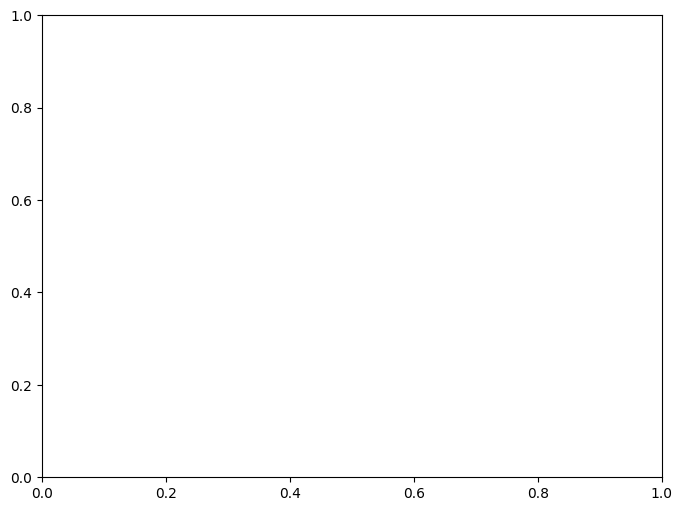

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay,auc

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)
input_name = ['ResNet 18','EfficientNet','VGG16']

fig, ax = plt.subplots(figsize=(8, 6))
best_auc = 0.0
best_mean_tpr = None
best_input = None
for input_ in input_name:
    tprs = []
    aucs = []
    for fold in cross_fold:

        label_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/235例分割代码及结果/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_mean_tpr = mean_tpr
        best_input = input_

    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{input_} (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        linestyle="--",
        alpha=0.5,
        lw=1.2
    )

ax.plot(
    mean_fpr,
    best_mean_tpr,
    label=f"{best_input} (Best AUC = {best_auc:.3f})",
    color='#C9244C',
    lw=1.7,
)

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.5)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specificity",
    ylabel="Sensitivity",
    title="Mean ROC curve for Different Models",
)
ax.legend(loc="lower right")

# 保存到指定路径
plt.savefig('/home/uii/loraya/DDR_carat/mean_roc_curve1.png', dpi=500)
plt.show()

print("Mean ROC curve saved successfully.")

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
input_name = ['res_18_three']
tprs = []
aucs = []
accuracies = []
specificities = []
sensitivities = []
precisions = []

for input_ in input_name:
    
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        accuracy = (score_three.round() == label_three).mean()
        tn, fp, fn, tp = confusion_matrix(label_three, score_three.round()).ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)

        accuracies.append(accuracy)
        specificities.append(specificity)
        sensitivities.append(sensitivity)
        precisions.append(precision)
        aucs.append(three_auc)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)

    results = {
        "Mean AUC": [mean_auc],
        "AUC Std": [std_auc],
        "Mean Accuracy": [mean_accuracy],
        "Accuracy Std": [std_accuracy],
        "Mean Specificity": [mean_specificity],
        "Specificity Std": [std_specificity],
        "Mean Sensitivity": [mean_sensitivity],
        "Sensitivity Std": [std_sensitivity],
        "Mean Precision": [mean_precision],
        "Precision Std": [std_precision]
    }

results_df = pd.DataFrame(results, index=["result"])
results_df.to_csv(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/abnormal_results.csv')

## three-PL

In [ ]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        PL_mask_file = os.path.join(self.data_root, clas, patient, 'PL_mask.npy')
        
        good_mask = np.load(good_mask_file)
        PL_mask = np.load(PL_mask_file)
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, PL_mask, lung_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_PL_data_235/'
abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array
normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 

total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 10折交叉验证
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200

fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_three_PL/Cross_valiation_fold/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    #输入
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset =DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    best_AUC = 0.0
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_sen,CM_spe,CM_pre = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
        print('Val_AUC: {} Val_ACC: {} Val_SEN: {} Val_SPE: {} Val_PRE: {}'.format(CM_auc,CM_acc,CM_sen,CM_spe,CM_pre))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_,_,_ = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_three_PL/Cross_valiation_fold/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} Sen: {CM_sen} Spe: {CM_spe} Pre: {CM_pre}\n')
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)



fig, ax = plt.subplots(figsize=(7, 6))

tprs = []
aucs = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_three_PL/Cross_valiation_fold/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_three_PL/Cross_valiation_fold/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#6EB1DE",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_carat/res_18_three_PL/Cross_valiation_fold/inter_roc_fold1.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

mean_fpr = np.linspace(0, 1, 100)

input_name = ['res_18_three_PL']

for input_ in input_name:
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(9, 7))
    for fold in cross_fold:

        label_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

        # 使用细线和虚线，并增加透明度
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(
            ax=ax,
            name=f"ROC fold {fold}(AUC = {three_auc:.3f})",
            linestyle='--',  # 设置虚线
            alpha=0.4,       # 设置透明度
            lw=1.2,            # 设置细线
        )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # 设置主要的平均ROC曲线，增加线宽
    ax.plot(
        mean_fpr,
        mean_tpr,
        color='#C9244C',
        label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2.3,  # 增加线宽
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="#6EB1DE",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="1 - Specificity",
        ylabel="Sensitivity",
        title=f"Mean ROC curve with all folds",
    )
    ax.legend(loc="lower right")

    plt.savefig((f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/inter_roc_fold.png'), dpi=500)
    plt.show()
    plt.close()

print("ROC curves saved successfully.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
input_name = ['res_18_three_PL']
tprs = []
aucs = []
accuracies = []
specificities = []
sensitivities = []
precisions = []

for input_ in input_name:
    
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        accuracy = (score_three.round() == label_three).mean()
        tn, fp, fn, tp = confusion_matrix(label_three, score_three.round()).ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)

        accuracies.append(accuracy)
        specificities.append(specificity)
        sensitivities.append(sensitivity)
        precisions.append(precision)
        aucs.append(three_auc)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)

    results = {
        "Mean AUC": [mean_auc],
        "AUC Std": [std_auc],
        "Mean Accuracy": [mean_accuracy],
        "Accuracy Std": [std_accuracy],
        "Mean Specificity": [mean_specificity],
        "Specificity Std": [std_specificity],
        "Mean Sensitivity": [mean_sensitivity],
        "Sensitivity Std": [std_sensitivity],
        "Mean Precision": [mean_precision],
        "Precision Std": [std_precision]
    }

results_df = pd.DataFrame(results, index=["result"])
results_df.to_csv(f'/home/uii/loraya/DDR_carat/{input_}/Cross_valiation_fold/abnormal_results.csv')

In [3]:
# 创建融合模型
# fusion_model = models.resnet18(pretrained=False)
# num_class = 2
# in_channel = fusion_model.fc.in_features
# fusion_model.fc = nn.Linear(in_channel, num_class, bias=True)

# model_paths = [os.path.join(r'/home/uii/loraya/DDR_carat/res_18_three/weight/', str(fold), 'best_val_auc.pth') for fold in range(5)]
# weight_paths = ['weight/0/best_val_auc.pth', 'weight/1/best_val_auc.pth', 'weight/2/best_val_auc.pth', 'weight/3/best_val_auc.pth', 'weight/4/best_val_auc.pth']
# models = []
# for model_path in model_paths:
#     model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
#     in_channel = model.fc.in_features
#     model.fc = nn.Linear(in_channel, num_class, bias=True)
#     model.load_state_dict(torch.load(model_path))
#     model.to(device)
#     model.eval()
#     models.append(model)    

# hui_good_good

In [5]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, good_mask, good_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [6]:
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score, auc
import seaborn as sns
import pandas as pd
from scipy import interp
import seaborn as sns
def mkdir(file_dir):
    if os.path.exists(file_dir):
        shutil.rmtree(file_dir)  # 删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)

def plot_roc_curve_with(fpr, tpr, thresholds, roc_auc, n_bootstrap=1000, save_dir=None):
    plt.figure(figsize=(6, 5))
    plt.title('Normal Classification ROC',  fontsize=14)
    plt.plot(fpr, tpr, color='#C9244C', label='Classification AUC = %0.3f' % roc_auc)
    ci_values = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(tpr), len(tpr))
        tpr_bootstrap = tpr[idx]
        fpr_bootstrap = fpr[idx]
        ci_lower = np.maximum(tpr_bootstrap - fpr_bootstrap, 0)
        ci_values.append(ci_lower)
        
    ci_values = np.percentile(ci_values, [2.5, 97.5], axis=0)
    lower_tprs, upper_tprs = ci_values[0], ci_values[1]

    
    plt.plot([0, 1], [0, 1], color='#C0C0C0', linestyle='--', alpha=0.5)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.ylabel('Sentivity')
    plt.xlabel('1 - Specifity')
    legend =plt.legend(loc='lower right', frameon=True)
    frame = legend.get_frame()
    frame.set_edgecolor('#5D565A')  # 设置图例边框颜色为指定的颜色
    frame.set_linewidth(1)  # 设置图例边框线宽度为1

    best_threshold_index = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_index]
    best_fpr = fpr[best_threshold_index]
    best_tpr = tpr[best_threshold_index]

    # 计算并显示sensitivity、specificity、precision的值和置信区间
    specificity = 1 - fpr
    sensitivity = tpr
    denominator = sensitivity + fpr
    precision = np.divide(sensitivity, denominator, out=np.zeros_like(sensitivity), where=denominator!=0)

    # 添加黑色边框
    for spine in plt.gca().spines.values():
        spine.set_color('black')

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'Resnet18 Cross ROC Normal.png'), dpi=300)
    plt.show()

In [7]:
def calculate_metrics(labels_one_hot_all, pred_scores_all, save_dir=None):
    new_dir = save_dir
    pred_scores_all = torch.cat(pred_scores_all, dim=0).numpy()
    labels_one_hot_all = torch.cat(labels_one_hot_all, dim=0).numpy()
    labels_all = np.argmax(labels_one_hot_all, axis=1)
    
    AUC = roc_auc_score(labels_one_hot_all, pred_scores_all)
    
    pred_scores_all = pred_scores_all[:, 1]
    fpr, tpr, thresholds = roc_curve(labels_all, pred_scores_all)
    if save_dir:
        np.save(os.path.join(new_dir, 'label.npy'), np.array(labels_all))
        np.save(os.path.join(new_dir, 'score.npy'), np.array(pred_scores_all))
    diff = tpr - fpr
    diff[0] = -10
    index = np.argmax(diff)
    thresholds_best = thresholds[index]
    pred_scores_all[pred_scores_all > thresholds_best] = 1
    pred_scores_all[pred_scores_all <= thresholds_best] = 0
    
    ACC = accuracy_score(labels_all, pred_scores_all)
    sensitivity = recall_score(labels_all, pred_scores_all)
    specifity = recall_score(labels_all, pred_scores_all, pos_label=0)
    precision = precision_score(labels_all, pred_scores_all)
    
    global best_AUC
    if AUC > best_AUC:
        best_AUC = AUC
        ROC =  plot_roc_curve_with(fpr, tpr, thresholds, AUC,  save_dir=save_dir) 
    
    return AUC, ACC, sensitivity, specifity, precision

In [8]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_235/'
abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array
normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 

total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 10折交叉验证
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.685  train_accuracy: 0.543


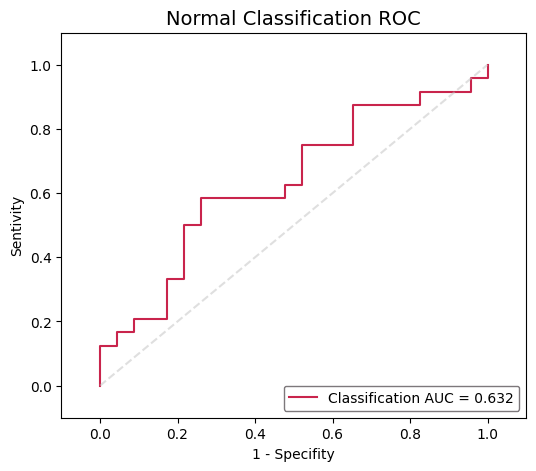

Val_AUC: 0.6322463768115942 Val_ACC: 0.6382978723404256 Val_SEN: 0.5416666666666666 Val_SPE: 0.7391304347826086 Val_PRE: 0.6842105263157895
[epoch 2] train_loss: 0.620  train_accuracy: 0.670


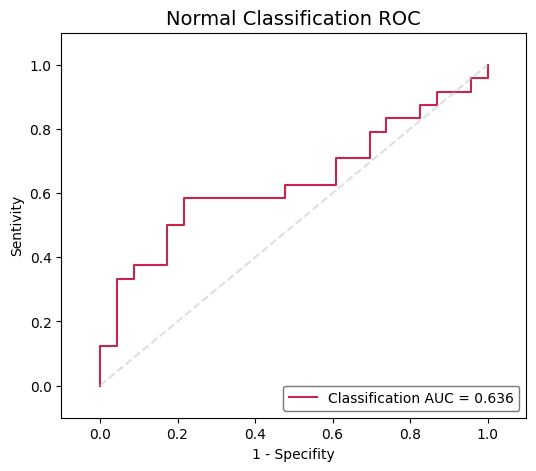

Val_AUC: 0.6358695652173914 Val_ACC: 0.6595744680851063 Val_SEN: 0.5416666666666666 Val_SPE: 0.782608695652174 Val_PRE: 0.7222222222222222
[epoch 3] train_loss: 0.602  train_accuracy: 0.681


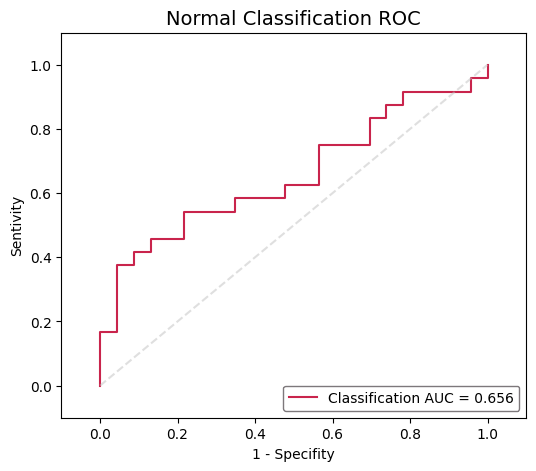

Val_AUC: 0.6557971014492754 Val_ACC: 0.6382978723404256 Val_SEN: 0.3333333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.8888888888888888
[epoch 4] train_loss: 0.554  train_accuracy: 0.750


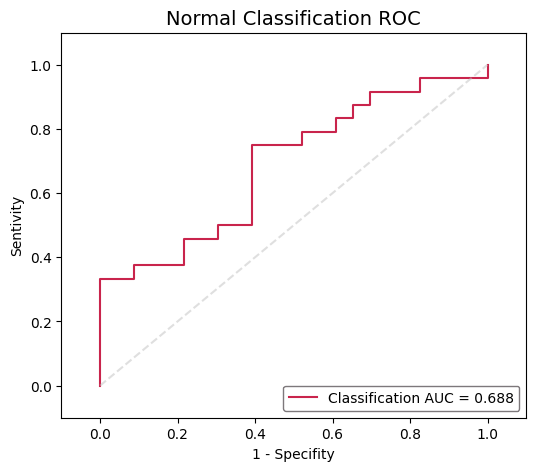

Val_AUC: 0.6884057971014492 Val_ACC: 0.6595744680851063 Val_SEN: 0.7083333333333334 Val_SPE: 0.6086956521739131 Val_PRE: 0.6538461538461539
[epoch 5] train_loss: 0.540  train_accuracy: 0.771


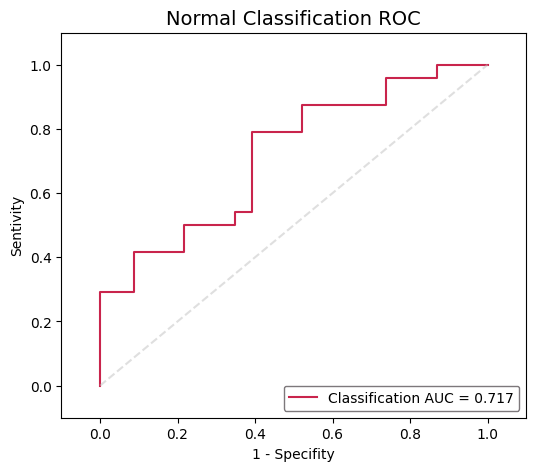

Val_AUC: 0.717391304347826 Val_ACC: 0.6808510638297872 Val_SEN: 0.75 Val_SPE: 0.6086956521739131 Val_PRE: 0.6666666666666666
[epoch 6] train_loss: 0.500  train_accuracy: 0.819


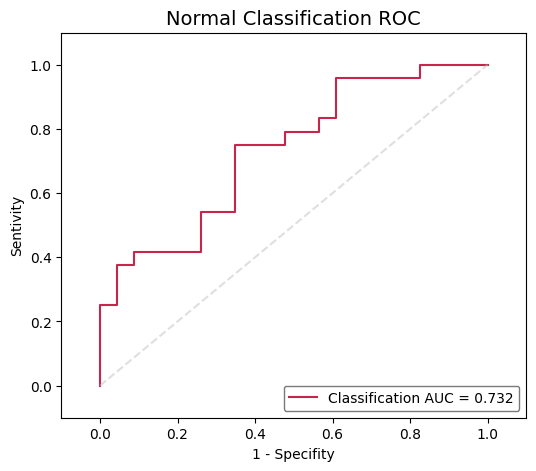

Val_AUC: 0.7318840579710145 Val_ACC: 0.6808510638297872 Val_SEN: 0.7083333333333334 Val_SPE: 0.6521739130434783 Val_PRE: 0.68
[epoch 7] train_loss: 0.510  train_accuracy: 0.787


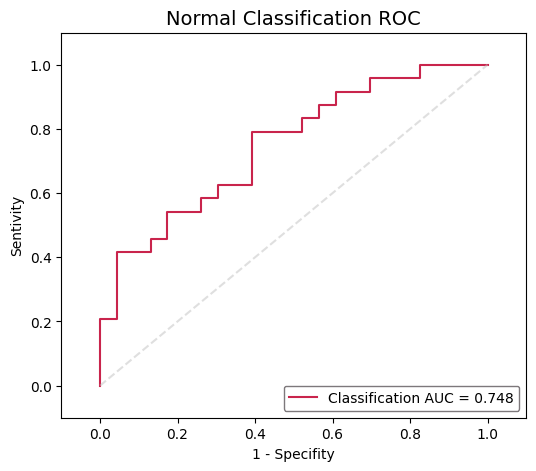

Val_AUC: 0.7481884057971014 Val_ACC: 0.6808510638297872 Val_SEN: 0.75 Val_SPE: 0.6086956521739131 Val_PRE: 0.6666666666666666
[epoch 8] train_loss: 0.503  train_accuracy: 0.803
Val_AUC: 0.7210144927536232 Val_ACC: 0.7021276595744681 Val_SEN: 0.75 Val_SPE: 0.6521739130434783 Val_PRE: 0.6923076923076923
[epoch 9] train_loss: 0.477  train_accuracy: 0.851
Val_AUC: 0.7336956521739131 Val_ACC: 0.7021276595744681 Val_SEN: 0.75 Val_SPE: 0.6521739130434783 Val_PRE: 0.6923076923076923
[epoch 10] train_loss: 0.479  train_accuracy: 0.835
Val_AUC: 0.730072463768116 Val_ACC: 0.6808510638297872 Val_SEN: 0.375 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 11] train_loss: 0.480  train_accuracy: 0.830
Val_AUC: 0.713768115942029 Val_ACC: 0.6808510638297872 Val_SEN: 0.75 Val_SPE: 0.6086956521739131 Val_PRE: 0.6666666666666666
[epoch 12] train_loss: 0.474  train_accuracy: 0.835
Val_AUC: 0.6884057971014492 Val_ACC: 0.6808510638297872 Val_SEN: 0.5833333333333334 Val_SPE: 0.782608695652174 Val_PRE: 0.7368421052631579
[epo

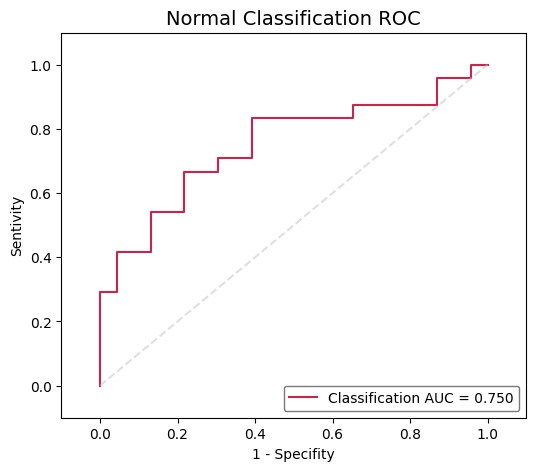

Val_AUC: 0.75 Val_ACC: 0.7021276595744681 Val_SEN: 0.625 Val_SPE: 0.782608695652174 Val_PRE: 0.75
[epoch 14] train_loss: 0.459  train_accuracy: 0.851
Val_AUC: 0.7192028985507246 Val_ACC: 0.7021276595744681 Val_SEN: 0.7083333333333334 Val_SPE: 0.6956521739130435 Val_PRE: 0.7083333333333334
[epoch 15] train_loss: 0.449  train_accuracy: 0.851
Val_AUC: 0.7318840579710145 Val_ACC: 0.7021276595744681 Val_SEN: 0.5416666666666666 Val_SPE: 0.8695652173913043 Val_PRE: 0.8125
[epoch 16] train_loss: 0.443  train_accuracy: 0.883
Val_AUC: 0.75 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 17] train_loss: 0.416  train_accuracy: 0.899


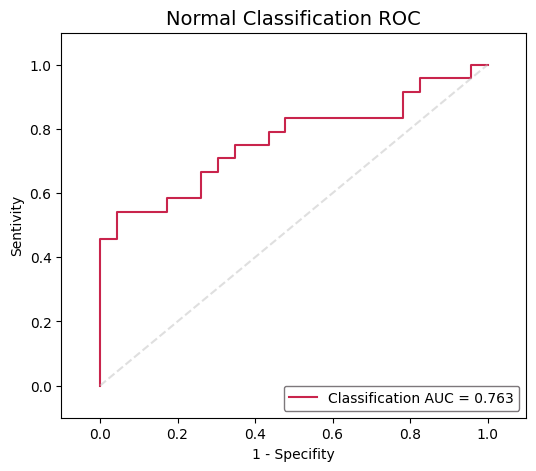

Val_AUC: 0.7626811594202898 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 18] train_loss: 0.427  train_accuracy: 0.894
Val_AUC: 0.7626811594202898 Val_ACC: 0.723404255319149 Val_SEN: 0.4583333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 19] train_loss: 0.437  train_accuracy: 0.862


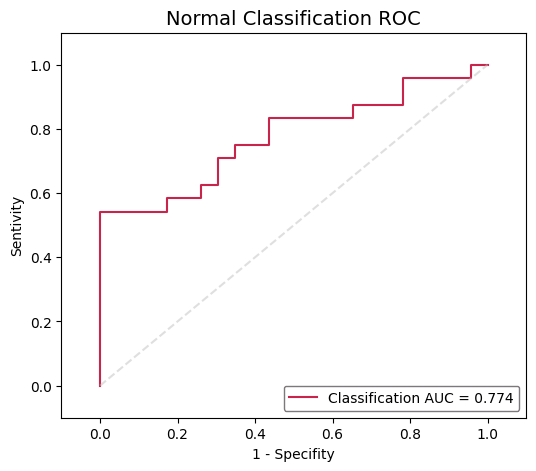

Val_AUC: 0.7735507246376812 Val_ACC: 0.7446808510638298 Val_SEN: 0.5 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 20] train_loss: 0.411  train_accuracy: 0.899
Val_AUC: 0.7717391304347826 Val_ACC: 0.723404255319149 Val_SEN: 0.4583333333333333 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 21] train_loss: 0.417  train_accuracy: 0.878
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 22] train_loss: 0.432  train_accuracy: 0.899
Val_AUC: 0.7717391304347826 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 23] train_loss: 0.417  train_accuracy: 0.894


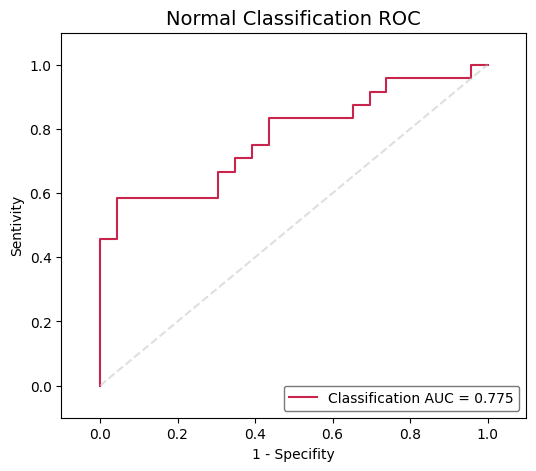

Val_AUC: 0.7753623188405798 Val_ACC: 0.7446808510638298 Val_SEN: 0.5416666666666666 Val_SPE: 0.9565217391304348 Val_PRE: 0.9285714285714286
[epoch 24] train_loss: 0.411  train_accuracy: 0.904
Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 25] train_loss: 0.422  train_accuracy: 0.878
Val_AUC: 0.7626811594202898 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 26] train_loss: 0.432  train_accuracy: 0.878
Val_AUC: 0.7536231884057971 Val_ACC: 0.6808510638297872 Val_SEN: 0.4583333333333333 Val_SPE: 0.9130434782608695 Val_PRE: 0.8461538461538461
[epoch 27] train_loss: 0.408  train_accuracy: 0.904
Val_AUC: 0.7590579710144927 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 28] train_loss: 0.423  train_accuracy: 0.883
Val_AUC: 0.7608695652173914 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_

Val_AUC: 0.75 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 69] train_loss: 0.396  train_accuracy: 0.915
Val_AUC: 0.7572463768115942 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 70] train_loss: 0.421  train_accuracy: 0.894
Val_AUC: 0.7572463768115942 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 71] train_loss: 0.418  train_accuracy: 0.888
Val_AUC: 0.7608695652173914 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 72] train_loss: 0.391  train_accuracy: 0.931
Val_AUC: 0.7626811594202898 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 73] train_loss: 0.401  train_accuracy: 0.915
Val_AUC: 0.7554347826086956 Val_ACC: 0.702127659574468

[epoch 113] train_loss: 0.454  train_accuracy: 0.856
Val_AUC: 0.7572463768115942 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 114] train_loss: 0.401  train_accuracy: 0.915
Val_AUC: 0.7518115942028986 Val_ACC: 0.6808510638297872 Val_SEN: 0.4166666666666667 Val_SPE: 0.9565217391304348 Val_PRE: 0.9090909090909091
[epoch 115] train_loss: 0.383  train_accuracy: 0.936
Val_AUC: 0.7608695652173914 Val_ACC: 0.7021276595744681 Val_SEN: 0.5 Val_SPE: 0.9130434782608695 Val_PRE: 0.8571428571428571
[epoch 116] train_loss: 0.436  train_accuracy: 0.840
Val_AUC: 0.7608695652173914 Val_ACC: 0.7021276595744681 Val_SEN: 0.4166666666666667 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 117] train_loss: 0.405  train_accuracy: 0.894
Val_AUC: 0.7590579710144927 Val_ACC: 0.723404255319149 Val_SEN: 0.5 Val_SPE: 0.9565217391304348 Val_PRE: 0.9230769230769231
[epoch 118] train_loss: 0.400  train_accuracy: 0.904
Val_AUC: 0.7626811594202898 Val_ACC: 0.7021

Val_AUC: 0.7572463768115942 Val_ACC: 0.6808510638297872 Val_SEN: 0.4166666666666667 Val_SPE: 0.9565217391304348 Val_PRE: 0.9090909090909091
[epoch 158] train_loss: 0.406  train_accuracy: 0.910
Val_AUC: 0.7590579710144927 Val_ACC: 0.7021276595744681 Val_SEN: 0.4583333333333333 Val_SPE: 0.9565217391304348 Val_PRE: 0.9166666666666666
[epoch 159] train_loss: 0.404  train_accuracy: 0.904
Val_AUC: 0.7572463768115942 Val_ACC: 0.7021276595744681 Val_SEN: 0.5 Val_SPE: 0.9130434782608695 Val_PRE: 0.8571428571428571
[epoch 160] train_loss: 0.393  train_accuracy: 0.915
Val_AUC: 0.7536231884057971 Val_ACC: 0.6808510638297872 Val_SEN: 0.4166666666666667 Val_SPE: 0.9565217391304348 Val_PRE: 0.9090909090909091
[epoch 161] train_loss: 0.393  train_accuracy: 0.920
Val_AUC: 0.7554347826086956 Val_ACC: 0.6808510638297872 Val_SEN: 0.4166666666666667 Val_SPE: 0.9565217391304348 Val_PRE: 0.9090909090909091
[epoch 162] train_loss: 0.421  train_accuracy: 0.894
Val_AUC: 0.7590579710144927 Val_ACC: 0.70212765957

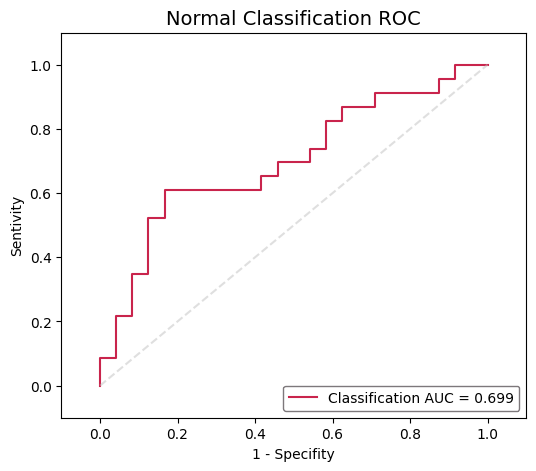

Val_AUC: 0.6992753623188406 Val_ACC: 0.7021276595744681 Val_SEN: 0.5652173913043478 Val_SPE: 0.8333333333333334 Val_PRE: 0.7647058823529411
[epoch 2] train_loss: 0.631  train_accuracy: 0.633


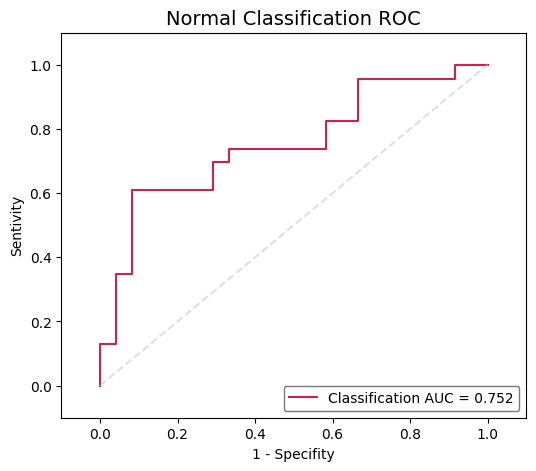

Val_AUC: 0.7518115942028986 Val_ACC: 0.7446808510638298 Val_SEN: 0.5652173913043478 Val_SPE: 0.9166666666666666 Val_PRE: 0.8666666666666667
[epoch 3] train_loss: 0.605  train_accuracy: 0.713


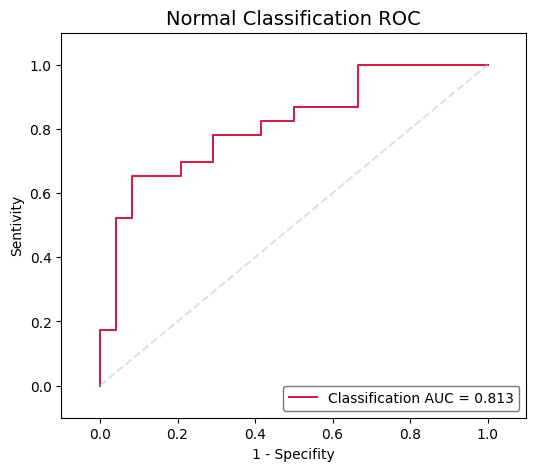

Val_AUC: 0.8134057971014492 Val_ACC: 0.7659574468085106 Val_SEN: 0.6086956521739131 Val_SPE: 0.9166666666666666 Val_PRE: 0.875
[epoch 4] train_loss: 0.572  train_accuracy: 0.729


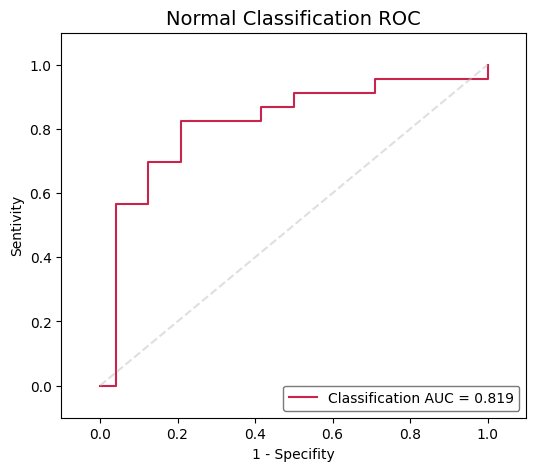

Val_AUC: 0.8188405797101449 Val_ACC: 0.7872340425531915 Val_SEN: 0.782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.782608695652174
[epoch 5] train_loss: 0.567  train_accuracy: 0.702


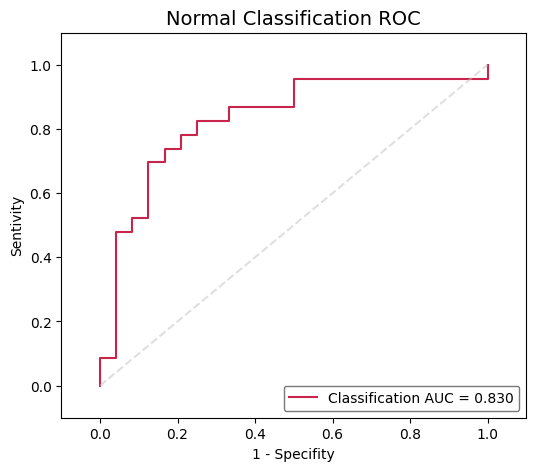

Val_AUC: 0.8297101449275363 Val_ACC: 0.7659574468085106 Val_SEN: 0.782608695652174 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 6] train_loss: 0.551  train_accuracy: 0.739
Val_AUC: 0.7934782608695652 Val_ACC: 0.7659574468085106 Val_SEN: 0.7391304347826086 Val_SPE: 0.7916666666666666 Val_PRE: 0.7727272727272727
[epoch 7] train_loss: 0.526  train_accuracy: 0.745
Val_AUC: 0.8170289855072463 Val_ACC: 0.7446808510638298 Val_SEN: 0.782608695652174 Val_SPE: 0.7083333333333334 Val_PRE: 0.72
[epoch 8] train_loss: 0.529  train_accuracy: 0.782


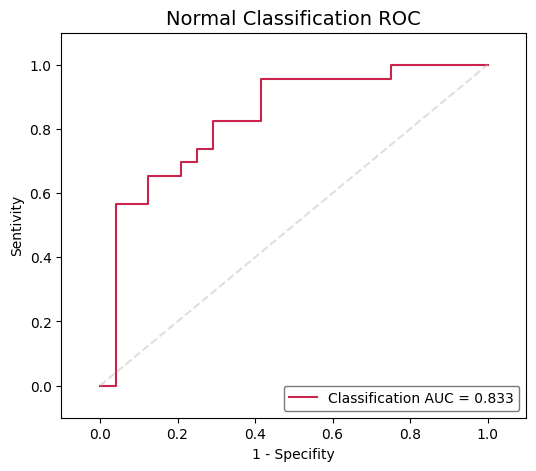

Val_AUC: 0.8333333333333334 Val_ACC: 0.7446808510638298 Val_SEN: 0.9130434782608695 Val_SPE: 0.5833333333333334 Val_PRE: 0.6774193548387096
[epoch 9] train_loss: 0.518  train_accuracy: 0.782


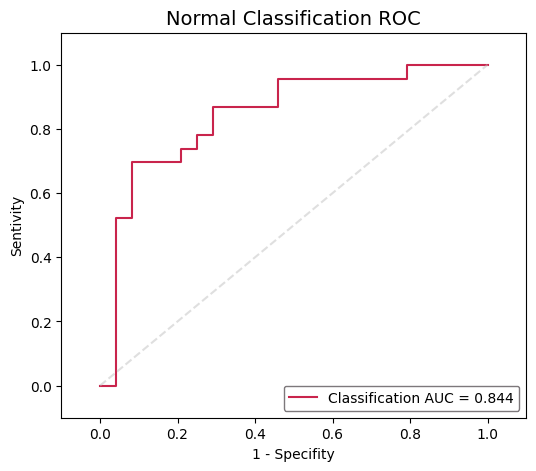

Val_AUC: 0.8442028985507246 Val_ACC: 0.7872340425531915 Val_SEN: 0.6521739130434783 Val_SPE: 0.9166666666666666 Val_PRE: 0.8823529411764706
[epoch 10] train_loss: 0.517  train_accuracy: 0.771


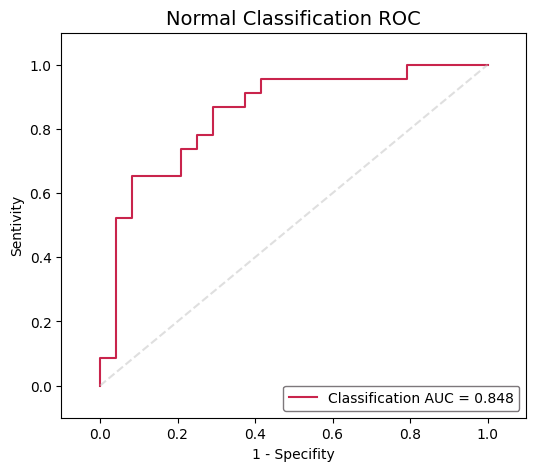

Val_AUC: 0.8478260869565218 Val_ACC: 0.7659574468085106 Val_SEN: 0.8260869565217391 Val_SPE: 0.7083333333333334 Val_PRE: 0.7307692307692307
[epoch 11] train_loss: 0.483  train_accuracy: 0.824
Val_AUC: 0.8079710144927537 Val_ACC: 0.7446808510638298 Val_SEN: 0.7391304347826086 Val_SPE: 0.75 Val_PRE: 0.7391304347826086
[epoch 12] train_loss: 0.497  train_accuracy: 0.803
Val_AUC: 0.7898550724637681 Val_ACC: 0.7446808510638298 Val_SEN: 0.7391304347826086 Val_SPE: 0.75 Val_PRE: 0.7391304347826086
[epoch 13] train_loss: 0.446  train_accuracy: 0.883
Val_AUC: 0.8170289855072463 Val_ACC: 0.7446808510638298 Val_SEN: 0.6521739130434783 Val_SPE: 0.8333333333333334 Val_PRE: 0.7894736842105263
[epoch 14] train_loss: 0.483  train_accuracy: 0.824


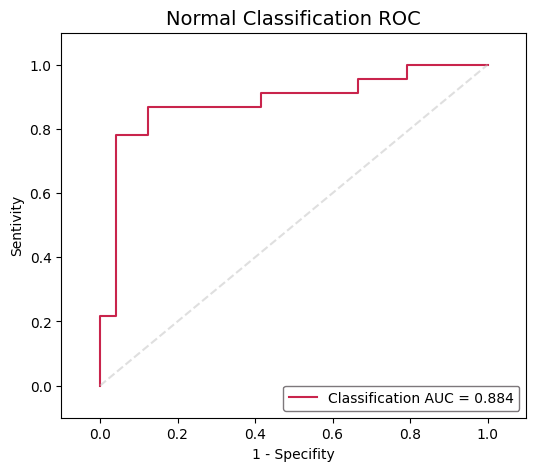

Val_AUC: 0.8840579710144927 Val_ACC: 0.851063829787234 Val_SEN: 0.8260869565217391 Val_SPE: 0.875 Val_PRE: 0.8636363636363636
[epoch 15] train_loss: 0.422  train_accuracy: 0.904


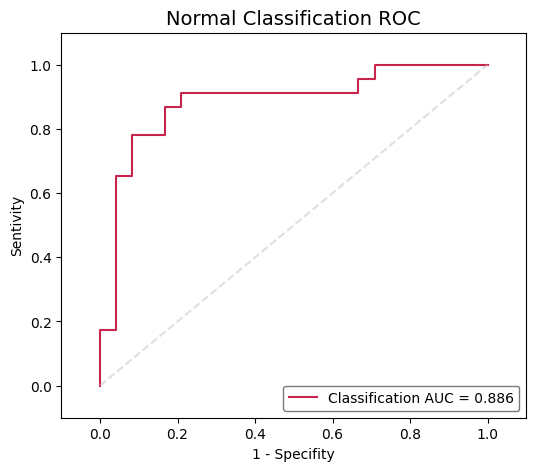

Val_AUC: 0.8858695652173912 Val_ACC: 0.8297872340425532 Val_SEN: 0.8695652173913043 Val_SPE: 0.7916666666666666 Val_PRE: 0.8
[epoch 16] train_loss: 0.453  train_accuracy: 0.867


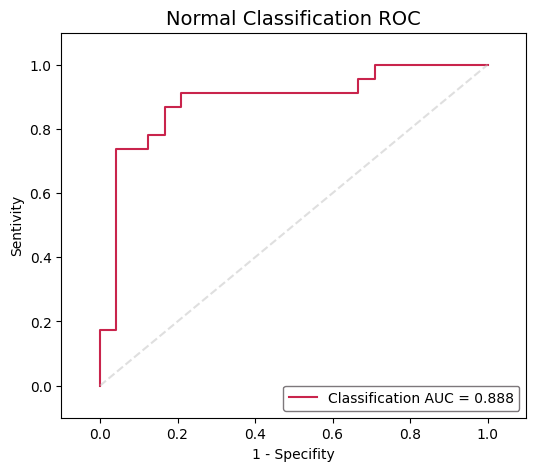

Val_AUC: 0.8876811594202898 Val_ACC: 0.8297872340425532 Val_SEN: 0.8695652173913043 Val_SPE: 0.7916666666666666 Val_PRE: 0.8
[epoch 17] train_loss: 0.460  train_accuracy: 0.851
Val_AUC: 0.8876811594202898 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043 Val_SPE: 0.8333333333333334 Val_PRE: 0.8333333333333334
[epoch 18] train_loss: 0.454  train_accuracy: 0.862


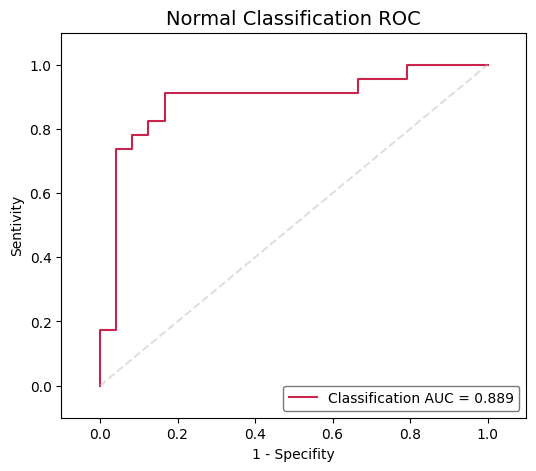

Val_AUC: 0.8894927536231885 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043 Val_SPE: 0.8333333333333334 Val_PRE: 0.8333333333333334
[epoch 19] train_loss: 0.443  train_accuracy: 0.888


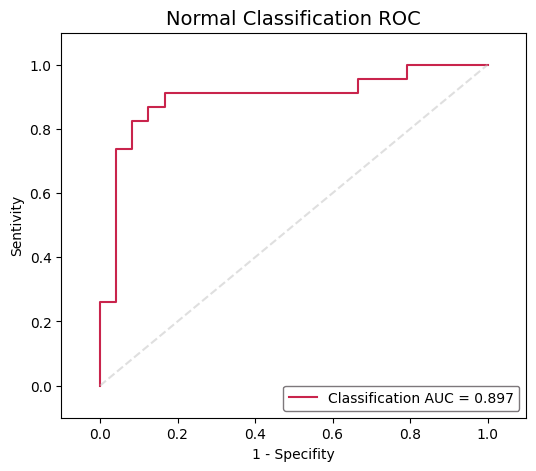

Val_AUC: 0.8967391304347827 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043 Val_SPE: 0.8333333333333334 Val_PRE: 0.8333333333333334
[epoch 20] train_loss: 0.443  train_accuracy: 0.872
Val_AUC: 0.8967391304347826 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043 Val_SPE: 0.8333333333333334 Val_PRE: 0.8333333333333334
[epoch 21] train_loss: 0.451  train_accuracy: 0.856
Val_AUC: 0.894927536231884 Val_ACC: 0.8723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.9583333333333334 Val_PRE: 0.9473684210526315
[epoch 22] train_loss: 0.440  train_accuracy: 0.872


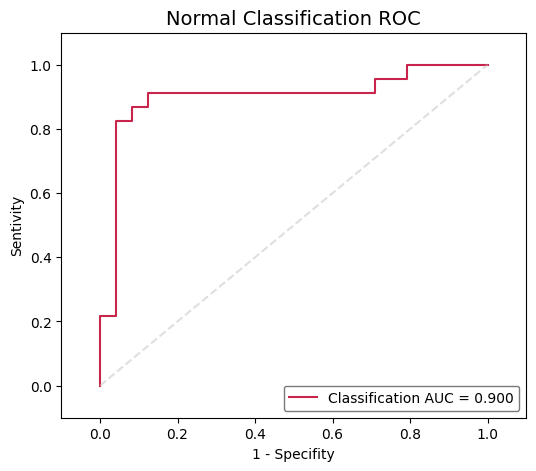

Val_AUC: 0.9003623188405797 Val_ACC: 0.8723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.875 Val_PRE: 0.8695652173913043
[epoch 23] train_loss: 0.428  train_accuracy: 0.883
Val_AUC: 0.894927536231884 Val_ACC: 0.8723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.875 Val_PRE: 0.8695652173913043
[epoch 24] train_loss: 0.412  train_accuracy: 0.915
Val_AUC: 0.8967391304347825 Val_ACC: 0.8723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.9166666666666666 Val_PRE: 0.9047619047619048
[epoch 25] train_loss: 0.419  train_accuracy: 0.894
Val_AUC: 0.8931159420289856 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043 Val_SPE: 0.8333333333333334 Val_PRE: 0.8333333333333334
[epoch 26] train_loss: 0.448  train_accuracy: 0.867
Val_AUC: 0.894927536231884 Val_ACC: 0.8723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.875 Val_PRE: 0.8695652173913043
[epoch 27] train_loss: 0.446  train_accuracy: 0.846
Val_AUC: 0.8894927536231885 Val_ACC: 0.851063829787234 Val_SEN: 0.8695652173913043

[epoch 68] train_loss: 0.410  train_accuracy: 0.894
Val_AUC: 0.8695652173913044 Val_ACC: 0.8297872340425532 Val_SEN: 0.782608695652174 Val_SPE: 0.875 Val_PRE: 0.8571428571428571
[epoch 69] train_loss: 0.409  train_accuracy: 0.888
Val_AUC: 0.8695652173913044 Val_ACC: 0.851063829787234 Val_SEN: 0.7391304347826086 Val_SPE: 0.9583333333333334 Val_PRE: 0.9444444444444444
[epoch 70] train_loss: 0.414  train_accuracy: 0.888
Val_AUC: 0.8677536231884058 Val_ACC: 0.8297872340425532 Val_SEN: 0.782608695652174 Val_SPE: 0.875 Val_PRE: 0.8571428571428571
[epoch 71] train_loss: 0.413  train_accuracy: 0.894
Val_AUC: 0.8677536231884058 Val_ACC: 0.8085106382978723 Val_SEN: 0.782608695652174 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 72] train_loss: 0.436  train_accuracy: 0.872
Val_AUC: 0.8677536231884058 Val_ACC: 0.8085106382978723 Val_SEN: 0.7391304347826086 Val_SPE: 0.875 Val_PRE: 0.85
[epoch 73] train_loss: 0.402  train_accuracy: 0.915
Val_AUC: 0.8659420289855073 Val_ACC: 0.808510

[epoch 114] train_loss: 0.386  train_accuracy: 0.957
Val_AUC: 0.8713768115942029 Val_ACC: 0.851063829787234 Val_SEN: 0.7391304347826086 Val_SPE: 0.9583333333333334 Val_PRE: 0.9444444444444444
[epoch 115] train_loss: 0.400  train_accuracy: 0.926
Val_AUC: 0.8623188405797102 Val_ACC: 0.8085106382978723 Val_SEN: 0.7391304347826086 Val_SPE: 0.875 Val_PRE: 0.85
[epoch 116] train_loss: 0.415  train_accuracy: 0.878
Val_AUC: 0.8677536231884058 Val_ACC: 0.8297872340425532 Val_SEN: 0.7391304347826086 Val_SPE: 0.9166666666666666 Val_PRE: 0.8947368421052632
[epoch 117] train_loss: 0.402  train_accuracy: 0.926
Val_AUC: 0.8713768115942029 Val_ACC: 0.8297872340425532 Val_SEN: 0.7391304347826086 Val_SPE: 0.9166666666666666 Val_PRE: 0.8947368421052632
[epoch 118] train_loss: 0.425  train_accuracy: 0.856
Val_AUC: 0.8641304347826086 Val_ACC: 0.8085106382978723 Val_SEN: 0.782608695652174 Val_SPE: 0.8333333333333334 Val_PRE: 0.8181818181818182
[epoch 119] train_loss: 0.408  train_accuracy: 0.926
Val_AUC: 0.

[epoch 159] train_loss: 0.411  train_accuracy: 0.915
Val_AUC: 0.8659420289855073 Val_ACC: 0.8297872340425532 Val_SEN: 0.6956521739130435 Val_SPE: 0.9583333333333334 Val_PRE: 0.9411764705882353
[epoch 160] train_loss: 0.410  train_accuracy: 0.904
Val_AUC: 0.8695652173913044 Val_ACC: 0.8297872340425532 Val_SEN: 0.782608695652174 Val_SPE: 0.875 Val_PRE: 0.8571428571428571
[epoch 161] train_loss: 0.392  train_accuracy: 0.941
Val_AUC: 0.8677536231884058 Val_ACC: 0.8297872340425532 Val_SEN: 0.782608695652174 Val_SPE: 0.875 Val_PRE: 0.8571428571428571
[epoch 162] train_loss: 0.414  train_accuracy: 0.883
Val_AUC: 0.8641304347826088 Val_ACC: 0.8297872340425532 Val_SEN: 0.7391304347826086 Val_SPE: 0.9166666666666666 Val_PRE: 0.8947368421052632
[epoch 163] train_loss: 0.413  train_accuracy: 0.915
Val_AUC: 0.8623188405797102 Val_ACC: 0.8085106382978723 Val_SEN: 0.7391304347826086 Val_SPE: 0.875 Val_PRE: 0.85
[epoch 164] train_loss: 0.424  train_accuracy: 0.883
Val_AUC: 0.8623188405797102 Val_ACC: 

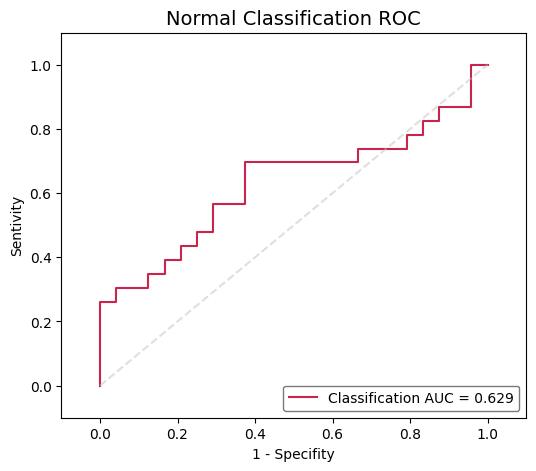

Val_AUC: 0.6286231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.6521739130434783 Val_SPE: 0.625 Val_PRE: 0.625
[epoch 2] train_loss: 0.603  train_accuracy: 0.691


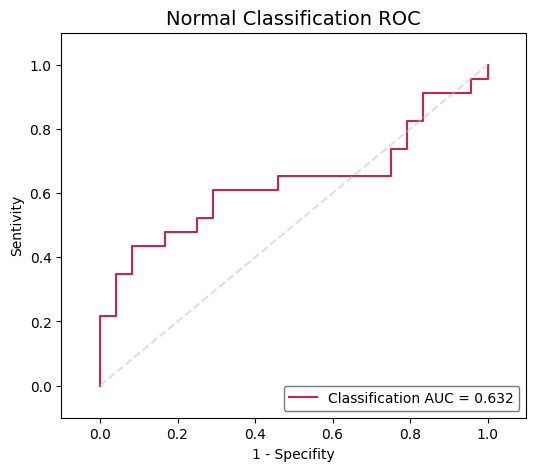

Val_AUC: 0.6322463768115942 Val_ACC: 0.6595744680851063 Val_SEN: 0.391304347826087 Val_SPE: 0.9166666666666666 Val_PRE: 0.8181818181818182
[epoch 3] train_loss: 0.562  train_accuracy: 0.734
Val_AUC: 0.6086956521739131 Val_ACC: 0.6170212765957447 Val_SEN: 0.43478260869565216 Val_SPE: 0.7916666666666666 Val_PRE: 0.6666666666666666
[epoch 4] train_loss: 0.551  train_accuracy: 0.739
Val_AUC: 0.5869565217391304 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 5] train_loss: 0.520  train_accuracy: 0.782


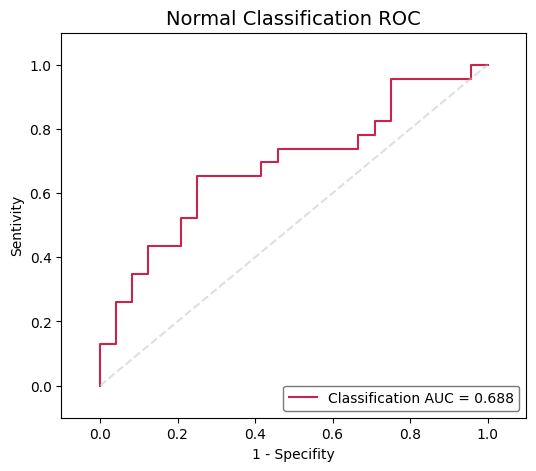

Val_AUC: 0.6884057971014492 Val_ACC: 0.6808510638297872 Val_SEN: 0.6086956521739131 Val_SPE: 0.75 Val_PRE: 0.7
[epoch 6] train_loss: 0.507  train_accuracy: 0.819


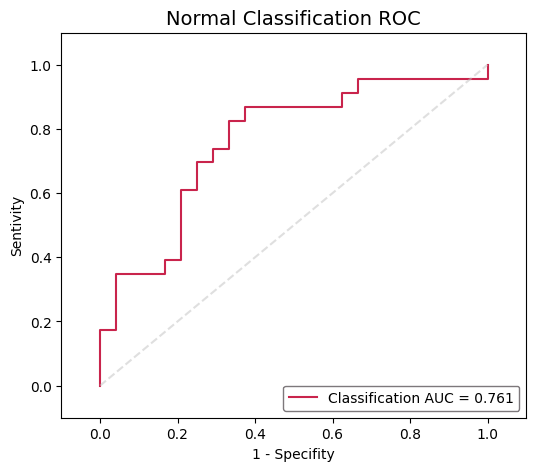

Val_AUC: 0.7608695652173914 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 7] train_loss: 0.497  train_accuracy: 0.814
Val_AUC: 0.713768115942029 Val_ACC: 0.6808510638297872 Val_SEN: 0.782608695652174 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 8] train_loss: 0.486  train_accuracy: 0.819
Val_AUC: 0.6630434782608696 Val_ACC: 0.6595744680851063 Val_SEN: 0.6521739130434783 Val_SPE: 0.6666666666666666 Val_PRE: 0.6521739130434783
[epoch 9] train_loss: 0.479  train_accuracy: 0.830
Val_AUC: 0.6666666666666666 Val_ACC: 0.6382978723404256 Val_SEN: 0.782608695652174 Val_SPE: 0.5 Val_PRE: 0.6
[epoch 10] train_loss: 0.476  train_accuracy: 0.824
Val_AUC: 0.6304347826086956 Val_ACC: 0.6170212765957447 Val_SEN: 0.5217391304347826 Val_SPE: 0.7083333333333334 Val_PRE: 0.631578947368421
[epoch 11] train_loss: 0.469  train_accuracy: 0.830
Val_AUC: 0.625 Val_ACC: 0.5957446808510638 Val_SEN: 0.782608695652174 Val_SPE: 0.4166666666

Val_AUC: 0.6630434782608696 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 52] train_loss: 0.399  train_accuracy: 0.920
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 53] train_loss: 0.388  train_accuracy: 0.920
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 54] train_loss: 0.397  train_accuracy: 0.926
Val_AUC: 0.6630434782608696 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 55] train_loss: 0.400  train_accuracy: 0.920
Val_AUC: 0.6648550724637681 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 56] train_loss: 0.427  train_accuracy: 0.883
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666

Val_AUC: 0.6594202898550725 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 98] train_loss: 0.411  train_accuracy: 0.910
Val_AUC: 0.6648550724637681 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 99] train_loss: 0.421  train_accuracy: 0.888
Val_AUC: 0.6648550724637681 Val_ACC: 0.6595744680851063 Val_SEN: 0.5217391304347826 Val_SPE: 0.7916666666666666 Val_PRE: 0.7058823529411765
[epoch 100] train_loss: 0.404  train_accuracy: 0.894
Val_AUC: 0.6648550724637681 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 101] train_loss: 0.412  train_accuracy: 0.878
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 102] train_loss: 0.411  train_accuracy: 0.904
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 

[epoch 143] train_loss: 0.387  train_accuracy: 0.920
Val_AUC: 0.6702898550724637 Val_ACC: 0.6595744680851063 Val_SEN: 0.5217391304347826 Val_SPE: 0.7916666666666666 Val_PRE: 0.7058823529411765
[epoch 144] train_loss: 0.404  train_accuracy: 0.920
Val_AUC: 0.6684782608695652 Val_ACC: 0.6595744680851063 Val_SEN: 0.5217391304347826 Val_SPE: 0.7916666666666666 Val_PRE: 0.7058823529411765
[epoch 145] train_loss: 0.431  train_accuracy: 0.867
Val_AUC: 0.6684782608695652 Val_ACC: 0.6595744680851063 Val_SEN: 0.5217391304347826 Val_SPE: 0.7916666666666666 Val_PRE: 0.7058823529411765
[epoch 146] train_loss: 0.419  train_accuracy: 0.899
Val_AUC: 0.6630434782608696 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 147] train_loss: 0.411  train_accuracy: 0.894
Val_AUC: 0.6648550724637681 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 148] train_loss: 0.397  train_accuracy: 0.941
Val_AU

Val_AUC: 0.6702898550724637 Val_ACC: 0.6595744680851063 Val_SEN: 0.5217391304347826 Val_SPE: 0.7916666666666666 Val_PRE: 0.7058823529411765
[epoch 189] train_loss: 0.427  train_accuracy: 0.878
Val_AUC: 0.6684782608695652 Val_ACC: 0.6382978723404256 Val_SEN: 0.5652173913043478 Val_SPE: 0.7083333333333334 Val_PRE: 0.65
[epoch 190] train_loss: 0.426  train_accuracy: 0.888
Val_AUC: 0.6630434782608696 Val_ACC: 0.6382978723404256 Val_SEN: 0.5217391304347826 Val_SPE: 0.75 Val_PRE: 0.6666666666666666
[epoch 191] train_loss: 0.411  train_accuracy: 0.894
Val_AUC: 0.661231884057971 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SPE: 0.7916666666666666 Val_PRE: 0.6875
[epoch 192] train_loss: 0.412  train_accuracy: 0.899
Val_AUC: 0.6630434782608696 Val_ACC: 0.6382978723404256 Val_SEN: 0.5652173913043478 Val_SPE: 0.7083333333333334 Val_PRE: 0.65
[epoch 193] train_loss: 0.414  train_accuracy: 0.894
Val_AUC: 0.6594202898550725 Val_ACC: 0.6382978723404256 Val_SEN: 0.4782608695652174 Val_SP

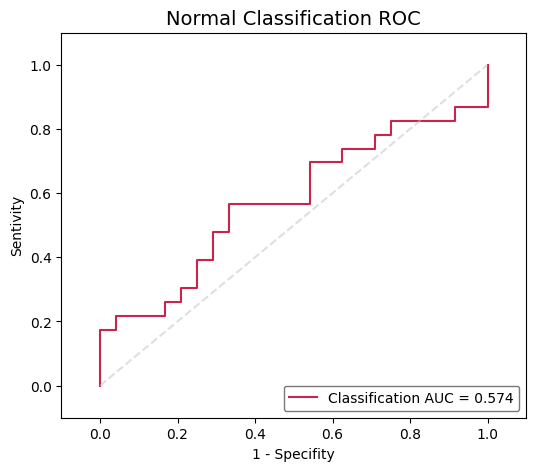

Val_AUC: 0.5742753623188406 Val_ACC: 0.5957446808510638 Val_SEN: 0.5217391304347826 Val_SPE: 0.6666666666666666 Val_PRE: 0.6
[epoch 2] train_loss: 0.634  train_accuracy: 0.644
Val_AUC: 0.568840579710145 Val_ACC: 0.6170212765957447 Val_SEN: 0.21739130434782608 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 3] train_loss: 0.599  train_accuracy: 0.718


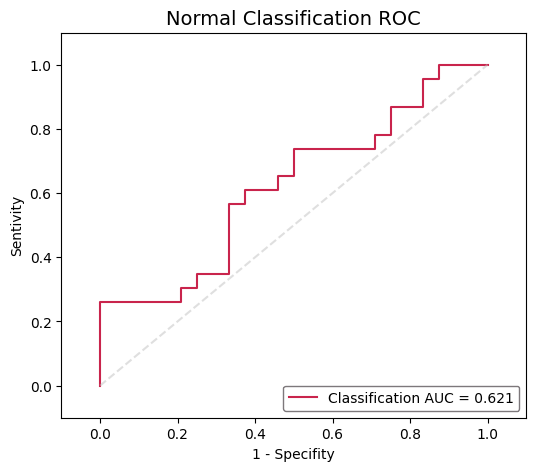

Val_AUC: 0.6213768115942029 Val_ACC: 0.6170212765957447 Val_SEN: 0.21739130434782608 Val_SPE: 1.0 Val_PRE: 1.0
[epoch 4] train_loss: 0.556  train_accuracy: 0.734


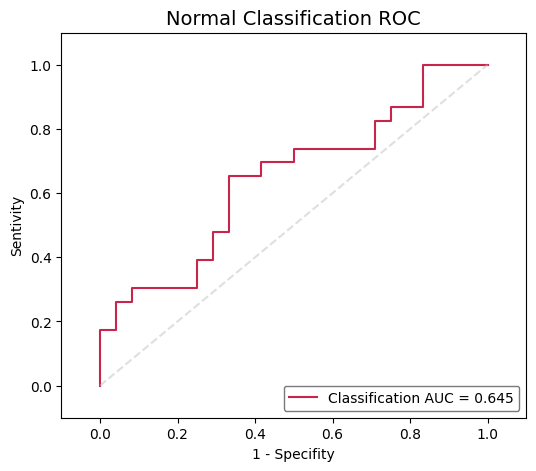

Val_AUC: 0.644927536231884 Val_ACC: 0.6382978723404256 Val_SEN: 0.6086956521739131 Val_SPE: 0.6666666666666666 Val_PRE: 0.6363636363636364
[epoch 5] train_loss: 0.554  train_accuracy: 0.723


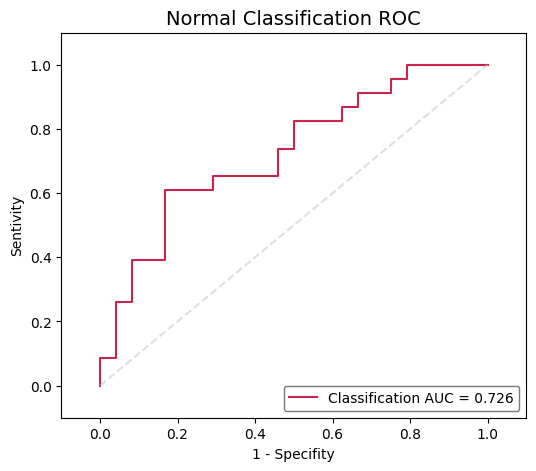

Val_AUC: 0.7264492753623188 Val_ACC: 0.7021276595744681 Val_SEN: 0.5652173913043478 Val_SPE: 0.8333333333333334 Val_PRE: 0.7647058823529411
[epoch 6] train_loss: 0.519  train_accuracy: 0.782


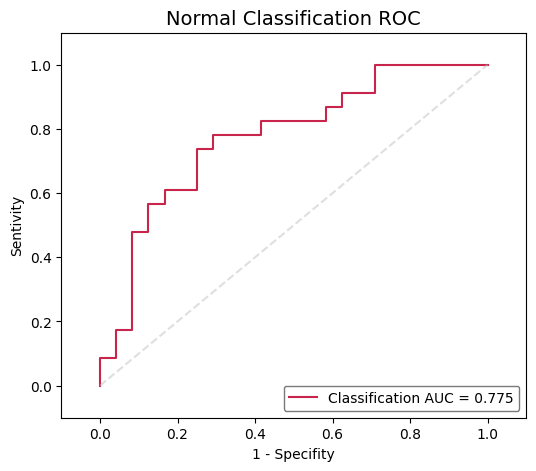

Val_AUC: 0.7753623188405797 Val_ACC: 0.723404255319149 Val_SEN: 0.7391304347826086 Val_SPE: 0.7083333333333334 Val_PRE: 0.7083333333333334
[epoch 7] train_loss: 0.524  train_accuracy: 0.793


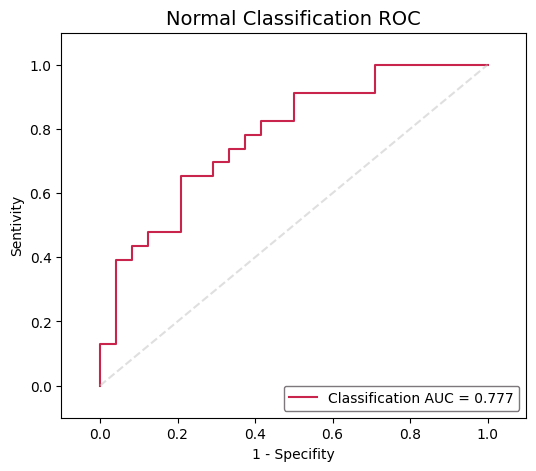

Val_AUC: 0.7771739130434783 Val_ACC: 0.7021276595744681 Val_SEN: 0.6086956521739131 Val_SPE: 0.7916666666666666 Val_PRE: 0.7368421052631579
[epoch 8] train_loss: 0.509  train_accuracy: 0.782
Val_AUC: 0.7735507246376812 Val_ACC: 0.723404255319149 Val_SEN: 0.7391304347826086 Val_SPE: 0.7083333333333334 Val_PRE: 0.7083333333333334
[epoch 9] train_loss: 0.514  train_accuracy: 0.798


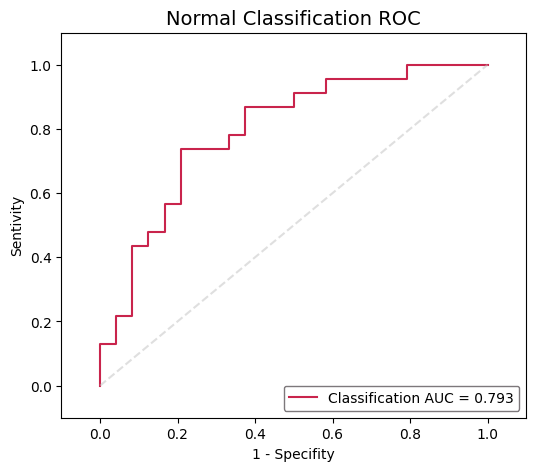

Val_AUC: 0.7934782608695652 Val_ACC: 0.7446808510638298 Val_SEN: 0.6956521739130435 Val_SPE: 0.7916666666666666 Val_PRE: 0.7619047619047619
[epoch 10] train_loss: 0.475  train_accuracy: 0.851
Val_AUC: 0.7844202898550724 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 11] train_loss: 0.474  train_accuracy: 0.846


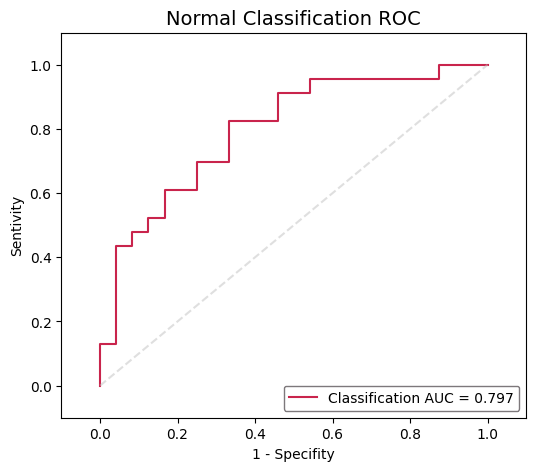

Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 12] train_loss: 0.486  train_accuracy: 0.819


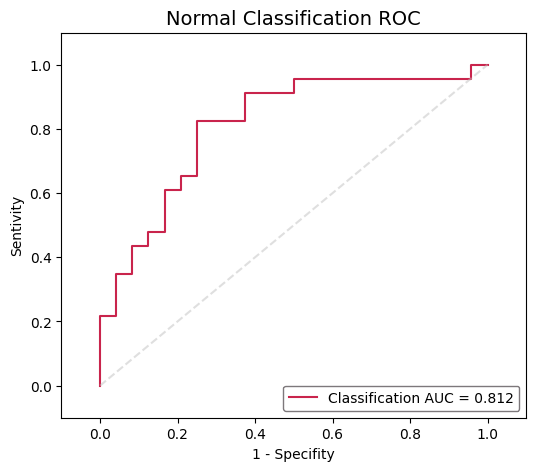

Val_AUC: 0.8115942028985508 Val_ACC: 0.7659574468085106 Val_SEN: 0.782608695652174 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 13] train_loss: 0.476  train_accuracy: 0.830


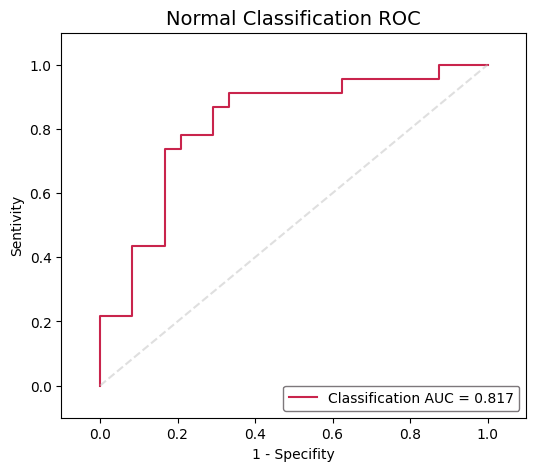

Val_AUC: 0.8170289855072463 Val_ACC: 0.7659574468085106 Val_SEN: 0.8695652173913043 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 14] train_loss: 0.449  train_accuracy: 0.878
Val_AUC: 0.7735507246376812 Val_ACC: 0.7659574468085106 Val_SEN: 0.8695652173913043 Val_SPE: 0.6666666666666666 Val_PRE: 0.7142857142857143
[epoch 15] train_loss: 0.462  train_accuracy: 0.840
Val_AUC: 0.7427536231884058 Val_ACC: 0.7021276595744681 Val_SEN: 0.782608695652174 Val_SPE: 0.625 Val_PRE: 0.6666666666666666
[epoch 16] train_loss: 0.484  train_accuracy: 0.830
Val_AUC: 0.75 Val_ACC: 0.6808510638297872 Val_SEN: 0.7391304347826086 Val_SPE: 0.625 Val_PRE: 0.6538461538461539
[epoch 17] train_loss: 0.436  train_accuracy: 0.878
Val_AUC: 0.7445652173913044 Val_ACC: 0.6808510638297872 Val_SEN: 0.782608695652174 Val_SPE: 0.5833333333333334 Val_PRE: 0.6428571428571429
[epoch 18] train_loss: 0.428  train_accuracy: 0.883
Val_AUC: 0.7536231884057971 Val_ACC: 0.7021276595744681 Val_SEN: 0.826086956521739

[epoch 57] train_loss: 0.414  train_accuracy: 0.920
Val_AUC: 0.7753623188405797 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 58] train_loss: 0.423  train_accuracy: 0.883
Val_AUC: 0.7735507246376812 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 59] train_loss: 0.425  train_accuracy: 0.878
Val_AUC: 0.769927536231884 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 60] train_loss: 0.415  train_accuracy: 0.894
Val_AUC: 0.7717391304347826 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 61] train_loss: 0.406  train_accuracy: 0.888
Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 62] train_loss: 0.409  train_accuracy: 0.920
Val_AUC

Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 101] train_loss: 0.434  train_accuracy: 0.872
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 102] train_loss: 0.383  train_accuracy: 0.947
Val_AUC: 0.7681159420289856 Val_ACC: 0.7021276595744681 Val_SEN: 0.8695652173913043 Val_SPE: 0.5416666666666666 Val_PRE: 0.6451612903225806
[epoch 103] train_loss: 0.406  train_accuracy: 0.899
Val_AUC: 0.769927536231884 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 104] train_loss: 0.403  train_accuracy: 0.920
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.7391304347826086 Val_SPE: 0.7083333333333334 Val_PRE: 0.7083333333333334
[epoch 105] train_loss: 0.412  train_accuracy: 0.894
Val_AUC: 0.7681159420289856 Val_ACC: 0.72

Val_AUC: 0.7608695652173914 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 144] train_loss: 0.449  train_accuracy: 0.862
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 145] train_loss: 0.403  train_accuracy: 0.894
Val_AUC: 0.7626811594202898 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 146] train_loss: 0.416  train_accuracy: 0.883
Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 147] train_loss: 0.429  train_accuracy: 0.862
Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.8695652173913043 Val_SPE: 0.5833333333333334 Val_PRE: 0.6666666666666666
[epoch 148] train_loss: 0.399  train_accuracy: 0.915
Val_AUC: 0.7717391304347826 Val_ACC: 0.7

Val_AUC: 0.7717391304347826 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 187] train_loss: 0.415  train_accuracy: 0.888
Val_AUC: 0.7789855072463768 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 188] train_loss: 0.402  train_accuracy: 0.915
Val_AUC: 0.7717391304347826 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 189] train_loss: 0.426  train_accuracy: 0.878
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 190] train_loss: 0.396  train_accuracy: 0.910
Val_AUC: 0.7663043478260869 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 191] train_loss: 0.416  train_accuracy: 0.888
Val_AUC: 0.7681159420289855 Val_ACC: 0.72340425531914

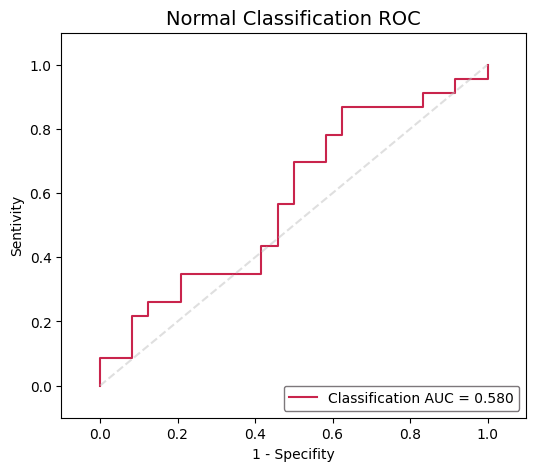

Val_AUC: 0.5797101449275361 Val_ACC: 0.5957446808510638 Val_SEN: 0.8260869565217391 Val_SPE: 0.375 Val_PRE: 0.5588235294117647
[epoch 2] train_loss: 0.619  train_accuracy: 0.660


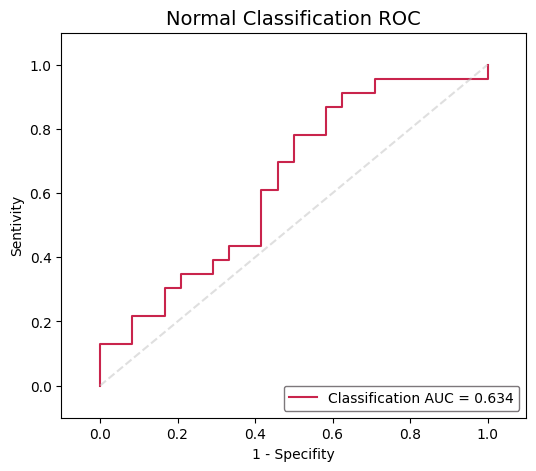

Val_AUC: 0.6340579710144927 Val_ACC: 0.6170212765957447 Val_SEN: 0.8695652173913043 Val_SPE: 0.375 Val_PRE: 0.5714285714285714
[epoch 3] train_loss: 0.624  train_accuracy: 0.665


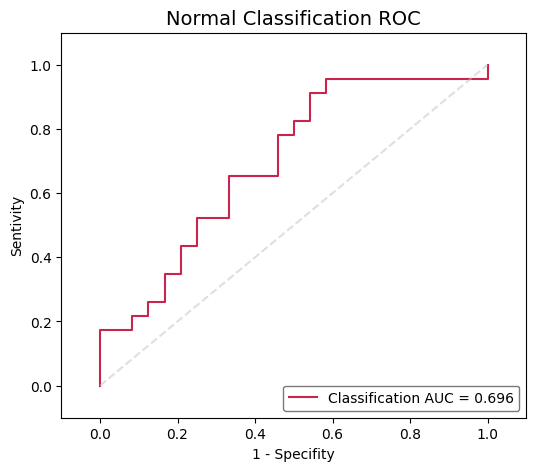

Val_AUC: 0.6956521739130435 Val_ACC: 0.6595744680851063 Val_SEN: 0.9130434782608695 Val_SPE: 0.4166666666666667 Val_PRE: 0.6
[epoch 4] train_loss: 0.590  train_accuracy: 0.713


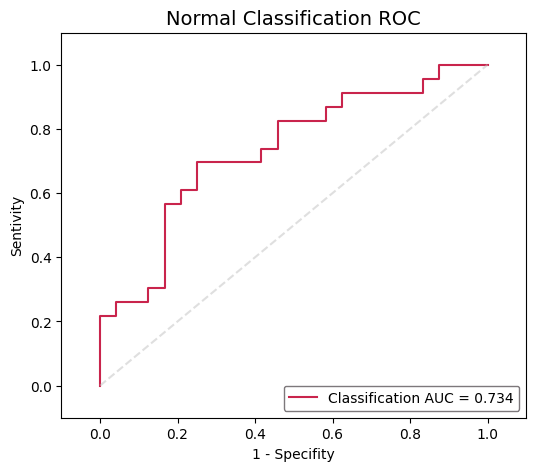

Val_AUC: 0.733695652173913 Val_ACC: 0.7021276595744681 Val_SEN: 0.6521739130434783 Val_SPE: 0.75 Val_PRE: 0.7142857142857143
[epoch 5] train_loss: 0.570  train_accuracy: 0.723
Val_AUC: 0.7192028985507246 Val_ACC: 0.7021276595744681 Val_SEN: 0.6086956521739131 Val_SPE: 0.7916666666666666 Val_PRE: 0.7368421052631579
[epoch 6] train_loss: 0.550  train_accuracy: 0.734


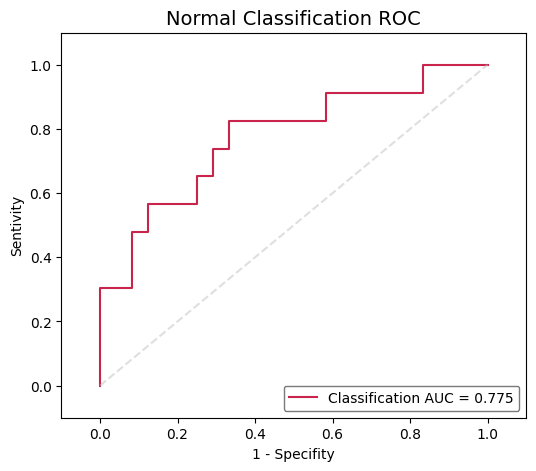

Val_AUC: 0.7753623188405797 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 7] train_loss: 0.526  train_accuracy: 0.798
Val_AUC: 0.7699275362318841 Val_ACC: 0.7446808510638298 Val_SEN: 0.782608695652174 Val_SPE: 0.7083333333333334 Val_PRE: 0.72
[epoch 8] train_loss: 0.543  train_accuracy: 0.723


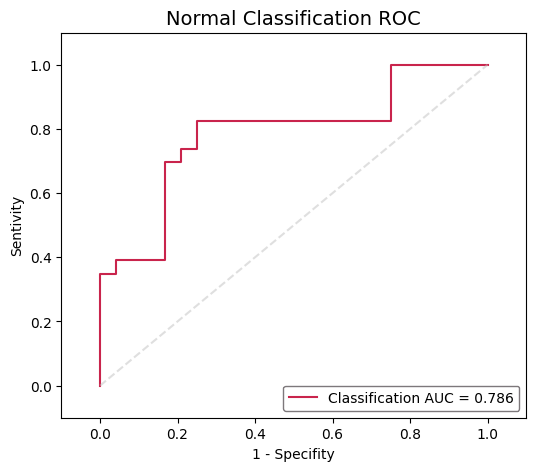

Val_AUC: 0.786231884057971 Val_ACC: 0.7659574468085106 Val_SEN: 0.782608695652174 Val_SPE: 0.75 Val_PRE: 0.75
[epoch 9] train_loss: 0.516  train_accuracy: 0.782
Val_AUC: 0.7735507246376812 Val_ACC: 0.723404255319149 Val_SEN: 0.6956521739130435 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 10] train_loss: 0.525  train_accuracy: 0.755
Val_AUC: 0.7644927536231885 Val_ACC: 0.723404255319149 Val_SEN: 0.6521739130434783 Val_SPE: 0.7916666666666666 Val_PRE: 0.75
[epoch 11] train_loss: 0.482  train_accuracy: 0.851
Val_AUC: 0.7554347826086956 Val_ACC: 0.6808510638297872 Val_SEN: 0.7391304347826086 Val_SPE: 0.625 Val_PRE: 0.6538461538461539
[epoch 12] train_loss: 0.487  train_accuracy: 0.819
Val_AUC: 0.7626811594202898 Val_ACC: 0.723404255319149 Val_SEN: 0.6956521739130435 Val_SPE: 0.75 Val_PRE: 0.7272727272727273
[epoch 13] train_loss: 0.461  train_accuracy: 0.846
Val_AUC: 0.7753623188405797 Val_ACC: 0.7021276595744681 Val_SEN: 0.7391304347826086 Val_SPE: 0.6666666666666666 Val_PRE: 0.68
[ep

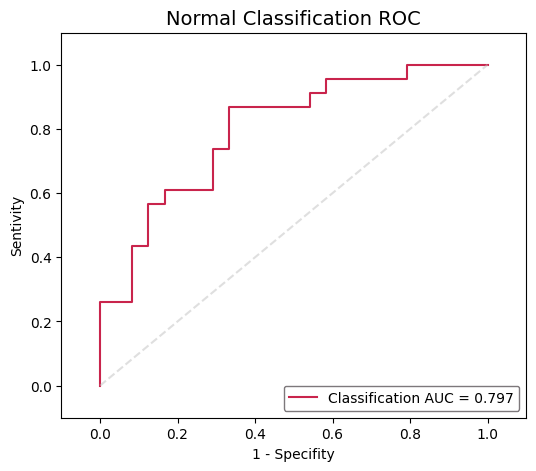

Val_AUC: 0.7971014492753623 Val_ACC: 0.7446808510638298 Val_SEN: 0.8260869565217391 Val_SPE: 0.6666666666666666 Val_PRE: 0.7037037037037037
[epoch 21] train_loss: 0.448  train_accuracy: 0.867
Val_AUC: 0.7844202898550724 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 22] train_loss: 0.425  train_accuracy: 0.878
Val_AUC: 0.786231884057971 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 23] train_loss: 0.420  train_accuracy: 0.894
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.7391304347826086 Val_SPE: 0.7083333333333334 Val_PRE: 0.7083333333333334
[epoch 24] train_loss: 0.427  train_accuracy: 0.878
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 25] train_loss: 0.429  train_accuracy: 0.867
Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255

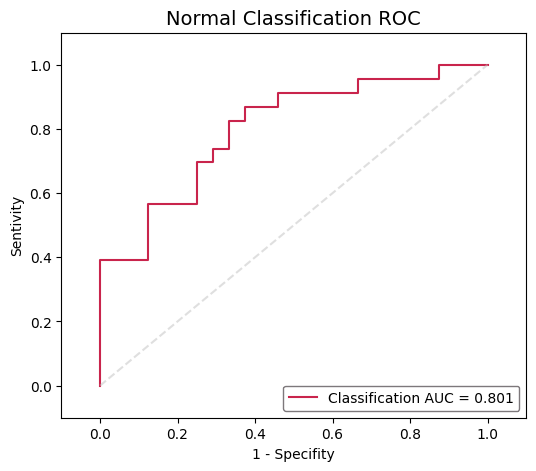

Val_AUC: 0.8007246376811594 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 32] train_loss: 0.436  train_accuracy: 0.878


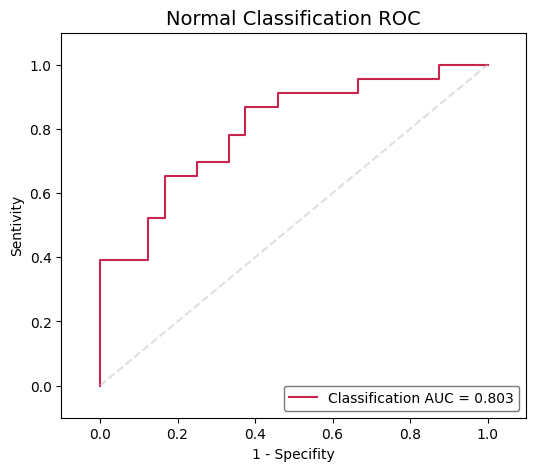

Val_AUC: 0.802536231884058 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 33] train_loss: 0.398  train_accuracy: 0.910
Val_AUC: 0.798913043478261 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 34] train_loss: 0.420  train_accuracy: 0.878
Val_AUC: 0.7934782608695652 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 35] train_loss: 0.436  train_accuracy: 0.867
Val_AUC: 0.7898550724637681 Val_ACC: 0.723404255319149 Val_SEN: 0.6521739130434783 Val_SPE: 0.7916666666666666 Val_PRE: 0.75
[epoch 36] train_loss: 0.420  train_accuracy: 0.904
Val_AUC: 0.7971014492753623 Val_ACC: 0.7021276595744681 Val_SEN: 0.8260869565217391 Val_SPE: 0.5833333333333334 Val_PRE: 0.6551724137931034
[epoch 37] train_loss: 0.412  train_accuracy: 0.883
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 V

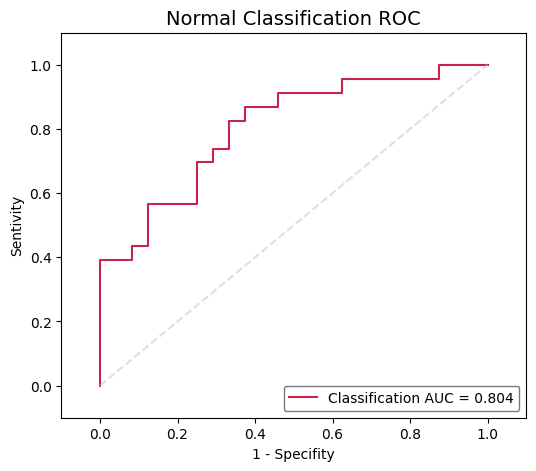

Val_AUC: 0.8043478260869565 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 39] train_loss: 0.425  train_accuracy: 0.883
Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 40] train_loss: 0.417  train_accuracy: 0.899
Val_AUC: 0.8007246376811594 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 41] train_loss: 0.439  train_accuracy: 0.888
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 42] train_loss: 0.402  train_accuracy: 0.915
Val_AUC: 0.798913043478261 Val_ACC: 0.723404255319149 Val_SEN: 0.6086956521739131 Val_SPE: 0.8333333333333334 Val_PRE: 0.7777777777777778
[epoch 43] train_loss: 0.404  train_accuracy: 0.894
Val_AUC: 0.7898550724637681 Val_ACC: 0.7021276595744681 Val_SEN: 0.8695652173913043 Val_SPE: 0.541

[epoch 84] train_loss: 0.402  train_accuracy: 0.931
Val_AUC: 0.7989130434782609 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 85] train_loss: 0.408  train_accuracy: 0.899
Val_AUC: 0.7989130434782609 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 86] train_loss: 0.412  train_accuracy: 0.899
Val_AUC: 0.7934782608695652 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 87] train_loss: 0.401  train_accuracy: 0.920
Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 88] train_loss: 0.428  train_accuracy: 0.894
Val_AUC: 0.8007246376811594 Val_ACC: 0.723404255319149 Val_SEN: 0.782608695652174 Val_SPE: 0.6666666666666666 Val_PRE: 0.6923076923076923
[epoch 89] train_loss: 0.422  train_accuracy: 0.88

[epoch 129] train_loss: 0.409  train_accuracy: 0.894
Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 130] train_loss: 0.406  train_accuracy: 0.920
Val_AUC: 0.7934782608695652 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 131] train_loss: 0.415  train_accuracy: 0.883
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 132] train_loss: 0.409  train_accuracy: 0.910
Val_AUC: 0.8007246376811594 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 133] train_loss: 0.419  train_accuracy: 0.894
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 134] train_loss: 0.413  train_accuracy: 0.883
Val_AUC: 0.7952898550724639 Val_ACC: 0.7234042553191

[epoch 174] train_loss: 0.418  train_accuracy: 0.894
Val_AUC: 0.7880434782608696 Val_ACC: 0.7021276595744681 Val_SEN: 0.782608695652174 Val_SPE: 0.625 Val_PRE: 0.6666666666666666
[epoch 175] train_loss: 0.405  train_accuracy: 0.899
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 176] train_loss: 0.405  train_accuracy: 0.910
Val_AUC: 0.7934782608695652 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 177] train_loss: 0.425  train_accuracy: 0.883
Val_AUC: 0.7952898550724637 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 178] train_loss: 0.419  train_accuracy: 0.888
Val_AUC: 0.7971014492753623 Val_ACC: 0.723404255319149 Val_SEN: 0.8260869565217391 Val_SPE: 0.625 Val_PRE: 0.6785714285714286
[epoch 179] train_loss: 0.419  train_accuracy: 0.904
Val_AUC: 0.7952898550724637 Val_ACC: 0.7234042553191

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200

fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    #输入
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset =DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    best_AUC = 0.0
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_sen,CM_spe,CM_pre = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
        print('Val_AUC: {} Val_ACC: {} Val_SEN: {} Val_SPE: {} Val_PRE: {}'.format(CM_auc,CM_acc,CM_sen,CM_spe,CM_pre))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_,_,_ = calculate_metrics(val_pre_labels, predict_scores, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} Sen: {CM_sen} Spe: {CM_spe} Pre: {CM_pre}\n')
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

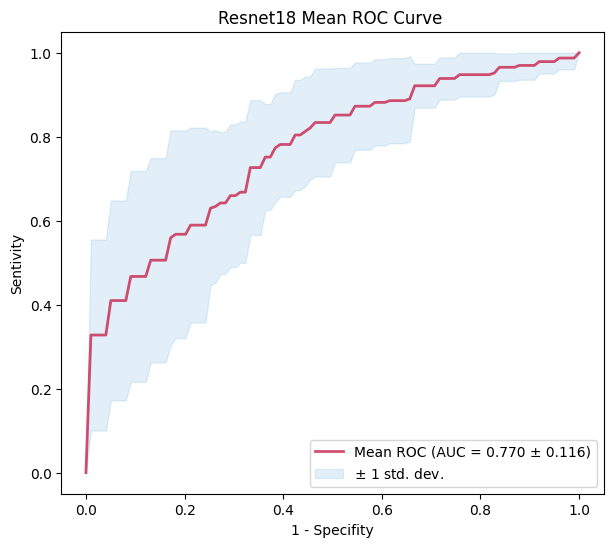

ROC curves saved successfully.


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)



fig, ax = plt.subplots(figsize=(7, 6))

tprs = []
aucs = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#6EB1DE",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Resnet18 Mean ROC Curve ",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/inter_roc_fold1.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
accuracies = []
specificities = []
sensitivities = []
precisions = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    accuracy = (score_three.round() == label_three).mean()
    tn, fp, fn, tp = confusion_matrix(label_three, score_three.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)

    accuracies.append(accuracy)
    specificities.append(specificity)
    sensitivities.append(sensitivity)
    precisions.append(precision)
    aucs.append(three_auc)

mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)
mean_sensitivity = np.mean(sensitivities)
std_sensitivity = np.std(sensitivities)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

results = {
    "Mean AUC": [mean_auc],
    "AUC Std": [std_auc],
    "Mean Accuracy": [mean_accuracy], 
    "Accuracy Std": [std_accuracy],
    "Mean Specificity": [mean_specificity],
    "Specificity Std": [std_specificity],
    "Mean Sensitivity": [mean_sensitivity],
    "Sensitivity Std": [std_sensitivity],
    "Mean Precision": [mean_precision],
    "Precision Std": [std_precision]
}

results_df = pd.DataFrame(results, index=["result"])
results_df.to_csv('/home/uii/loraya/DDR_carat/res_18_hui_good_good/Cross_valiation_fold/abnormal_results.csv')

# hui_lung_lung

In [26]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, lung_mask, lung_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [27]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_hui_lung_lung/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_hui_lung_lung/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.662  train_accuracy: 0.512
Val_AUC: 0.44897959183673464 Val_ACC: 0.42857142857142855
[epoch 2] train_loss: 0.638  train_accuracy: 0.671
Val_AUC: 0.5 Val_ACC: 0.5238095238095238
[epoch 3] train_loss: 0.655  train_accuracy: 0.610
Val_AUC: 0.5408163265306123 Val_ACC: 0.5714285714285714
[epoch 4] train_loss: 0.597  train_accuracy: 0.695
Val_AUC: 0.5714285714285714 Val_ACC: 0.6190476190476191
[epoch 5] train_loss: 0.556  train_accuracy: 0.793
Val_AUC: 0.6122448979591837 Val_ACC: 0.6190476190476191
[epoch 6] train_loss: 0.520  train_accuracy: 0.768
Val_AUC: 0.6224489795918368 Val_ACC: 0.5714285714285714
[epoch 7] train_loss: 0.504  train_accuracy: 0.793
Val_AUC: 0.5918367346938775 Val_ACC: 0.5714285714285714
[epoch 8] train_loss: 0.476  train_accuracy: 0.866
Val_AUC: 0.6326530612244898 Val_ACC: 0.6190476190476191
[epoch 9] train_loss: 0.467  train_accuracy: 0.890
Val_AUC: 0.69387

Val_AUC: 0.7142857142857144 Val_ACC: 0.7619047619047619
[epoch 77] train_loss: 0.411  train_accuracy: 0.915
Val_AUC: 0.7244897959183674 Val_ACC: 0.7619047619047619
[epoch 78] train_loss: 0.383  train_accuracy: 0.939
Val_AUC: 0.7142857142857144 Val_ACC: 0.7619047619047619
[epoch 79] train_loss: 0.421  train_accuracy: 0.902
Val_AUC: 0.6836734693877551 Val_ACC: 0.7142857142857143
[epoch 80] train_loss: 0.411  train_accuracy: 0.927
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 81] train_loss: 0.406  train_accuracy: 0.902
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 82] train_loss: 0.435  train_accuracy: 0.878
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 83] train_loss: 0.450  train_accuracy: 0.841
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 84] train_loss: 0.414  train_accuracy: 0.915
Val_AUC: 0.7142857142857144 Val_ACC: 0.7619047619047619
[epoch 85] train_loss: 0.414  train_accuracy: 0.878
Val_AUC: 0.6836734693877551 

[epoch 152] train_loss: 0.390  train_accuracy: 0.951
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 153] train_loss: 0.425  train_accuracy: 0.902
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 154] train_loss: 0.425  train_accuracy: 0.890
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 155] train_loss: 0.398  train_accuracy: 0.927
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 156] train_loss: 0.437  train_accuracy: 0.866
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 157] train_loss: 0.402  train_accuracy: 0.915
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 158] train_loss: 0.391  train_accuracy: 0.939
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 159] train_loss: 0.413  train_accuracy: 0.878
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 160] train_loss: 0.396  train_accuracy: 0.915
Val_AUC: 0.6938775510204083 Val_ACC: 0.7619047619047619
[epoch 161] train_l

Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 28] train_loss: 0.442  train_accuracy: 0.878
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 29] train_loss: 0.447  train_accuracy: 0.890
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 30] train_loss: 0.450  train_accuracy: 0.878
Val_AUC: 0.875 Val_ACC: 0.8095238095238095
[epoch 31] train_loss: 0.444  train_accuracy: 0.878
Val_AUC: 0.875 Val_ACC: 0.8095238095238095
[epoch 32] train_loss: 0.472  train_accuracy: 0.866
Val_AUC: 0.875 Val_ACC: 0.8095238095238095
[epoch 33] train_loss: 0.430  train_accuracy: 0.878
Val_AUC: 0.8846153846153846 Val_ACC: 0.8095238095238095
[epoch 34] train_loss: 0.464  train_accuracy: 0.854
Val_AUC: 0.8653846153846154 Val_ACC: 0.7619047619047619
[epoch 35] train_loss: 0.456  train_accuracy: 0.878
Val_AUC: 0.8557692307692308 Val_ACC: 0.7619047619047619
[epoch 36] train_loss: 0.428  train_accuracy: 0.878
Val_AUC: 0.8557692307692308 Val_ACC: 0.7619047619047619
[epoch 37] train_loss: 0.443  train_a

[epoch 105] train_loss: 0.427  train_accuracy: 0.890
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 106] train_loss: 0.441  train_accuracy: 0.902
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 107] train_loss: 0.456  train_accuracy: 0.878
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 108] train_loss: 0.464  train_accuracy: 0.878
Val_AUC: 0.8461538461538461 Val_ACC: 0.7619047619047619
[epoch 109] train_loss: 0.460  train_accuracy: 0.866
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 110] train_loss: 0.442  train_accuracy: 0.878
Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 111] train_loss: 0.414  train_accuracy: 0.890
Val_AUC: 0.8557692307692308 Val_ACC: 0.7619047619047619
[epoch 112] train_loss: 0.445  train_accuracy: 0.841
Val_AUC: 0.8461538461538463 Val_ACC: 0.7619047619047619
[epoch 113] train_loss: 0.454  train_accuracy: 0.866
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 114] train_l

[epoch 181] train_loss: 0.474  train_accuracy: 0.841
Val_AUC: 0.8557692307692308 Val_ACC: 0.7619047619047619
[epoch 182] train_loss: 0.436  train_accuracy: 0.902
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 183] train_loss: 0.424  train_accuracy: 0.902
Val_AUC: 0.8461538461538461 Val_ACC: 0.7619047619047619
[epoch 184] train_loss: 0.420  train_accuracy: 0.902
Val_AUC: 0.8461538461538463 Val_ACC: 0.7619047619047619
[epoch 185] train_loss: 0.418  train_accuracy: 0.890
Val_AUC: 0.8461538461538463 Val_ACC: 0.7619047619047619
[epoch 186] train_loss: 0.470  train_accuracy: 0.878
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 187] train_loss: 0.429  train_accuracy: 0.915
Val_AUC: 0.8365384615384616 Val_ACC: 0.7619047619047619
[epoch 188] train_loss: 0.431  train_accuracy: 0.890
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 189] train_loss: 0.435  train_accuracy: 0.902
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 190] train_loss: 0.466  t

Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 57] train_loss: 0.389  train_accuracy: 0.951
Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 58] train_loss: 0.405  train_accuracy: 0.927
Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 59] train_loss: 0.404  train_accuracy: 0.927
Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 60] train_loss: 0.413  train_accuracy: 0.927
Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 61] train_loss: 0.395  train_accuracy: 0.927
Val_AUC: 0.8269230769230769 Val_ACC: 0.8095238095238095
[epoch 62] train_loss: 0.416  train_accuracy: 0.927
Val_AUC: 0.8173076923076923 Val_ACC: 0.8095238095238095
[epoch 63] train_loss: 0.362  train_accuracy: 0.976
Val_AUC: 0.8076923076923077 Val_ACC: 0.8095238095238095
[epoch 64] train_loss: 0.415  train_accuracy: 0.902
Val_AUC: 0.8076923076923077 Val_ACC: 0.7619047619047619
[epoch 65] train_loss: 0.394  train_accuracy: 0.951
Val_AUC: 0.8076923076923077 

Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 133] train_loss: 0.441  train_accuracy: 0.841
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 134] train_loss: 0.408  train_accuracy: 0.915
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 135] train_loss: 0.403  train_accuracy: 0.939
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 136] train_loss: 0.403  train_accuracy: 0.915
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 137] train_loss: 0.387  train_accuracy: 0.951
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 138] train_loss: 0.392  train_accuracy: 0.951
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 139] train_loss: 0.432  train_accuracy: 0.878
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 140] train_loss: 0.395  train_accuracy: 0.939
Val_AUC: 0.8076923076923077 Val_ACC: 0.8095238095238095
[epoch 141] train_loss: 0.398  train_accuracy: 0.939
Val_AUC: 0.80769230

[epoch 8] train_loss: 0.521  train_accuracy: 0.807
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 9] train_loss: 0.555  train_accuracy: 0.747
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 10] train_loss: 0.547  train_accuracy: 0.711
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 11] train_loss: 0.493  train_accuracy: 0.807
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 12] train_loss: 0.454  train_accuracy: 0.867
Val_AUC: 0.7252747252747254 Val_ACC: 0.6
[epoch 13] train_loss: 0.426  train_accuracy: 0.892
Val_AUC: 0.7252747252747253 Val_ACC: 0.6
[epoch 14] train_loss: 0.468  train_accuracy: 0.867
Val_AUC: 0.7802197802197802 Val_ACC: 0.7
[epoch 15] train_loss: 0.465  train_accuracy: 0.855
Val_AUC: 0.7692307692307692 Val_ACC: 0.65
[epoch 16] train_loss: 0.465  train_accuracy: 0.867
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 17] train_loss: 0.453  train_accuracy: 0.880
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 18] train_loss: 0.428  train_accuracy: 0.880
Val_AUC: 0.736263

Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 96] train_loss: 0.457  train_accuracy: 0.855
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 97] train_loss: 0.428  train_accuracy: 0.916
Val_AUC: 0.7802197802197801 Val_ACC: 0.7
[epoch 98] train_loss: 0.419  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 99] train_loss: 0.369  train_accuracy: 0.988
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 100] train_loss: 0.419  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 101] train_loss: 0.406  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 102] train_loss: 0.420  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 103] train_loss: 0.416  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 104] train_loss: 0.437  train_accuracy: 0.880
Val_AUC: 0.7472527472527473 Val_ACC: 0.65
[epoch 105] train_loss: 0.442  train_accuracy: 0.880
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 106] trai

Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 183] train_loss: 0.393  train_accuracy: 0.952
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 184] train_loss: 0.410  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 185] train_loss: 0.429  train_accuracy: 0.880
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 186] train_loss: 0.440  train_accuracy: 0.892
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 187] train_loss: 0.441  train_accuracy: 0.867
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 188] train_loss: 0.394  train_accuracy: 0.940
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 189] train_loss: 0.449  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 190] train_loss: 0.422  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 191] train_loss: 0.460  train_accuracy: 0.843
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 192] train_loss: 0.413  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.65
[epoch 1

Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 70] train_loss: 0.438  train_accuracy: 0.867
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 71] train_loss: 0.410  train_accuracy: 0.928
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 72] train_loss: 0.421  train_accuracy: 0.892
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 73] train_loss: 0.413  train_accuracy: 0.928
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 74] train_loss: 0.458  train_accuracy: 0.855
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 75] train_loss: 0.402  train_accuracy: 0.928
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 76] train_loss: 0.443  train_accuracy: 0.880
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 77] train_loss: 0.419  train_accuracy: 0.904
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 78] train_loss: 0.417  train_accuracy: 0.892
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 79] train_loss: 0.397  train_accuracy: 0.940
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 80] train_loss: 0.378 

Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 158] train_loss: 0.411  train_accuracy: 0.916
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 159] train_loss: 0.397  train_accuracy: 0.940
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 160] train_loss: 0.404  train_accuracy: 0.916
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 161] train_loss: 0.400  train_accuracy: 0.916
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 162] train_loss: 0.436  train_accuracy: 0.892
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 163] train_loss: 0.383  train_accuracy: 0.940
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 164] train_loss: 0.407  train_accuracy: 0.892
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 165] train_loss: 0.427  train_accuracy: 0.928
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 166] train_loss: 0.416  train_accuracy: 0.916
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 167] train_loss: 0.375  train_accuracy: 0.976
Val_AUC: 0.6483516483516483 Val_ACC: 0.7
[epoch 168] train_l

# good_lung_lung

In [28]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([good_mask, lung_mask, lung_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [29]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_lung_lung_good/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_lung_lung_good/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.644  train_accuracy: 0.610
Val_AUC: 0.806122448979592 Val_ACC: 0.7142857142857143
[epoch 2] train_loss: 0.628  train_accuracy: 0.695
Val_AUC: 0.7346938775510204 Val_ACC: 0.6666666666666666
[epoch 3] train_loss: 0.646  train_accuracy: 0.646
Val_AUC: 0.7346938775510203 Val_ACC: 0.6666666666666666
[epoch 4] train_loss: 0.587  train_accuracy: 0.695
Val_AUC: 0.7142857142857143 Val_ACC: 0.6190476190476191
[epoch 5] train_loss: 0.527  train_accuracy: 0.756
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 6] train_loss: 0.497  train_accuracy: 0.793
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 7] train_loss: 0.513  train_accuracy: 0.817
Val_AUC: 0.7142857142857142 Val_ACC: 0.7142857142857143
[epoch 8] train_loss: 0.510  train_accuracy: 0.793
Val_AUC: 0.7040816326530612 Val_ACC: 0.6666666666666666
[epoch 9] train_loss: 0.473  train_accuracy: 0.793
Val_

Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 77] train_loss: 0.432  train_accuracy: 0.890
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 78] train_loss: 0.400  train_accuracy: 0.902
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 79] train_loss: 0.425  train_accuracy: 0.890
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 80] train_loss: 0.410  train_accuracy: 0.915
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 81] train_loss: 0.422  train_accuracy: 0.866
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 82] train_loss: 0.463  train_accuracy: 0.866
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 83] train_loss: 0.432  train_accuracy: 0.902
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 84] train_loss: 0.427  train_accuracy: 0.890
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 85] train_loss: 0.443  train_accuracy: 0.854
Val_AUC: 0.693877551020408 Val_ACC: 0

Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 153] train_loss: 0.438  train_accuracy: 0.902
Val_AUC: 0.7040816326530612 Val_ACC: 0.7142857142857143
[epoch 154] train_loss: 0.462  train_accuracy: 0.866
Val_AUC: 0.7040816326530612 Val_ACC: 0.7142857142857143
[epoch 155] train_loss: 0.403  train_accuracy: 0.915
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 156] train_loss: 0.427  train_accuracy: 0.890
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 157] train_loss: 0.426  train_accuracy: 0.878
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 158] train_loss: 0.431  train_accuracy: 0.902
Val_AUC: 0.7040816326530612 Val_ACC: 0.7142857142857143
[epoch 159] train_loss: 0.392  train_accuracy: 0.915
Val_AUC: 0.693877551020408 Val_ACC: 0.7142857142857143
[epoch 160] train_loss: 0.430  train_accuracy: 0.878
Val_AUC: 0.7040816326530612 Val_ACC: 0.7142857142857143
[epoch 161] train_loss: 0.403  train_accuracy: 0.951
Val_AUC: 0.6938775510204

[epoch 28] train_loss: 0.475  train_accuracy: 0.854
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 29] train_loss: 0.433  train_accuracy: 0.890
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 30] train_loss: 0.459  train_accuracy: 0.841
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 31] train_loss: 0.471  train_accuracy: 0.841
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 32] train_loss: 0.475  train_accuracy: 0.829
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 33] train_loss: 0.462  train_accuracy: 0.854
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 34] train_loss: 0.476  train_accuracy: 0.829
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 35] train_loss: 0.454  train_accuracy: 0.878
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 36] train_loss: 0.452  train_accuracy: 0.854
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 37] train_loss: 0.444

[epoch 104] train_loss: 0.458  train_accuracy: 0.878
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 105] train_loss: 0.428  train_accuracy: 0.890
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 106] train_loss: 0.441  train_accuracy: 0.878
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 107] train_loss: 0.458  train_accuracy: 0.829
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 108] train_loss: 0.418  train_accuracy: 0.878
Val_AUC: 0.7115384615384615 Val_ACC: 0.6666666666666666
[epoch 109] train_loss: 0.490  train_accuracy: 0.793
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 110] train_loss: 0.429  train_accuracy: 0.902
Val_AUC: 0.7211538461538461 Val_ACC: 0.6666666666666666
[epoch 111] train_loss: 0.444  train_accuracy: 0.890
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 112] train_loss: 0.425  train_accuracy: 0.902
Val_AUC: 0.7019230769230769 Val_ACC: 0.6666666666666666
[epoch 113] train_l

Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 180] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 181] train_loss: 0.485  train_accuracy: 0.817
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 182] train_loss: 0.415  train_accuracy: 0.927
Val_AUC: 0.6730769230769231 Val_ACC: 0.6666666666666666
[epoch 183] train_loss: 0.447  train_accuracy: 0.878
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 184] train_loss: 0.411  train_accuracy: 0.915
Val_AUC: 0.6826923076923077 Val_ACC: 0.6666666666666666
[epoch 185] train_loss: 0.436  train_accuracy: 0.878
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 186] train_loss: 0.490  train_accuracy: 0.829
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 187] train_loss: 0.447  train_accuracy: 0.890
Val_AUC: 0.6923076923076923 Val_ACC: 0.6666666666666666
[epoch 188] train_loss: 0.451  train_accuracy: 0.866
Val_AUC: 0.69230769

Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 56] train_loss: 0.420  train_accuracy: 0.902
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 57] train_loss: 0.392  train_accuracy: 0.951
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 58] train_loss: 0.414  train_accuracy: 0.927
Val_AUC: 0.8846153846153846 Val_ACC: 0.8571428571428571
[epoch 59] train_loss: 0.443  train_accuracy: 0.878
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 60] train_loss: 0.457  train_accuracy: 0.878
Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 61] train_loss: 0.461  train_accuracy: 0.854
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 62] train_loss: 0.453  train_accuracy: 0.854
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 63] train_loss: 0.399  train_accuracy: 0.915
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 64] train_loss: 0.421  train_accuracy: 0.915
Val_AUC: 0.8557692307692307 

Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 133] train_loss: 0.458  train_accuracy: 0.841
Val_AUC: 0.875 Val_ACC: 0.8571428571428571
[epoch 134] train_loss: 0.459  train_accuracy: 0.854
Val_AUC: 0.875 Val_ACC: 0.8571428571428571
[epoch 135] train_loss: 0.417  train_accuracy: 0.939
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 136] train_loss: 0.434  train_accuracy: 0.878
Val_AUC: 0.875 Val_ACC: 0.8571428571428571
[epoch 137] train_loss: 0.412  train_accuracy: 0.915
Val_AUC: 0.875 Val_ACC: 0.8571428571428571
[epoch 138] train_loss: 0.404  train_accuracy: 0.927
Val_AUC: 0.8846153846153846 Val_ACC: 0.8571428571428571
[epoch 139] train_loss: 0.458  train_accuracy: 0.841
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 140] train_loss: 0.410  train_accuracy: 0.915
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 141] train_loss: 0.427  train_accuracy: 0.902
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 142] tra

[epoch 10] train_loss: 0.546  train_accuracy: 0.759
Val_AUC: 0.6703296703296704 Val_ACC: 0.55
[epoch 11] train_loss: 0.505  train_accuracy: 0.795
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 12] train_loss: 0.458  train_accuracy: 0.867
Val_AUC: 0.6593406593406592 Val_ACC: 0.65
[epoch 13] train_loss: 0.471  train_accuracy: 0.843
Val_AUC: 0.6483516483516483 Val_ACC: 0.65
[epoch 14] train_loss: 0.479  train_accuracy: 0.819
Val_AUC: 0.6593406593406594 Val_ACC: 0.65
[epoch 15] train_loss: 0.442  train_accuracy: 0.880
Val_AUC: 0.6373626373626373 Val_ACC: 0.65
[epoch 16] train_loss: 0.474  train_accuracy: 0.843
Val_AUC: 0.6483516483516483 Val_ACC: 0.65
[epoch 17] train_loss: 0.460  train_accuracy: 0.843
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 18] train_loss: 0.450  train_accuracy: 0.855
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 19] train_loss: 0.458  train_accuracy: 0.880
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 20] train_loss: 0.451  train_accuracy: 0.855
Val_AUC: 0.6

[epoch 98] train_loss: 0.407  train_accuracy: 0.916
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 99] train_loss: 0.401  train_accuracy: 0.928
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 100] train_loss: 0.403  train_accuracy: 0.952
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 101] train_loss: 0.395  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 102] train_loss: 0.421  train_accuracy: 0.904
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 103] train_loss: 0.421  train_accuracy: 0.892
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 104] train_loss: 0.441  train_accuracy: 0.892
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 105] train_loss: 0.440  train_accuracy: 0.867
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 106] train_loss: 0.460  train_accuracy: 0.819
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 107] train_loss: 0.429  train_accuracy: 0.892
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 108] train_loss: 0.430  train_accuracy: 0.880
Val_AUC: 

Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 186] train_loss: 0.422  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 187] train_loss: 0.419  train_accuracy: 0.892
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 188] train_loss: 0.409  train_accuracy: 0.928
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 189] train_loss: 0.472  train_accuracy: 0.855
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 190] train_loss: 0.437  train_accuracy: 0.855
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 191] train_loss: 0.477  train_accuracy: 0.831
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 192] train_loss: 0.416  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 193] train_loss: 0.446  train_accuracy: 0.831
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 194] train_loss: 0.424  train_accuracy: 0.904
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 195] train_loss: 0.393  train_accuracy: 0.940
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 196] train_l

Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 73] train_loss: 0.440  train_accuracy: 0.843
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 74] train_loss: 0.481  train_accuracy: 0.843
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 75] train_loss: 0.434  train_accuracy: 0.892
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 76] train_loss: 0.468  train_accuracy: 0.819
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 77] train_loss: 0.411  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 78] train_loss: 0.414  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 79] train_loss: 0.420  train_accuracy: 0.880
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 80] train_loss: 0.437  train_accuracy: 0.867
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 81] train_loss: 0.437  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 82] train_loss: 0.441  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 83] train_loss: 0.4

Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 160] train_loss: 0.404  train_accuracy: 0.952
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 161] train_loss: 0.440  train_accuracy: 0.855
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 162] train_loss: 0.433  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 163] train_loss: 0.432  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 164] train_loss: 0.386  train_accuracy: 0.952
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 165] train_loss: 0.441  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 166] train_loss: 0.425  train_accuracy: 0.904
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 167] train_loss: 0.412  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 168] train_loss: 0.412  train_accuracy: 0.916
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 169] train_loss: 0.465  train_accuracy: 0.855
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 170

# lung_good_good

In [4]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, dicom_array, good_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [5]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_hui_hui_good/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_hui_hui_good/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.649  train_accuracy: 0.610
Val_AUC: 0.6122448979591837 Val_ACC: 0.6190476190476191
[epoch 2] train_loss: 0.609  train_accuracy: 0.683
Val_AUC: 0.6326530612244898 Val_ACC: 0.7142857142857143
[epoch 3] train_loss: 0.614  train_accuracy: 0.707
Val_AUC: 0.653061224489796 Val_ACC: 0.7142857142857143
[epoch 4] train_loss: 0.545  train_accuracy: 0.756
Val_AUC: 0.6836734693877551 Val_ACC: 0.8095238095238095
[epoch 5] train_loss: 0.502  train_accuracy: 0.805
Val_AUC: 0.6938775510204082 Val_ACC: 0.8095238095238095
[epoch 6] train_loss: 0.470  train_accuracy: 0.854
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 7] train_loss: 0.458  train_accuracy: 0.878
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 8] train_loss: 0.426  train_accuracy: 0.915
Val_AUC: 0.6938775510204082 Val_ACC: 0.7619047619047619
[epoch 9] train_loss: 0.435  train_accuracy: 0.878
Val_

Val_AUC: 0.663265306122449 Val_ACC: 0.7619047619047619
[epoch 77] train_loss: 0.383  train_accuracy: 0.939
Val_AUC: 0.653061224489796 Val_ACC: 0.7619047619047619
[epoch 78] train_loss: 0.368  train_accuracy: 0.951
Val_AUC: 0.663265306122449 Val_ACC: 0.7619047619047619
[epoch 79] train_loss: 0.398  train_accuracy: 0.927
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 80] train_loss: 0.377  train_accuracy: 0.963
Val_AUC: 0.663265306122449 Val_ACC: 0.7619047619047619
[epoch 81] train_loss: 0.368  train_accuracy: 0.927
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 82] train_loss: 0.409  train_accuracy: 0.902
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 83] train_loss: 0.413  train_accuracy: 0.902
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 84] train_loss: 0.387  train_accuracy: 0.915
Val_AUC: 0.663265306122449 Val_ACC: 0.7619047619047619
[epoch 85] train_loss: 0.390  train_accuracy: 0.902
Val_AUC: 0.6734693877551021 Val_A

Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 153] train_loss: 0.389  train_accuracy: 0.927
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 154] train_loss: 0.404  train_accuracy: 0.902
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 155] train_loss: 0.365  train_accuracy: 0.963
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 156] train_loss: 0.389  train_accuracy: 0.927
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 157] train_loss: 0.381  train_accuracy: 0.927
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 158] train_loss: 0.371  train_accuracy: 0.963
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 159] train_loss: 0.364  train_accuracy: 0.939
Val_AUC: 0.6734693877551021 Val_ACC: 0.7619047619047619
[epoch 160] train_loss: 0.368  train_accuracy: 0.951
Val_AUC: 0.6836734693877551 Val_ACC: 0.7619047619047619
[epoch 161] train_loss: 0.380  train_accuracy: 0.951
Val_AUC: 0.68367346

Val_AUC: 0.7884615384615385 Val_ACC: 0.7619047619047619
[epoch 28] train_loss: 0.395  train_accuracy: 0.939
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 29] train_loss: 0.384  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 30] train_loss: 0.428  train_accuracy: 0.890
Val_AUC: 0.7692307692307693 Val_ACC: 0.7142857142857143
[epoch 31] train_loss: 0.412  train_accuracy: 0.902
Val_AUC: 0.7692307692307693 Val_ACC: 0.7142857142857143
[epoch 32] train_loss: 0.401  train_accuracy: 0.927
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 33] train_loss: 0.403  train_accuracy: 0.902
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 34] train_loss: 0.417  train_accuracy: 0.890
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 35] train_loss: 0.394  train_accuracy: 0.927
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 36] train_loss: 0.389  train_accuracy: 0.927
Val_AUC: 0.778846153846154 Val

[epoch 104] train_loss: 0.421  train_accuracy: 0.890
Val_AUC: 0.7788461538461539 Val_ACC: 0.7619047619047619
[epoch 105] train_loss: 0.373  train_accuracy: 0.939
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 106] train_loss: 0.391  train_accuracy: 0.915
Val_AUC: 0.7692307692307693 Val_ACC: 0.7142857142857143
[epoch 107] train_loss: 0.400  train_accuracy: 0.927
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 108] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.7788461538461539 Val_ACC: 0.7619047619047619
[epoch 109] train_loss: 0.417  train_accuracy: 0.890
Val_AUC: 0.7788461538461539 Val_ACC: 0.7619047619047619
[epoch 110] train_loss: 0.393  train_accuracy: 0.927
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 111] train_loss: 0.368  train_accuracy: 0.951
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 112] train_loss: 0.385  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 113] train_lo

Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 180] train_loss: 0.379  train_accuracy: 0.951
Val_AUC: 0.7788461538461539 Val_ACC: 0.7619047619047619
[epoch 181] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 182] train_loss: 0.380  train_accuracy: 0.951
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 183] train_loss: 0.383  train_accuracy: 0.951
Val_AUC: 0.7692307692307693 Val_ACC: 0.7142857142857143
[epoch 184] train_loss: 0.370  train_accuracy: 0.963
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 185] train_loss: 0.378  train_accuracy: 0.927
Val_AUC: 0.778846153846154 Val_ACC: 0.7142857142857143
[epoch 186] train_loss: 0.444  train_accuracy: 0.890
Val_AUC: 0.7884615384615385 Val_ACC: 0.7619047619047619
[epoch 187] train_loss: 0.368  train_accuracy: 0.951
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 188] train_loss: 0.413  train_accuracy: 0.902
Val_AUC: 0.788461538461

[epoch 55] train_loss: 0.402  train_accuracy: 0.915
Val_AUC: 0.9423076923076923 Val_ACC: 0.8571428571428571
[epoch 56] train_loss: 0.372  train_accuracy: 0.976
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 57] train_loss: 0.373  train_accuracy: 0.951
Val_AUC: 0.9230769230769231 Val_ACC: 0.8095238095238095
[epoch 58] train_loss: 0.380  train_accuracy: 0.951
Val_AUC: 0.9423076923076923 Val_ACC: 0.8571428571428571
[epoch 59] train_loss: 0.399  train_accuracy: 0.939
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 60] train_loss: 0.398  train_accuracy: 0.939
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 61] train_loss: 0.392  train_accuracy: 0.927
Val_AUC: 0.9230769230769231 Val_ACC: 0.8095238095238095
[epoch 62] train_loss: 0.423  train_accuracy: 0.890
Val_AUC: 0.9230769230769231 Val_ACC: 0.8095238095238095
[epoch 63] train_loss: 0.378  train_accuracy: 0.951
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 64] train_loss: 0.397

[epoch 131] train_loss: 0.369  train_accuracy: 0.963
Val_AUC: 0.9230769230769231 Val_ACC: 0.8095238095238095
[epoch 132] train_loss: 0.385  train_accuracy: 0.927
Val_AUC: 0.9423076923076923 Val_ACC: 0.8571428571428571
[epoch 133] train_loss: 0.412  train_accuracy: 0.890
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 134] train_loss: 0.375  train_accuracy: 0.951
Val_AUC: 0.9423076923076923 Val_ACC: 0.8571428571428571
[epoch 135] train_loss: 0.389  train_accuracy: 0.951
Val_AUC: 0.9423076923076923 Val_ACC: 0.8571428571428571
[epoch 136] train_loss: 0.383  train_accuracy: 0.963
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 137] train_loss: 0.385  train_accuracy: 0.939
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 138] train_loss: 0.373  train_accuracy: 0.963
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 139] train_loss: 0.416  train_accuracy: 0.866
Val_AUC: 0.9326923076923077 Val_ACC: 0.8095238095238095
[epoch 140] train_l

Val_AUC: 0.6593406593406593 Val_ACC: 0.6
[epoch 7] train_loss: 0.488  train_accuracy: 0.843
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 8] train_loss: 0.466  train_accuracy: 0.880
Val_AUC: 0.6813186813186813 Val_ACC: 0.65
[epoch 9] train_loss: 0.498  train_accuracy: 0.807
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 10] train_loss: 0.495  train_accuracy: 0.795
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 11] train_loss: 0.473  train_accuracy: 0.831
Val_AUC: 0.7252747252747254 Val_ACC: 0.65
[epoch 12] train_loss: 0.403  train_accuracy: 0.916
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 13] train_loss: 0.425  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 14] train_loss: 0.426  train_accuracy: 0.892
Val_AUC: 0.7802197802197803 Val_ACC: 0.75
[epoch 15] train_loss: 0.417  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 16] train_loss: 0.421  train_accuracy: 0.880
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 17] train_loss: 0

[epoch 94] train_loss: 0.399  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 95] train_loss: 0.437  train_accuracy: 0.867
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 96] train_loss: 0.456  train_accuracy: 0.831
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 97] train_loss: 0.397  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 98] train_loss: 0.387  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 99] train_loss: 0.366  train_accuracy: 0.952
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 100] train_loss: 0.377  train_accuracy: 0.940
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 101] train_loss: 0.370  train_accuracy: 0.964
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 102] train_loss: 0.386  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 103] train_loss: 0.389  train_accuracy: 0.940
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 104] train_loss: 0.395  train_accuracy: 0.928
Val

Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 181] train_loss: 0.402  train_accuracy: 0.928
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 182] train_loss: 0.403  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 183] train_loss: 0.372  train_accuracy: 0.964
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 184] train_loss: 0.407  train_accuracy: 0.904
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 185] train_loss: 0.388  train_accuracy: 0.940
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 186] train_loss: 0.396  train_accuracy: 0.916
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 187] train_loss: 0.374  train_accuracy: 0.952
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 188] train_loss: 0.372  train_accuracy: 0.952
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 189] train_loss: 0.405  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 190] train_loss: 0.402  train_accuracy: 0.928
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 1

Val_AUC: 0.6043956043956044 Val_ACC: 0.7
[epoch 68] train_loss: 0.388  train_accuracy: 0.952
Val_AUC: 0.5934065934065933 Val_ACC: 0.7
[epoch 69] train_loss: 0.366  train_accuracy: 0.952
Val_AUC: 0.6043956043956045 Val_ACC: 0.75
[epoch 70] train_loss: 0.416  train_accuracy: 0.880
Val_AUC: 0.6043956043956045 Val_ACC: 0.75
[epoch 71] train_loss: 0.397  train_accuracy: 0.952
Val_AUC: 0.6043956043956045 Val_ACC: 0.7
[epoch 72] train_loss: 0.403  train_accuracy: 0.916
Val_AUC: 0.6043956043956045 Val_ACC: 0.7
[epoch 73] train_loss: 0.402  train_accuracy: 0.904
Val_AUC: 0.6043956043956045 Val_ACC: 0.7
[epoch 74] train_loss: 0.397  train_accuracy: 0.940
Val_AUC: 0.6043956043956045 Val_ACC: 0.7
[epoch 75] train_loss: 0.391  train_accuracy: 0.928
Val_AUC: 0.6043956043956045 Val_ACC: 0.7
[epoch 76] train_loss: 0.424  train_accuracy: 0.904
Val_AUC: 0.6153846153846154 Val_ACC: 0.7
[epoch 77] train_loss: 0.402  train_accuracy: 0.928
Val_AUC: 0.6263736263736264 Val_ACC: 0.75
[epoch 78] train_loss: 0.3

[epoch 155] train_loss: 0.365  train_accuracy: 0.964
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 156] train_loss: 0.382  train_accuracy: 0.940
Val_AUC: 0.6483516483516483 Val_ACC: 0.75
[epoch 157] train_loss: 0.375  train_accuracy: 0.940
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 158] train_loss: 0.385  train_accuracy: 0.940
Val_AUC: 0.6263736263736264 Val_ACC: 0.7
[epoch 159] train_loss: 0.359  train_accuracy: 0.964
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 160] train_loss: 0.375  train_accuracy: 0.964
Val_AUC: 0.6373626373626373 Val_ACC: 0.7
[epoch 161] train_loss: 0.380  train_accuracy: 0.940
Val_AUC: 0.6263736263736264 Val_ACC: 0.7
[epoch 162] train_loss: 0.403  train_accuracy: 0.952
Val_AUC: 0.6153846153846154 Val_ACC: 0.7
[epoch 163] train_loss: 0.362  train_accuracy: 0.952
Val_AUC: 0.6263736263736264 Val_ACC: 0.75
[epoch 164] train_loss: 0.376  train_accuracy: 0.940
Val_AUC: 0.6263736263736264 Val_ACC: 0.75
[epoch 165] train_loss: 0.381  train_accuracy: 0.940
Val_

# good_good_good

In [18]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([good_mask, good_mask, good_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [19]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_all_good/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_all_good/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.644  train_accuracy: 0.659
Val_AUC: 0.673469387755102 Val_ACC: 0.6666666666666666
[epoch 2] train_loss: 0.650  train_accuracy: 0.610
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 3] train_loss: 0.670  train_accuracy: 0.622
Val_AUC: 0.7653061224489797 Val_ACC: 0.7619047619047619
[epoch 4] train_loss: 0.575  train_accuracy: 0.744
Val_AUC: 0.7448979591836735 Val_ACC: 0.8095238095238095
[epoch 5] train_loss: 0.556  train_accuracy: 0.768
Val_AUC: 0.7346938775510203 Val_ACC: 0.8095238095238095
[epoch 6] train_loss: 0.543  train_accuracy: 0.732
Val_AUC: 0.7040816326530612 Val_ACC: 0.7619047619047619
[epoch 7] train_loss: 0.505  train_accuracy: 0.793
Val_AUC: 0.7244897959183674 Val_ACC: 0.7619047619047619
[epoch 8] train_loss: 0.498  train_accuracy: 0.793
Val_AUC: 0.7551020408163265 Val_ACC: 0.6666666666666666
[epoch 9] train_loss: 0.477  train_accuracy: 0.829
Val_

Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 77] train_loss: 0.477  train_accuracy: 0.841
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 78] train_loss: 0.417  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 79] train_loss: 0.467  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 80] train_loss: 0.423  train_accuracy: 0.902
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 81] train_loss: 0.444  train_accuracy: 0.866
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 82] train_loss: 0.472  train_accuracy: 0.817
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 83] train_loss: 0.448  train_accuracy: 0.866
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 84] train_loss: 0.430  train_accuracy: 0.878
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 85] train_loss: 0.457  train_accuracy: 0.817
Val_AUC: 0.7244897959183674 

[epoch 152] train_loss: 0.452  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 153] train_loss: 0.462  train_accuracy: 0.854
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 154] train_loss: 0.451  train_accuracy: 0.878
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 155] train_loss: 0.427  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 156] train_loss: 0.467  train_accuracy: 0.866
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 157] train_loss: 0.436  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 158] train_loss: 0.435  train_accuracy: 0.927
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 159] train_loss: 0.416  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 160] train_loss: 0.433  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 161] train_l

Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 28] train_loss: 0.471  train_accuracy: 0.866
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 29] train_loss: 0.412  train_accuracy: 0.902
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 30] train_loss: 0.459  train_accuracy: 0.854
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 31] train_loss: 0.462  train_accuracy: 0.841
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 32] train_loss: 0.459  train_accuracy: 0.866
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 33] train_loss: 0.477  train_accuracy: 0.841
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 34] train_loss: 0.458  train_accuracy: 0.878
Val_AUC: 0.8653846153846154 Val_ACC: 0.7619047619047619
[epoch 35] train_loss: 0.435  train_accuracy: 0.878
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 36] train_loss: 0.445  train_accuracy: 0.866
Val_AUC: 0.8846153846153846 Val_ACC: 0.761904761904761

[epoch 106] train_loss: 0.452  train_accuracy: 0.878
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 107] train_loss: 0.439  train_accuracy: 0.878
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 108] train_loss: 0.435  train_accuracy: 0.878
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 109] train_loss: 0.464  train_accuracy: 0.829
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 110] train_loss: 0.421  train_accuracy: 0.927
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 111] train_loss: 0.408  train_accuracy: 0.939
Val_AUC: 0.8942307692307692 Val_ACC: 0.7619047619047619
[epoch 112] train_loss: 0.428  train_accuracy: 0.915
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 113] train_loss: 0.441  train_accuracy: 0.890
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 114] train_loss: 0.462  train_accuracy: 0.854
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 115] train_l

[epoch 184] train_loss: 0.396  train_accuracy: 0.939
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 185] train_loss: 0.424  train_accuracy: 0.927
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 186] train_loss: 0.485  train_accuracy: 0.866
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 187] train_loss: 0.442  train_accuracy: 0.866
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 188] train_loss: 0.458  train_accuracy: 0.854
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 189] train_loss: 0.417  train_accuracy: 0.902
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 190] train_loss: 0.463  train_accuracy: 0.854
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 191] train_loss: 0.481  train_accuracy: 0.829
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 192] train_loss: 0.445  train_accuracy: 0.866
Val_AUC: 0.8846153846153846 Val_ACC: 0.7619047619047619
[epoch 193] train_l

Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 61] train_loss: 0.419  train_accuracy: 0.902
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 62] train_loss: 0.464  train_accuracy: 0.854
Val_AUC: 0.75 Val_ACC: 0.6666666666666666
[epoch 63] train_loss: 0.414  train_accuracy: 0.890
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 64] train_loss: 0.439  train_accuracy: 0.866
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 65] train_loss: 0.417  train_accuracy: 0.915
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 66] train_loss: 0.453  train_accuracy: 0.866
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 67] train_loss: 0.410  train_accuracy: 0.915
Val_AUC: 0.7403846153846154 Val_ACC: 0.7142857142857143
[epoch 68] train_loss: 0.426  train_accuracy: 0.878
Val_AUC: 0.75 Val_ACC: 0.6666666666666666
[epoch 69] train_loss: 0.422  train_accuracy: 0.902
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666


[epoch 139] train_loss: 0.484  train_accuracy: 0.817
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 140] train_loss: 0.415  train_accuracy: 0.927
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 141] train_loss: 0.451  train_accuracy: 0.878
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 142] train_loss: 0.417  train_accuracy: 0.927
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 143] train_loss: 0.440  train_accuracy: 0.902
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 144] train_loss: 0.423  train_accuracy: 0.878
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 145] train_loss: 0.509  train_accuracy: 0.805
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 146] train_loss: 0.454  train_accuracy: 0.878
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 147] train_loss: 0.452  train_accuracy: 0.866
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 148] train_loss: 0.459  train_accuracy: 0.854
Val_AUC: 0.75 Val_ACC: 0.6190476190476191
[epoch 149] train_loss: 0.462  train_accuracy: 0.8

[epoch 20] train_loss: 0.479  train_accuracy: 0.807
Val_AUC: 0.8241758241758241 Val_ACC: 0.75
[epoch 21] train_loss: 0.452  train_accuracy: 0.880
Val_AUC: 0.8241758241758241 Val_ACC: 0.75
[epoch 22] train_loss: 0.441  train_accuracy: 0.867
Val_AUC: 0.8351648351648352 Val_ACC: 0.75
[epoch 23] train_loss: 0.458  train_accuracy: 0.867
Val_AUC: 0.8351648351648352 Val_ACC: 0.75
[epoch 24] train_loss: 0.450  train_accuracy: 0.892
Val_AUC: 0.8351648351648352 Val_ACC: 0.75
[epoch 25] train_loss: 0.509  train_accuracy: 0.747
Val_AUC: 0.8241758241758241 Val_ACC: 0.75
[epoch 26] train_loss: 0.446  train_accuracy: 0.867
Val_AUC: 0.8351648351648351 Val_ACC: 0.8
[epoch 27] train_loss: 0.429  train_accuracy: 0.892
Val_AUC: 0.8351648351648351 Val_ACC: 0.8
[epoch 28] train_loss: 0.493  train_accuracy: 0.831
Val_AUC: 0.8351648351648351 Val_ACC: 0.8
[epoch 29] train_loss: 0.447  train_accuracy: 0.880
Val_AUC: 0.8461538461538463 Val_ACC: 0.8
[epoch 30] train_loss: 0.462  train_accuracy: 0.855
Val_AUC: 0.8

[epoch 108] train_loss: 0.470  train_accuracy: 0.819
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 109] train_loss: 0.487  train_accuracy: 0.807
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 110] train_loss: 0.442  train_accuracy: 0.867
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 111] train_loss: 0.444  train_accuracy: 0.880
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 112] train_loss: 0.395  train_accuracy: 0.928
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 113] train_loss: 0.470  train_accuracy: 0.819
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 114] train_loss: 0.437  train_accuracy: 0.880
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 115] train_loss: 0.476  train_accuracy: 0.819
Val_AUC: 0.8681318681318682 Val_ACC: 0.8
[epoch 116] train_loss: 0.487  train_accuracy: 0.843
Val_AUC: 0.8681318681318682 Val_ACC: 0.8
[epoch 117] train_loss: 0.463  train_accuracy: 0.867
Val_AUC: 0.8681318681318682 Val_ACC: 0.8
[epoch 118] train_loss: 0.445  train_accuracy: 0.880
Val_AUC

Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 196] train_loss: 0.429  train_accuracy: 0.880
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 197] train_loss: 0.502  train_accuracy: 0.783
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 198] train_loss: 0.460  train_accuracy: 0.855
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 199] train_loss: 0.448  train_accuracy: 0.855
Val_AUC: 0.8571428571428572 Val_ACC: 0.8
[epoch 200] train_loss: 0.442  train_accuracy: 0.880
Val_AUC: 0.8681318681318682 Val_ACC: 0.8
Finished Training
Start trainning: the 4 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.728  train_accuracy: 0.434
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 2] train_loss: 0.656  train_accuracy: 0.602
Val_AUC: 0.8131868131868132 Val_ACC: 0.75
[epoch 3] train_loss: 0.640  train_accuracy: 0.639
Val_AUC: 0.8021978021978022 Val_ACC: 0.75
[epoch 4] train_loss: 0.584  train_accuracy: 0.747
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 5] train_loss: 0.608  t

[epoch 83] train_loss: 0.456  train_accuracy: 0.831
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 84] train_loss: 0.444  train_accuracy: 0.880
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 85] train_loss: 0.407  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 86] train_loss: 0.423  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 87] train_loss: 0.418  train_accuracy: 0.904
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 88] train_loss: 0.466  train_accuracy: 0.843
Val_AUC: 0.7252747252747253 Val_ACC: 0.7
[epoch 89] train_loss: 0.428  train_accuracy: 0.892
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 90] train_loss: 0.428  train_accuracy: 0.904
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 91] train_loss: 0.401  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 92] train_loss: 0.412  train_accuracy: 0.928
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 93] train_loss: 0.430  train_accuracy: 0.892
Val_AUC: 0.6923076

Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 171] train_loss: 0.404  train_accuracy: 0.928
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 172] train_loss: 0.445  train_accuracy: 0.831
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 173] train_loss: 0.419  train_accuracy: 0.916
Val_AUC: 0.7142857142857142 Val_ACC: 0.7
[epoch 174] train_loss: 0.438  train_accuracy: 0.867
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 175] train_loss: 0.411  train_accuracy: 0.904
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 176] train_loss: 0.425  train_accuracy: 0.928
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 177] train_loss: 0.396  train_accuracy: 0.928
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 178] train_loss: 0.425  train_accuracy: 0.880
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 179] train_loss: 0.430  train_accuracy: 0.892
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 180] train_loss: 0.390  train_accuracy: 0.940
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 181] train_l

# lung_lung_lung

In [20]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([lung_mask, lung_mask, lung_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [21]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_all_lung/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_all_lung/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.665  train_accuracy: 0.573
Val_AUC: 0.653061224489796 Val_ACC: 0.6666666666666666
[epoch 2] train_loss: 0.679  train_accuracy: 0.598
Val_AUC: 0.8367346938775511 Val_ACC: 0.7619047619047619
[epoch 3] train_loss: 0.689  train_accuracy: 0.598
Val_AUC: 0.7857142857142858 Val_ACC: 0.8095238095238095
[epoch 4] train_loss: 0.637  train_accuracy: 0.683
Val_AUC: 0.7755102040816326 Val_ACC: 0.8571428571428571
[epoch 5] train_loss: 0.588  train_accuracy: 0.683
Val_AUC: 0.8061224489795917 Val_ACC: 0.8095238095238095
[epoch 6] train_loss: 0.566  train_accuracy: 0.707
Val_AUC: 0.7653061224489797 Val_ACC: 0.7619047619047619
[epoch 7] train_loss: 0.584  train_accuracy: 0.732
Val_AUC: 0.7857142857142857 Val_ACC: 0.6190476190476191
[epoch 8] train_loss: 0.576  train_accuracy: 0.744
Val_AUC: 0.7755102040816326 Val_ACC: 0.6666666666666666
[epoch 9] train_loss: 0.544  train_accuracy: 0.768
Val_

Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 77] train_loss: 0.513  train_accuracy: 0.805
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 78] train_loss: 0.487  train_accuracy: 0.817
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 79] train_loss: 0.512  train_accuracy: 0.841
Val_AUC: 0.6224489795918368 Val_ACC: 0.7142857142857143
[epoch 80] train_loss: 0.472  train_accuracy: 0.841
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 81] train_loss: 0.509  train_accuracy: 0.756
Val_AUC: 0.6428571428571429 Val_ACC: 0.7142857142857143
[epoch 82] train_loss: 0.548  train_accuracy: 0.756
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 83] train_loss: 0.509  train_accuracy: 0.780
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 84] train_loss: 0.488  train_accuracy: 0.793
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 85] train_loss: 0.527  train_accuracy: 0.744
Val_AUC: 0.6326530612244898 

[epoch 152] train_loss: 0.528  train_accuracy: 0.780
Val_AUC: 0.6224489795918368 Val_ACC: 0.6666666666666666
[epoch 153] train_loss: 0.545  train_accuracy: 0.744
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 154] train_loss: 0.523  train_accuracy: 0.793
Val_AUC: 0.6224489795918368 Val_ACC: 0.7142857142857143
[epoch 155] train_loss: 0.491  train_accuracy: 0.793
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 156] train_loss: 0.515  train_accuracy: 0.829
Val_AUC: 0.6224489795918368 Val_ACC: 0.7142857142857143
[epoch 157] train_loss: 0.497  train_accuracy: 0.817
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 158] train_loss: 0.507  train_accuracy: 0.817
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 159] train_loss: 0.502  train_accuracy: 0.793
Val_AUC: 0.6326530612244898 Val_ACC: 0.6666666666666666
[epoch 160] train_loss: 0.493  train_accuracy: 0.829
Val_AUC: 0.6326530612244898 Val_ACC: 0.7142857142857143
[epoch 161] train_l

[epoch 27] train_loss: 0.484  train_accuracy: 0.780
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 28] train_loss: 0.502  train_accuracy: 0.780
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 29] train_loss: 0.541  train_accuracy: 0.756
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 30] train_loss: 0.504  train_accuracy: 0.829
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 31] train_loss: 0.530  train_accuracy: 0.768
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 32] train_loss: 0.510  train_accuracy: 0.829
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 33] train_loss: 0.513  train_accuracy: 0.756
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 34] train_loss: 0.542  train_accuracy: 0.768
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 35] train_loss: 0.548  train_accuracy: 0.768
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 36] train_loss: 0.475

[epoch 103] train_loss: 0.492  train_accuracy: 0.817
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 104] train_loss: 0.500  train_accuracy: 0.829
Val_AUC: 0.8846153846153846 Val_ACC: 0.8095238095238095
[epoch 105] train_loss: 0.488  train_accuracy: 0.841
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 106] train_loss: 0.526  train_accuracy: 0.768
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 107] train_loss: 0.511  train_accuracy: 0.817
Val_AUC: 0.8846153846153846 Val_ACC: 0.8095238095238095
[epoch 108] train_loss: 0.512  train_accuracy: 0.817
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 109] train_loss: 0.526  train_accuracy: 0.805
Val_AUC: 0.875 Val_ACC: 0.7619047619047619
[epoch 110] train_loss: 0.488  train_accuracy: 0.805
Val_AUC: 0.8942307692307692 Val_ACC: 0.8095238095238095
[epoch 111] train_loss: 0.488  train_accuracy: 0.829
Val_AUC: 0.875 Val_ACC: 0.8095238095238095
[epoch 112] train_loss: 0.511  train_accuracy: 0.768
Val_A

[epoch 179] train_loss: 0.478  train_accuracy: 0.866
Val_AUC: 0.8461538461538461 Val_ACC: 0.8095238095238095
[epoch 180] train_loss: 0.507  train_accuracy: 0.829
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 181] train_loss: 0.552  train_accuracy: 0.720
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 182] train_loss: 0.518  train_accuracy: 0.817
Val_AUC: 0.8461538461538461 Val_ACC: 0.8095238095238095
[epoch 183] train_loss: 0.511  train_accuracy: 0.780
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 184] train_loss: 0.500  train_accuracy: 0.805
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 185] train_loss: 0.526  train_accuracy: 0.720
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 186] train_loss: 0.538  train_accuracy: 0.817
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 187] train_loss: 0.512  train_accuracy: 0.793
Val_AUC: 0.8557692307692307 Val_ACC: 0.8095238095238095
[epoch 188] train_l

[epoch 54] train_loss: 0.491  train_accuracy: 0.793
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 55] train_loss: 0.489  train_accuracy: 0.829
Val_AUC: 0.6442307692307692 Val_ACC: 0.6666666666666666
[epoch 56] train_loss: 0.485  train_accuracy: 0.841
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 57] train_loss: 0.455  train_accuracy: 0.829
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 58] train_loss: 0.513  train_accuracy: 0.793
Val_AUC: 0.6442307692307692 Val_ACC: 0.6666666666666666
[epoch 59] train_loss: 0.452  train_accuracy: 0.890
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 60] train_loss: 0.470  train_accuracy: 0.878
Val_AUC: 0.6442307692307692 Val_ACC: 0.6666666666666666
[epoch 61] train_loss: 0.457  train_accuracy: 0.854
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 62] train_loss: 0.486  train_accuracy: 0.817
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 63] train_loss: 0.423

[epoch 130] train_loss: 0.457  train_accuracy: 0.866
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 131] train_loss: 0.467  train_accuracy: 0.841
Val_AUC: 0.6346153846153846 Val_ACC: 0.6666666666666666
[epoch 132] train_loss: 0.511  train_accuracy: 0.805
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 133] train_loss: 0.476  train_accuracy: 0.841
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 134] train_loss: 0.505  train_accuracy: 0.793
Val_AUC: 0.6442307692307692 Val_ACC: 0.6666666666666666
[epoch 135] train_loss: 0.483  train_accuracy: 0.866
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 136] train_loss: 0.455  train_accuracy: 0.890
Val_AUC: 0.6442307692307692 Val_ACC: 0.6666666666666666
[epoch 137] train_loss: 0.457  train_accuracy: 0.866
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 138] train_loss: 0.470  train_accuracy: 0.854
Val_AUC: 0.6538461538461537 Val_ACC: 0.6666666666666666
[epoch 139] train_l

Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 6] train_loss: 0.672  train_accuracy: 0.602
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 7] train_loss: 0.600  train_accuracy: 0.675
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 8] train_loss: 0.572  train_accuracy: 0.687
Val_AUC: 0.6593406593406592 Val_ACC: 0.65
[epoch 9] train_loss: 0.588  train_accuracy: 0.675
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 10] train_loss: 0.583  train_accuracy: 0.723
Val_AUC: 0.6813186813186813 Val_ACC: 0.65
[epoch 11] train_loss: 0.537  train_accuracy: 0.783
Val_AUC: 0.7142857142857142 Val_ACC: 0.65
[epoch 12] train_loss: 0.508  train_accuracy: 0.759
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 13] train_loss: 0.482  train_accuracy: 0.831
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 14] train_loss: 0.517  train_accuracy: 0.795
Val_AUC: 0.7252747252747253 Val_ACC: 0.7
[epoch 15] train_loss: 0.511  train_accuracy: 0.843
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 16] train_loss: 0.530  

Val_AUC: 0.7692307692307693 Val_ACC: 0.7
[epoch 94] train_loss: 0.507  train_accuracy: 0.795
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 95] train_loss: 0.520  train_accuracy: 0.771
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 96] train_loss: 0.512  train_accuracy: 0.771
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 97] train_loss: 0.453  train_accuracy: 0.867
Val_AUC: 0.7252747252747254 Val_ACC: 0.75
[epoch 98] train_loss: 0.487  train_accuracy: 0.843
Val_AUC: 0.7362637362637363 Val_ACC: 0.75
[epoch 99] train_loss: 0.432  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 100] train_loss: 0.462  train_accuracy: 0.855
Val_AUC: 0.7582417582417583 Val_ACC: 0.7
[epoch 101] train_loss: 0.492  train_accuracy: 0.807
Val_AUC: 0.7582417582417583 Val_ACC: 0.7
[epoch 102] train_loss: 0.482  train_accuracy: 0.831
Val_AUC: 0.7802197802197802 Val_ACC: 0.7
[epoch 103] train_loss: 0.535  train_accuracy: 0.771
Val_AUC: 0.7582417582417583 Val_ACC: 0.7
[epoch 104] train_l

Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 181] train_loss: 0.504  train_accuracy: 0.783
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 182] train_loss: 0.472  train_accuracy: 0.867
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 183] train_loss: 0.488  train_accuracy: 0.819
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 184] train_loss: 0.496  train_accuracy: 0.807
Val_AUC: 0.7582417582417583 Val_ACC: 0.7
[epoch 185] train_loss: 0.514  train_accuracy: 0.819
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 186] train_loss: 0.486  train_accuracy: 0.843
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 187] train_loss: 0.514  train_accuracy: 0.795
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 188] train_loss: 0.477  train_accuracy: 0.819
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 189] train_loss: 0.513  train_accuracy: 0.807
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 190] train_loss: 0.514  train_accuracy: 0.771
Val_AUC: 0.7582417582417583 Val_ACC: 0.7
[epoch 191] tra

Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 68] train_loss: 0.476  train_accuracy: 0.867
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 69] train_loss: 0.487  train_accuracy: 0.831
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 70] train_loss: 0.513  train_accuracy: 0.819
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 71] train_loss: 0.499  train_accuracy: 0.807
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 72] train_loss: 0.492  train_accuracy: 0.855
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 73] train_loss: 0.489  train_accuracy: 0.819
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 74] train_loss: 0.538  train_accuracy: 0.807
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 75] train_loss: 0.523  train_accuracy: 0.795
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 76] train_loss: 0.505  train_accuracy: 0.819
Val_AUC: 0.7032967032967034 Val_ACC: 0.7
[epoch 77] train_loss: 0.485  train_accuracy: 0.831
Val_AUC: 0.7142857142857143 Val_ACC: 0.75
[epoch 78] train_loss: 0.481

[epoch 155] train_loss: 0.493  train_accuracy: 0.807
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 156] train_loss: 0.495  train_accuracy: 0.831
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 157] train_loss: 0.491  train_accuracy: 0.819
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 158] train_loss: 0.496  train_accuracy: 0.819
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 159] train_loss: 0.458  train_accuracy: 0.855
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 160] train_loss: 0.479  train_accuracy: 0.819
Val_AUC: 0.7032967032967032 Val_ACC: 0.7
[epoch 161] train_loss: 0.468  train_accuracy: 0.892
Val_AUC: 0.6813186813186813 Val_ACC: 0.7
[epoch 162] train_loss: 0.479  train_accuracy: 0.855
Val_AUC: 0.6813186813186813 Val_ACC: 0.7
[epoch 163] train_loss: 0.476  train_accuracy: 0.843
Val_AUC: 0.6813186813186813 Val_ACC: 0.7
[epoch 164] train_loss: 0.441  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 165] train_loss: 0.544  train_accuracy: 0.783
Val_AUC

# hui_hui_hui

In [22]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, dicom_array, dicom_array], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [23]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_all_hui/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_all_hui/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.654  train_accuracy: 0.598
Val_AUC: 0.6326530612244898 Val_ACC: 0.5714285714285714
[epoch 2] train_loss: 0.629  train_accuracy: 0.646
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 3] train_loss: 0.664  train_accuracy: 0.610
Val_AUC: 0.7346938775510203 Val_ACC: 0.6666666666666666
[epoch 4] train_loss: 0.600  train_accuracy: 0.744
Val_AUC: 0.6938775510204082 Val_ACC: 0.6190476190476191
[epoch 5] train_loss: 0.526  train_accuracy: 0.793
Val_AUC: 0.6938775510204083 Val_ACC: 0.6190476190476191
[epoch 6] train_loss: 0.540  train_accuracy: 0.768
Val_AUC: 0.7040816326530612 Val_ACC: 0.6666666666666666
[epoch 7] train_loss: 0.503  train_accuracy: 0.756
Val_AUC: 0.7142857142857143 Val_ACC: 0.6190476190476191
[epoch 8] train_loss: 0.474  train_accuracy: 0.829
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 9] train_loss: 0.437  train_accuracy: 0.890
Val

Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 77] train_loss: 0.400  train_accuracy: 0.915
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 78] train_loss: 0.383  train_accuracy: 0.939
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 79] train_loss: 0.449  train_accuracy: 0.915
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 80] train_loss: 0.402  train_accuracy: 0.939
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 81] train_loss: 0.423  train_accuracy: 0.878
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 82] train_loss: 0.439  train_accuracy: 0.890
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 83] train_loss: 0.423  train_accuracy: 0.866
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 84] train_loss: 0.405  train_accuracy: 0.915
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 85] train_loss: 0.421  train_accuracy: 0.878
Val_AUC: 0.7040816326530612 

[epoch 152] train_loss: 0.392  train_accuracy: 0.951
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 153] train_loss: 0.424  train_accuracy: 0.890
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 154] train_loss: 0.429  train_accuracy: 0.878
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 155] train_loss: 0.401  train_accuracy: 0.927
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 156] train_loss: 0.409  train_accuracy: 0.915
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 157] train_loss: 0.386  train_accuracy: 0.902
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 158] train_loss: 0.396  train_accuracy: 0.963
Val_AUC: 0.7142857142857144 Val_ACC: 0.5714285714285714
[epoch 159] train_loss: 0.395  train_accuracy: 0.890
Val_AUC: 0.7040816326530612 Val_ACC: 0.5714285714285714
[epoch 160] train_loss: 0.385  train_accuracy: 0.927
Val_AUC: 0.6938775510204082 Val_ACC: 0.5714285714285714
[epoch 161] train_l

[epoch 27] train_loss: 0.388  train_accuracy: 0.951
Val_AUC: 0.7980769230769231 Val_ACC: 0.8095238095238095
[epoch 28] train_loss: 0.436  train_accuracy: 0.915
Val_AUC: 0.7788461538461539 Val_ACC: 0.7619047619047619
[epoch 29] train_loss: 0.383  train_accuracy: 0.951
Val_AUC: 0.7884615384615384 Val_ACC: 0.7619047619047619
[epoch 30] train_loss: 0.426  train_accuracy: 0.878
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 31] train_loss: 0.425  train_accuracy: 0.902
Val_AUC: 0.7980769230769231 Val_ACC: 0.7619047619047619
[epoch 32] train_loss: 0.444  train_accuracy: 0.878
Val_AUC: 0.8076923076923077 Val_ACC: 0.8095238095238095
[epoch 33] train_loss: 0.438  train_accuracy: 0.890
Val_AUC: 0.7884615384615384 Val_ACC: 0.7619047619047619
[epoch 34] train_loss: 0.432  train_accuracy: 0.890
Val_AUC: 0.7884615384615384 Val_ACC: 0.7619047619047619
[epoch 35] train_loss: 0.409  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 36] train_loss: 0.427 

Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 104] train_loss: 0.431  train_accuracy: 0.890
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 105] train_loss: 0.395  train_accuracy: 0.915
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 106] train_loss: 0.424  train_accuracy: 0.890
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 107] train_loss: 0.398  train_accuracy: 0.927
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 108] train_loss: 0.419  train_accuracy: 0.902
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 109] train_loss: 0.429  train_accuracy: 0.890
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 110] train_loss: 0.413  train_accuracy: 0.951
Val_AUC: 0.7980769230769231 Val_ACC: 0.8095238095238095
[epoch 111] train_loss: 0.411  train_accuracy: 0.927
Val_AUC: 0.7980769230769231 Val_ACC: 0.8095238095238095
[epoch 112] train_loss: 0.424  train_accuracy: 0.878
Val_AUC: 0.7884615384

[epoch 179] train_loss: 0.377  train_accuracy: 0.976
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 180] train_loss: 0.387  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 181] train_loss: 0.426  train_accuracy: 0.902
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 182] train_loss: 0.398  train_accuracy: 0.963
Val_AUC: 0.7884615384615384 Val_ACC: 0.7619047619047619
[epoch 183] train_loss: 0.387  train_accuracy: 0.951
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 184] train_loss: 0.405  train_accuracy: 0.927
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 185] train_loss: 0.393  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 186] train_loss: 0.465  train_accuracy: 0.878
Val_AUC: 0.7884615384615385 Val_ACC: 0.8095238095238095
[epoch 187] train_loss: 0.411  train_accuracy: 0.915
Val_AUC: 0.778846153846154 Val_ACC: 0.7619047619047619
[epoch 188] train_loss:

[epoch 55] train_loss: 0.428  train_accuracy: 0.915
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 56] train_loss: 0.389  train_accuracy: 0.939
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 57] train_loss: 0.383  train_accuracy: 0.951
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 58] train_loss: 0.391  train_accuracy: 0.951
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 59] train_loss: 0.415  train_accuracy: 0.915
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 60] train_loss: 0.428  train_accuracy: 0.915
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 61] train_loss: 0.390  train_accuracy: 0.939
Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 62] train_loss: 0.432  train_accuracy: 0.878
Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 63] train_loss: 0.372  train_accuracy: 0.976
Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 64] train_loss: 0.407

Val_AUC: 0.8461538461538463 Val_ACC: 0.8095238095238095
[epoch 132] train_loss: 0.415  train_accuracy: 0.915
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 133] train_loss: 0.418  train_accuracy: 0.902
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 134] train_loss: 0.440  train_accuracy: 0.878
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 135] train_loss: 0.404  train_accuracy: 0.951
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 136] train_loss: 0.404  train_accuracy: 0.939
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 137] train_loss: 0.384  train_accuracy: 0.939
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 138] train_loss: 0.393  train_accuracy: 0.939
Val_AUC: 0.8653846153846154 Val_ACC: 0.8095238095238095
[epoch 139] train_loss: 0.439  train_accuracy: 0.854
Val_AUC: 0.8557692307692308 Val_ACC: 0.8095238095238095
[epoch 140] train_loss: 0.390  train_accuracy: 0.951
Val_AUC: 0.85576923

[epoch 7] train_loss: 0.530  train_accuracy: 0.819
Val_AUC: 0.5604395604395604 Val_ACC: 0.55
[epoch 8] train_loss: 0.527  train_accuracy: 0.759
Val_AUC: 0.5714285714285714 Val_ACC: 0.6
[epoch 9] train_loss: 0.544  train_accuracy: 0.783
Val_AUC: 0.6703296703296704 Val_ACC: 0.65
[epoch 10] train_loss: 0.495  train_accuracy: 0.807
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 11] train_loss: 0.489  train_accuracy: 0.807
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 12] train_loss: 0.413  train_accuracy: 0.928
Val_AUC: 0.6593406593406593 Val_ACC: 0.65
[epoch 13] train_loss: 0.450  train_accuracy: 0.880
Val_AUC: 0.6593406593406594 Val_ACC: 0.6
[epoch 14] train_loss: 0.438  train_accuracy: 0.904
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 15] train_loss: 0.428  train_accuracy: 0.892
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 16] train_loss: 0.430  train_accuracy: 0.916
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 17] train_loss: 0.450  train_accuracy: 0.892
Val_AUC: 0.6923076

Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 95] train_loss: 0.449  train_accuracy: 0.904
Val_AUC: 0.7142857142857142 Val_ACC: 0.65
[epoch 96] train_loss: 0.458  train_accuracy: 0.831
Val_AUC: 0.7142857142857142 Val_ACC: 0.65
[epoch 97] train_loss: 0.402  train_accuracy: 0.916
Val_AUC: 0.7142857142857142 Val_ACC: 0.65
[epoch 98] train_loss: 0.403  train_accuracy: 0.904
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 99] train_loss: 0.371  train_accuracy: 0.952
Val_AUC: 0.7142857142857143 Val_ACC: 0.65
[epoch 100] train_loss: 0.381  train_accuracy: 0.952
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 101] train_loss: 0.389  train_accuracy: 0.940
Val_AUC: 0.7142857142857143 Val_ACC: 0.65
[epoch 102] train_loss: 0.400  train_accuracy: 0.928
Val_AUC: 0.7142857142857142 Val_ACC: 0.65
[epoch 103] train_loss: 0.425  train_accuracy: 0.880
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 104] train_loss: 0.418  train_accuracy: 0.892
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 105] tr

Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 182] train_loss: 0.397  train_accuracy: 0.940
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 183] train_loss: 0.385  train_accuracy: 0.940
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 184] train_loss: 0.405  train_accuracy: 0.904
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 185] train_loss: 0.395  train_accuracy: 0.928
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 186] train_loss: 0.394  train_accuracy: 0.928
Val_AUC: 0.7252747252747254 Val_ACC: 0.65
[epoch 187] train_loss: 0.406  train_accuracy: 0.904
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 188] train_loss: 0.377  train_accuracy: 0.952
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 189] train_loss: 0.428  train_accuracy: 0.892
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 190] train_loss: 0.423  train_accuracy: 0.892
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 191] train_loss: 0.423  train_accuracy: 0.880
Val_AUC: 0.7142857142857143 Val_ACC: 0.7
[epoch 192] train_

[epoch 68] train_loss: 0.389  train_accuracy: 0.952
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 69] train_loss: 0.384  train_accuracy: 0.928
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 70] train_loss: 0.424  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.65
[epoch 71] train_loss: 0.408  train_accuracy: 0.928
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 72] train_loss: 0.403  train_accuracy: 0.928
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 73] train_loss: 0.389  train_accuracy: 0.940
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 74] train_loss: 0.423  train_accuracy: 0.904
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 75] train_loss: 0.398  train_accuracy: 0.916
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 76] train_loss: 0.430  train_accuracy: 0.904
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 77] train_loss: 0.401  train_accuracy: 0.928
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 78] train_loss: 0.399  train_accuracy: 0.928
Val_AUC:

[epoch 155] train_loss: 0.382  train_accuracy: 0.964
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 156] train_loss: 0.393  train_accuracy: 0.952
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 157] train_loss: 0.360  train_accuracy: 0.988
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 158] train_loss: 0.387  train_accuracy: 0.940
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 159] train_loss: 0.368  train_accuracy: 0.964
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 160] train_loss: 0.386  train_accuracy: 0.952
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 161] train_loss: 0.408  train_accuracy: 0.916
Val_AUC: 0.7252747252747253 Val_ACC: 0.65
[epoch 162] train_loss: 0.405  train_accuracy: 0.928
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 163] train_loss: 0.356  train_accuracy: 0.976
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 164] train_loss: 0.389  train_accuracy: 0.940
Val_AUC: 0.7472527472527473 Val_ACC: 0.65
[epoch 165] train_loss: 0.393  train_accuracy: 0.9

# hui_hui_lung

In [32]:
import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([dicom_array, lung_mask, dicom_array], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [33]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_1/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_hui_hui_lung/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_hui_hui_lung/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.663  train_accuracy: 0.537
Val_AUC: 0.4387755102040816 Val_ACC: 0.38095238095238093
[epoch 2] train_loss: 0.645  train_accuracy: 0.659
Val_AUC: 0.5 Val_ACC: 0.38095238095238093
[epoch 3] train_loss: 0.647  train_accuracy: 0.622
Val_AUC: 0.6020408163265306 Val_ACC: 0.6190476190476191
[epoch 4] train_loss: 0.578  train_accuracy: 0.744
Val_AUC: 0.5918367346938775 Val_ACC: 0.5714285714285714
[epoch 5] train_loss: 0.538  train_accuracy: 0.780
Val_AUC: 0.6122448979591837 Val_ACC: 0.6190476190476191
[epoch 6] train_loss: 0.494  train_accuracy: 0.841
Val_AUC: 0.6020408163265307 Val_ACC: 0.5238095238095238
[epoch 7] train_loss: 0.489  train_accuracy: 0.817
Val_AUC: 0.6428571428571428 Val_ACC: 0.5238095238095238
[epoch 8] train_loss: 0.440  train_accuracy: 0.890
Val_AUC: 0.6428571428571428 Val_ACC: 0.5714285714285714
[epoch 9] train_loss: 0.432  train_accuracy: 0.915
Val_AUC: 0.60204

Val_AUC: 0.6734693877551021 Val_ACC: 0.6190476190476191
[epoch 77] train_loss: 0.392  train_accuracy: 0.927
Val_AUC: 0.6836734693877551 Val_ACC: 0.6190476190476191
[epoch 78] train_loss: 0.371  train_accuracy: 0.939
Val_AUC: 0.6938775510204082 Val_ACC: 0.6666666666666666
[epoch 79] train_loss: 0.397  train_accuracy: 0.939
Val_AUC: 0.6836734693877551 Val_ACC: 0.6666666666666666
[epoch 80] train_loss: 0.390  train_accuracy: 0.927
Val_AUC: 0.6734693877551021 Val_ACC: 0.6190476190476191
[epoch 81] train_loss: 0.382  train_accuracy: 0.915
Val_AUC: 0.6836734693877551 Val_ACC: 0.6666666666666666
[epoch 82] train_loss: 0.427  train_accuracy: 0.890
Val_AUC: 0.6836734693877551 Val_ACC: 0.6666666666666666
[epoch 83] train_loss: 0.416  train_accuracy: 0.890
Val_AUC: 0.6734693877551021 Val_ACC: 0.6190476190476191
[epoch 84] train_loss: 0.385  train_accuracy: 0.939
Val_AUC: 0.653061224489796 Val_ACC: 0.6666666666666666
[epoch 85] train_loss: 0.399  train_accuracy: 0.878
Val_AUC: 0.6836734693877551 V

[epoch 152] train_loss: 0.387  train_accuracy: 0.927
Val_AUC: 0.6734693877551021 Val_ACC: 0.6666666666666666
[epoch 153] train_loss: 0.413  train_accuracy: 0.902
Val_AUC: 0.653061224489796 Val_ACC: 0.6190476190476191
[epoch 154] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.653061224489796 Val_ACC: 0.6190476190476191
[epoch 155] train_loss: 0.374  train_accuracy: 0.939
Val_AUC: 0.653061224489796 Val_ACC: 0.6190476190476191
[epoch 156] train_loss: 0.377  train_accuracy: 0.963
Val_AUC: 0.653061224489796 Val_ACC: 0.6190476190476191
[epoch 157] train_loss: 0.405  train_accuracy: 0.902
Val_AUC: 0.6428571428571428 Val_ACC: 0.6190476190476191
[epoch 158] train_loss: 0.372  train_accuracy: 0.963
Val_AUC: 0.6428571428571428 Val_ACC: 0.6190476190476191
[epoch 159] train_loss: 0.378  train_accuracy: 0.927
Val_AUC: 0.6428571428571429 Val_ACC: 0.6190476190476191
[epoch 160] train_loss: 0.385  train_accuracy: 0.927
Val_AUC: 0.653061224489796 Val_ACC: 0.6190476190476191
[epoch 161] train_loss: 

[epoch 27] train_loss: 0.390  train_accuracy: 0.915
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 28] train_loss: 0.403  train_accuracy: 0.915
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 29] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 30] train_loss: 0.432  train_accuracy: 0.878
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 31] train_loss: 0.413  train_accuracy: 0.927
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 32] train_loss: 0.420  train_accuracy: 0.915
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 33] train_loss: 0.422  train_accuracy: 0.890
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 34] train_loss: 0.440  train_accuracy: 0.866
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 35] train_loss: 0.398  train_accuracy: 0.927
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 36] train_loss: 0.395

[epoch 103] train_loss: 0.375  train_accuracy: 0.963
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 104] train_loss: 0.422  train_accuracy: 0.915
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 105] train_loss: 0.379  train_accuracy: 0.963
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 106] train_loss: 0.389  train_accuracy: 0.927
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 107] train_loss: 0.431  train_accuracy: 0.890
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 108] train_loss: 0.424  train_accuracy: 0.902
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 109] train_loss: 0.436  train_accuracy: 0.890
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 110] train_loss: 0.388  train_accuracy: 0.951
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 111] train_loss: 0.365  train_accuracy: 0.963
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 112] train_l

Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 179] train_loss: 0.384  train_accuracy: 0.927
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 180] train_loss: 0.399  train_accuracy: 0.927
Val_AUC: 0.8076923076923077 Val_ACC: 0.7142857142857143
[epoch 181] train_loss: 0.454  train_accuracy: 0.866
Val_AUC: 0.7884615384615384 Val_ACC: 0.7142857142857143
[epoch 182] train_loss: 0.373  train_accuracy: 0.976
Val_AUC: 0.7596153846153846 Val_ACC: 0.6666666666666666
[epoch 183] train_loss: 0.382  train_accuracy: 0.951
Val_AUC: 0.7884615384615384 Val_ACC: 0.7142857142857143
[epoch 184] train_loss: 0.375  train_accuracy: 0.951
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 185] train_loss: 0.399  train_accuracy: 0.939
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 186] train_loss: 0.452  train_accuracy: 0.890
Val_AUC: 0.7980769230769231 Val_ACC: 0.7142857142857143
[epoch 187] train_loss: 0.398  train_accuracy: 0.951
Val_AUC: 0.79807692

[epoch 54] train_loss: 0.415  train_accuracy: 0.890
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 55] train_loss: 0.429  train_accuracy: 0.878
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 56] train_loss: 0.386  train_accuracy: 0.951
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 57] train_loss: 0.391  train_accuracy: 0.951
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 58] train_loss: 0.390  train_accuracy: 0.951
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 59] train_loss: 0.406  train_accuracy: 0.902
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 60] train_loss: 0.425  train_accuracy: 0.915
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 61] train_loss: 0.404  train_accuracy: 0.915
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 62] train_loss: 0.426  train_accuracy: 0.878
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 63] train_loss: 0.365

[epoch 130] train_loss: 0.394  train_accuracy: 0.939
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 131] train_loss: 0.376  train_accuracy: 0.963
Val_AUC: 0.7884615384615384 Val_ACC: 0.7142857142857143
[epoch 132] train_loss: 0.402  train_accuracy: 0.951
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 133] train_loss: 0.445  train_accuracy: 0.890
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 134] train_loss: 0.385  train_accuracy: 0.939
Val_AUC: 0.7692307692307693 Val_ACC: 0.7142857142857143
[epoch 135] train_loss: 0.398  train_accuracy: 0.939
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 136] train_loss: 0.395  train_accuracy: 0.939
Val_AUC: 0.7788461538461539 Val_ACC: 0.7142857142857143
[epoch 137] train_loss: 0.389  train_accuracy: 0.939
Val_AUC: 0.7884615384615385 Val_ACC: 0.7142857142857143
[epoch 138] train_loss: 0.397  train_accuracy: 0.915
Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 139] train_l

[epoch 5] train_loss: 0.567  train_accuracy: 0.759
Val_AUC: 0.6923076923076923 Val_ACC: 0.7
[epoch 6] train_loss: 0.543  train_accuracy: 0.759
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 7] train_loss: 0.507  train_accuracy: 0.819
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 8] train_loss: 0.512  train_accuracy: 0.807
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 9] train_loss: 0.526  train_accuracy: 0.783
Val_AUC: 0.6813186813186813 Val_ACC: 0.65
[epoch 10] train_loss: 0.521  train_accuracy: 0.759
Val_AUC: 0.6813186813186813 Val_ACC: 0.65
[epoch 11] train_loss: 0.494  train_accuracy: 0.819
Val_AUC: 0.7142857142857144 Val_ACC: 0.65
[epoch 12] train_loss: 0.431  train_accuracy: 0.916
Val_AUC: 0.7362637362637363 Val_ACC: 0.65
[epoch 13] train_loss: 0.446  train_accuracy: 0.855
Val_AUC: 0.7142857142857142 Val_ACC: 0.6
[epoch 14] train_loss: 0.462  train_accuracy: 0.867
Val_AUC: 0.7032967032967032 Val_ACC: 0.6
[epoch 15] train_loss: 0.457  train_accuracy: 0.892
Val_AUC: 0.7252747

Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 94] train_loss: 0.414  train_accuracy: 0.904
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 95] train_loss: 0.442  train_accuracy: 0.892
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 96] train_loss: 0.433  train_accuracy: 0.880
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 97] train_loss: 0.416  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 98] train_loss: 0.411  train_accuracy: 0.916
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 99] train_loss: 0.374  train_accuracy: 0.964
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 100] train_loss: 0.406  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 101] train_loss: 0.394  train_accuracy: 0.952
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 102] train_loss: 0.403  train_accuracy: 0.904
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 103] train_loss: 0.415  train_accuracy: 0.916
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 104] train_loss: 0

[epoch 181] train_loss: 0.415  train_accuracy: 0.892
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 182] train_loss: 0.407  train_accuracy: 0.928
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 183] train_loss: 0.372  train_accuracy: 0.964
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 184] train_loss: 0.399  train_accuracy: 0.916
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 185] train_loss: 0.396  train_accuracy: 0.916
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 186] train_loss: 0.424  train_accuracy: 0.892
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 187] train_loss: 0.419  train_accuracy: 0.892
Val_AUC: 0.7582417582417582 Val_ACC: 0.7
[epoch 188] train_loss: 0.402  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 189] train_loss: 0.426  train_accuracy: 0.904
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 190] train_loss: 0.427  train_accuracy: 0.892
Val_AUC: 0.7692307692307692 Val_ACC: 0.7
[epoch 191] train_loss: 0.451  train_accuracy: 0.867
Val_AUC

Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 68] train_loss: 0.411  train_accuracy: 0.940
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 69] train_loss: 0.390  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 70] train_loss: 0.437  train_accuracy: 0.880
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 71] train_loss: 0.413  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 72] train_loss: 0.404  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 73] train_loss: 0.409  train_accuracy: 0.904
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 74] train_loss: 0.444  train_accuracy: 0.867
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 75] train_loss: 0.408  train_accuracy: 0.916
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 76] train_loss: 0.430  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 77] train_loss: 0.414  train_accuracy: 0.916
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 78] train_lo

Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 155] train_loss: 0.388  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 156] train_loss: 0.394  train_accuracy: 0.940
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 157] train_loss: 0.380  train_accuracy: 0.964
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 158] train_loss: 0.410  train_accuracy: 0.904
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 159] train_loss: 0.376  train_accuracy: 0.964
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 160] train_loss: 0.387  train_accuracy: 0.976
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 161] train_loss: 0.409  train_accuracy: 0.928
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 162] train_loss: 0.430  train_accuracy: 0.880
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 163] train_loss: 0.378  train_accuracy: 0.940
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 164] train_loss: 0.392  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 165] t

# lung_good_good

In [ ]:

import os
import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset
import albumentations as A

#创建一个dataset类，要求继承pytorch的Dataset类，然后输入为data_root、name、labels、transforms，
# __getitem__函数要求读取三个文件：一是名为good_mask的 npy文件，二是lung_mask的npy文件，
#三是一个dicom文件，命名为HUI，并获取dicom文件的图像数组，最终将三个数组进行层叠，输入到transforms中，输出一个三层的tensor数组
class DDR_Dataset(Dataset):
    def __init__(self, data_root, patient_list,labels, phase='train', transforms=None):
        self.patient_list = patient_list
        self.phase = phase
        self.data_root = data_root
        self.transforms = transforms
        self.labels = labels

    def load_dicom_array(self, filename):
        # Load the DICOM image array using pydicom library
        ds = pydicom.dcmread(filename)
        dicom_array = ds.pixel_array
        if ds.PresentationLUTShape == 'INVERSE':#若是反片则转换为正片
            dicom_array = -(dicom_array - np.max(dicom_array)) 

        return dicom_array

    def __getitem__(self, index):
        patient = self.patient_list[index]
        label = self.labels[index] 
        clas = 'abnormal' if label==1 else 'normal'
        good_mask_file = os.path.join(self.data_root, clas, patient, 'good_mask.npy')
        lung_mask_file = os.path.join(self.data_root, clas, patient, 'mask.npy')
        dicom_file = os.path.join(self.data_root, clas, patient, 'HUI.dcm')
        
        good_mask = np.load(good_mask_file)
        
        lung_mask = np.load(lung_mask_file)[1]
        lung_mask = A.resize(lung_mask, good_mask.shape[0], good_mask.shape[1])#缩放图像，使shape相同
        
        t = 0.7
        lung_mask[lung_mask>=t] = 1
        lung_mask[lung_mask<t] = 0
        dicom_array = self.load_dicom_array(dicom_file)[1]
        dicom_array = (dicom_array - np.min(dicom_array) )/ (np.max(dicom_array) - np.min(dicom_array) )#归一化
        # Stack the three arrays into a three-layer tensor array
        stacked_array = np.stack([lung_mask, good_mask, good_mask], axis=0).astype(np.float32)
        stacked_array = np.transpose(stacked_array,[1,2,0])
        # Transform the tensor array if transforms is not None
        if self.transforms is not None:
            stacked_array = self.transforms(image=stacked_array)['image']

        # Convert the numpy array to a PyTorch tensor and return
        return stacked_array,label

    def __len__(self):
        return len(self.patient_list) 

In [6]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms as t
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import random
import os
import torch.optim.lr_scheduler as lr_scheduler

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
data_root = r'/home/uii/loraya/DDR_carat/DDR_data_235/'



abnormal_patient_list = os.listdir(os.path.join(data_root,'abnormal'))
abnormal_labels = np.ones(len(abnormal_patient_list)) #生成一个shape与patient_list形状相同的array

normal_patient_list = os.listdir(os.path.join(data_root,'normal'))
normal_labels = np.zeros(len(normal_patient_list)) 
total_patient_list = np.array(abnormal_patient_list + normal_patient_list)#X
y = np.array(list(abnormal_labels)+list(normal_labels))#Y

writer = SummaryWriter('./path/to/log')

# 5折交叉验证
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_transforms = A.Compose([A.Resize(224,224),
                              A.HorizontalFlip(p=0.5),
                              A.Blur(blur_limit = 7,always_apply = False,p = 0.5 ),
                              A.VerticalFlip(p=0.5),
                              A.OneOf([A.GaussNoise(),    # 将高斯噪声应用于输入图像。
                                       A.OpticalDistortion()], p=0.2),   # 应用选定变换的概率
                              A.OneOf([
                                       A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
                                       A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
                                       A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
                                                          ], p=0.2),
                              A.GridDistortion(p=0.2),
                              A.RandomBrightnessContrast(p=0.2),# 随机明亮对比度
                              ToTensorV2()])  
val_transforms = A.Compose([A.Resize(224,224),
                            ToTensorV2()]) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))


train_loss_dict = dict()
val_loss_dict = dict()
train_acc_dict = dict()
val_acc_dict = dict()

num_class = 2
batch_size = 32
epochs = 200


fold = 0
for train_index, val_index in skfolds.split(total_patient_list, y):
    print(f'Start trainning: the {fold} fold')

    save_path = os.path.join(r'/home/uii/loraya/DDR_carat/res_18_lung_good_good/weight/',str(fold))
    mkdir(save_path)
    
    
    net = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel,num_class,bias=True)
    net.to(device)
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    loss_function = nn.CrossEntropyLoss()
    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    initial_lr = 0.0001
    optimizer = optim.Adam(params, lr=initial_lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    
    train_patient_list = total_patient_list[train_index]
    train_labels = y[train_index]
    train_ddr_dataset = DDR_Dataset(data_root,patient_list=train_patient_list,labels=train_labels ,phase='train',transforms=train_transforms)
    train_loader = DataLoader(train_ddr_dataset,batch_size=32, shuffle=True, num_workers=8)
    val_patient_list = total_patient_list[val_index]
    val_labels = y[val_index]
    val_ddr_dataset = DDR_Dataset(data_root,patient_list=val_patient_list,labels=val_labels ,phase='val',transforms=val_transforms)
    val_loader = DataLoader(val_ddr_dataset,batch_size=1, shuffle=True, num_workers=8)
    
    val_best_acc = 0.0
    val_best_auc = 0.0 
    for epoch in range(epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0
        train_acc = 0.0
        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []
        train_predict_scores = []
        val_predict_scores = []
        train_pre_labels = []
        train_num = len(train_ddr_dataset)
        train_step = 0
        net.train()
        for images,train_labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images.to(device))
            outputs = torch.softmax(outputs,dim=1)
            train_labels = train_labels.cuda().long()
            train_labels_one_hot = torch.zeros((train_labels.size(0), num_class)).cuda().scatter_(1, train_labels.unsqueeze(1),
                                                                                          1).float().cpu()
            train_predict_scores.append(outputs.detach().cpu())
            train_pre_labels.append(train_labels_one_hot)
            train_loss = loss_function(outputs, train_labels)
            train_loss.backward()
            optimizer.step()
            
            train_running_loss += train_loss.item()
            
            train_predict_y = torch.max(outputs, dim=1)[1]
            train_acc +=torch.eq(train_predict_y, train_labels).sum().item()
            train_step += 1
        train_accurate = train_acc/train_num 
        scheduler.step()
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f' %
              (epoch + 1, train_running_loss/train_step, train_accurate))
        
#         if train_accurate > train_best_acc:
#             train_best_acc = train_accurate
#             Confusion_mxtrix(train_pre_labels, train_predict_scores, 2,mode='train')
        train_accuracy_list.append(train_accurate)
        train_loss_list.append(train_running_loss/train_step)

    
        #validate
        net.eval()
        acc = 0.0
        val_pre_labels = []
        predict_scores = []

        val_acc = 0.0
        val_num = len(val_ddr_dataset)
        with torch.no_grad():
            for val_images,val_labels in val_loader:
                val_labels = val_labels.cuda().long()
                val_labels_one_hot = torch.zeros((val_labels.size(0), num_class)).cuda().scatter_(1, val_labels.unsqueeze(1),
                                                                                          1).float().cpu()
                outputs = net(val_images.to(device))
                outputs = torch.softmax(outputs,dim=1)
                # loss = loss_function(outputs, test_labels)
                predict_scores.append(outputs.detach().cpu())
                val_pre_labels.append(val_labels_one_hot)
                val_loss = loss_function(outputs, val_labels.to(device))
             
                val_running_loss += val_loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                val_acc +=torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
#         print('[epoch %d]  val_accuracy: %.3f' %
#               (epoch + 1, val_accurate))
        

       
        
        #Confusion_mxtrix(val_pre_labels, predict_scores, 2,mode="val")
        CM_auc, CM_acc,CM_threshold = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=None)
        print('Val_AUC: {} Val_ACC: {}'.format(CM_auc,CM_acc))
        if CM_acc > val_best_acc:
            val_best_acc = CM_acc
        if CM_auc > val_best_auc:
            val_best_auc = CM_auc
            torch.save(net.state_dict(), os.path.join(save_path,'best_val_auc.pth'))
            _,_,_ = Confusion_mxtrix(val_pre_labels, predict_scores, 2, save_dir=save_path)
            record_path = f'/home/uii/loraya/DDR_carat/res_18_lung_good_good/weight/{fold}/best_record.txt'
            with open(record_path, 'a') as f:
                f.write(f'Epoch:{epoch} Val_best_auc: {val_best_auc} Acc: {val_best_acc} T: {CM_threshold}\n')
                



                      
        val_accuracy_list.append(val_accurate)
        val_loss_list.append(val_running_loss/val_num)
    print('Finished Training')
    
    train_loss_dict[str(fold)] = train_loss_list
    train_acc_dict[str(fold)] = train_accuracy_list
    val_loss_dict[str(fold)] = val_loss_list
    val_acc_dict[str(fold)] = val_accuracy_list
    del net
    fold = fold+1

using cuda:0 device.
Start trainning: the 0 fold
Using 8 dataloader workers every process
[epoch 1] train_loss: 0.627  train_accuracy: 0.695
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 2] train_loss: 0.626  train_accuracy: 0.732
Val_AUC: 0.6428571428571428 Val_ACC: 0.5238095238095238
[epoch 3] train_loss: 0.622  train_accuracy: 0.646
Val_AUC: 0.6326530612244898 Val_ACC: 0.5238095238095238
[epoch 4] train_loss: 0.564  train_accuracy: 0.720
Val_AUC: 0.6224489795918366 Val_ACC: 0.5238095238095238
[epoch 5] train_loss: 0.547  train_accuracy: 0.756
Val_AUC: 0.6224489795918366 Val_ACC: 0.5238095238095238
[epoch 6] train_loss: 0.504  train_accuracy: 0.793
Val_AUC: 0.653061224489796 Val_ACC: 0.5238095238095238
[epoch 7] train_loss: 0.475  train_accuracy: 0.854
Val_AUC: 0.6428571428571428 Val_ACC: 0.5238095238095238
[epoch 8] train_loss: 0.509  train_accuracy: 0.829
Val_AUC: 0.6428571428571428 Val_ACC: 0.5238095238095238
[epoch 9] train_loss: 0.472  train_accuracy: 0.793
Val_

Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 77] train_loss: 0.443  train_accuracy: 0.854
Val_AUC: 0.6938775510204082 Val_ACC: 0.5238095238095238
[epoch 78] train_loss: 0.396  train_accuracy: 0.915
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 79] train_loss: 0.426  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.5714285714285714
[epoch 80] train_loss: 0.414  train_accuracy: 0.927
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 81] train_loss: 0.412  train_accuracy: 0.878
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 82] train_loss: 0.448  train_accuracy: 0.878
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 83] train_loss: 0.420  train_accuracy: 0.890
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 84] train_loss: 0.416  train_accuracy: 0.878
Val_AUC: 0.7040816326530612 Val_ACC: 0.6190476190476191
[epoch 85] train_loss: 0.445  train_accuracy: 0.829
Val_AUC: 0.7142857142857142 

[epoch 152] train_loss: 0.439  train_accuracy: 0.878
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 153] train_loss: 0.433  train_accuracy: 0.878
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 154] train_loss: 0.449  train_accuracy: 0.866
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 155] train_loss: 0.405  train_accuracy: 0.915
Val_AUC: 0.7244897959183674 Val_ACC: 0.6190476190476191
[epoch 156] train_loss: 0.441  train_accuracy: 0.902
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 157] train_loss: 0.419  train_accuracy: 0.890
Val_AUC: 0.7142857142857142 Val_ACC: 0.6190476190476191
[epoch 158] train_loss: 0.439  train_accuracy: 0.890
Val_AUC: 0.7244897959183674 Val_ACC: 0.6190476190476191
[epoch 159] train_loss: 0.395  train_accuracy: 0.902
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 160] train_loss: 0.411  train_accuracy: 0.915
Val_AUC: 0.7244897959183674 Val_ACC: 0.6666666666666666
[epoch 161] train_l

[epoch 28] train_loss: 0.452  train_accuracy: 0.890
Val_AUC: 0.7596153846153846 Val_ACC: 0.7142857142857143
[epoch 29] train_loss: 0.398  train_accuracy: 0.951
Val_AUC: 0.7596153846153846 Val_ACC: 0.7142857142857143
[epoch 30] train_loss: 0.446  train_accuracy: 0.866
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 31] train_loss: 0.473  train_accuracy: 0.841
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 32] train_loss: 0.445  train_accuracy: 0.890
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 33] train_loss: 0.451  train_accuracy: 0.854
Val_AUC: 0.75 Val_ACC: 0.6666666666666666
[epoch 34] train_loss: 0.462  train_accuracy: 0.829
Val_AUC: 0.75 Val_ACC: 0.6666666666666666
[epoch 35] train_loss: 0.438  train_accuracy: 0.878
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 36] train_loss: 0.408  train_accuracy: 0.902
Val_AUC: 0.7596153846153846 Val_ACC: 0.6666666666666666
[epoch 37] train_loss: 0.448  train_accuracy: 0.854
Val_

[epoch 106] train_loss: 0.448  train_accuracy: 0.866
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 107] train_loss: 0.448  train_accuracy: 0.854
Val_AUC: 0.7307692307692308 Val_ACC: 0.7142857142857143
[epoch 108] train_loss: 0.423  train_accuracy: 0.902
Val_AUC: 0.7307692307692308 Val_ACC: 0.7142857142857143
[epoch 109] train_loss: 0.451  train_accuracy: 0.854
Val_AUC: 0.7307692307692308 Val_ACC: 0.7142857142857143
[epoch 110] train_loss: 0.400  train_accuracy: 0.927
Val_AUC: 0.7307692307692308 Val_ACC: 0.7142857142857143
[epoch 111] train_loss: 0.410  train_accuracy: 0.902
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 112] train_loss: 0.407  train_accuracy: 0.915
Val_AUC: 0.7211538461538461 Val_ACC: 0.6666666666666666
[epoch 113] train_loss: 0.443  train_accuracy: 0.890
Val_AUC: 0.7307692307692308 Val_ACC: 0.7142857142857143
[epoch 114] train_loss: 0.429  train_accuracy: 0.878
Val_AUC: 0.7403846153846154 Val_ACC: 0.7142857142857143
[epoch 115] train_l

Val_AUC: 0.7692307692307692 Val_ACC: 0.7142857142857143
[epoch 183] train_loss: 0.425  train_accuracy: 0.902
Val_AUC: 0.7403846153846154 Val_ACC: 0.6666666666666666
[epoch 184] train_loss: 0.391  train_accuracy: 0.939
Val_AUC: 0.7211538461538461 Val_ACC: 0.6666666666666666
[epoch 185] train_loss: 0.431  train_accuracy: 0.890
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 186] train_loss: 0.433  train_accuracy: 0.902
Val_AUC: 0.7211538461538461 Val_ACC: 0.6666666666666666
[epoch 187] train_loss: 0.406  train_accuracy: 0.927
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 188] train_loss: 0.443  train_accuracy: 0.878
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 189] train_loss: 0.405  train_accuracy: 0.915
Val_AUC: 0.7211538461538461 Val_ACC: 0.6666666666666666
[epoch 190] train_loss: 0.439  train_accuracy: 0.890
Val_AUC: 0.7307692307692308 Val_ACC: 0.6666666666666666
[epoch 191] train_loss: 0.415  train_accuracy: 0.902
Val_AUC: 0.73076923

[epoch 58] train_loss: 0.409  train_accuracy: 0.927
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 59] train_loss: 0.418  train_accuracy: 0.915
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 60] train_loss: 0.441  train_accuracy: 0.890
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 61] train_loss: 0.448  train_accuracy: 0.878
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 62] train_loss: 0.467  train_accuracy: 0.841
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 63] train_loss: 0.390  train_accuracy: 0.963
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 64] train_loss: 0.428  train_accuracy: 0.902
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 65] train_loss: 0.394  train_accuracy: 0.951
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 66] train_loss: 0.440  train_accuracy: 0.878
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 67] train_loss: 0.395

[epoch 134] train_loss: 0.441  train_accuracy: 0.890
Val_AUC: 0.8269230769230769 Val_ACC: 0.7619047619047619
[epoch 135] train_loss: 0.418  train_accuracy: 0.915
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 136] train_loss: 0.412  train_accuracy: 0.902
Val_AUC: 0.8173076923076923 Val_ACC: 0.7619047619047619
[epoch 137] train_loss: 0.398  train_accuracy: 0.939
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 138] train_loss: 0.399  train_accuracy: 0.939
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 139] train_loss: 0.447  train_accuracy: 0.841
Val_AUC: 0.8269230769230769 Val_ACC: 0.7142857142857143
[epoch 140] train_loss: 0.412  train_accuracy: 0.915
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 141] train_loss: 0.433  train_accuracy: 0.878
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 142] train_loss: 0.407  train_accuracy: 0.927
Val_AUC: 0.8173076923076923 Val_ACC: 0.7142857142857143
[epoch 143] train_l

[epoch 10] train_loss: 0.521  train_accuracy: 0.783
Val_AUC: 0.5824175824175823 Val_ACC: 0.6
[epoch 11] train_loss: 0.498  train_accuracy: 0.819
Val_AUC: 0.6153846153846154 Val_ACC: 0.6
[epoch 12] train_loss: 0.464  train_accuracy: 0.867
Val_AUC: 0.6043956043956045 Val_ACC: 0.5
[epoch 13] train_loss: 0.462  train_accuracy: 0.855
Val_AUC: 0.6813186813186813 Val_ACC: 0.55
[epoch 14] train_loss: 0.480  train_accuracy: 0.843
Val_AUC: 0.6923076923076923 Val_ACC: 0.6
[epoch 15] train_loss: 0.442  train_accuracy: 0.880
Val_AUC: 0.6593406593406594 Val_ACC: 0.6
[epoch 16] train_loss: 0.462  train_accuracy: 0.843
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 17] train_loss: 0.460  train_accuracy: 0.855
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 18] train_loss: 0.417  train_accuracy: 0.904
Val_AUC: 0.6263736263736264 Val_ACC: 0.6
[epoch 19] train_loss: 0.456  train_accuracy: 0.867
Val_AUC: 0.6263736263736264 Val_ACC: 0.6
[epoch 20] train_loss: 0.456  train_accuracy: 0.880
Val_AUC: 0.626373

[epoch 98] train_loss: 0.417  train_accuracy: 0.916
Val_AUC: 0.6483516483516483 Val_ACC: 0.6
[epoch 99] train_loss: 0.395  train_accuracy: 0.940
Val_AUC: 0.6263736263736264 Val_ACC: 0.55
[epoch 100] train_loss: 0.401  train_accuracy: 0.928
Val_AUC: 0.6593406593406593 Val_ACC: 0.55
[epoch 101] train_loss: 0.388  train_accuracy: 0.952
Val_AUC: 0.6703296703296704 Val_ACC: 0.55
[epoch 102] train_loss: 0.405  train_accuracy: 0.916
Val_AUC: 0.6593406593406594 Val_ACC: 0.55
[epoch 103] train_loss: 0.418  train_accuracy: 0.892
Val_AUC: 0.6593406593406594 Val_ACC: 0.55
[epoch 104] train_loss: 0.444  train_accuracy: 0.880
Val_AUC: 0.6483516483516484 Val_ACC: 0.55
[epoch 105] train_loss: 0.430  train_accuracy: 0.880
Val_AUC: 0.6703296703296704 Val_ACC: 0.55
[epoch 106] train_loss: 0.429  train_accuracy: 0.892
Val_AUC: 0.6593406593406594 Val_ACC: 0.55
[epoch 107] train_loss: 0.414  train_accuracy: 0.916
Val_AUC: 0.6593406593406594 Val_ACC: 0.55
[epoch 108] train_loss: 0.429  train_accuracy: 0.880


Val_AUC: 0.6703296703296704 Val_ACC: 0.6
[epoch 185] train_loss: 0.427  train_accuracy: 0.892
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 186] train_loss: 0.422  train_accuracy: 0.916
Val_AUC: 0.6593406593406594 Val_ACC: 0.6
[epoch 187] train_loss: 0.393  train_accuracy: 0.928
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 188] train_loss: 0.392  train_accuracy: 0.940
Val_AUC: 0.7032967032967032 Val_ACC: 0.65
[epoch 189] train_loss: 0.447  train_accuracy: 0.880
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 190] train_loss: 0.428  train_accuracy: 0.904
Val_AUC: 0.6703296703296704 Val_ACC: 0.6
[epoch 191] train_loss: 0.464  train_accuracy: 0.831
Val_AUC: 0.6923076923076923 Val_ACC: 0.65
[epoch 192] train_loss: 0.412  train_accuracy: 0.916
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 193] train_loss: 0.464  train_accuracy: 0.819
Val_AUC: 0.6813186813186813 Val_ACC: 0.6
[epoch 194] train_loss: 0.428  train_accuracy: 0.892
Val_AUC: 0.6813186813186813 Val_ACC: 0.55
[epoch 195] tr

Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 72] train_loss: 0.429  train_accuracy: 0.904
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 73] train_loss: 0.447  train_accuracy: 0.831
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 74] train_loss: 0.457  train_accuracy: 0.892
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 75] train_loss: 0.433  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 76] train_loss: 0.457  train_accuracy: 0.880
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 77] train_loss: 0.420  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.7
[epoch 78] train_loss: 0.426  train_accuracy: 0.928
Val_AUC: 0.7802197802197802 Val_ACC: 0.75
[epoch 79] train_loss: 0.393  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 80] train_loss: 0.440  train_accuracy: 0.880
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 81] train_loss: 0.420  train_accuracy: 0.916
Val_AUC: 0.7362637362637363 Val_ACC: 0.7
[epoch 82] train_loss:

Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 159] train_loss: 0.406  train_accuracy: 0.904
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 160] train_loss: 0.402  train_accuracy: 0.952
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 161] train_loss: 0.421  train_accuracy: 0.892
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 162] train_loss: 0.432  train_accuracy: 0.892
Val_AUC: 0.7362637362637363 Val_ACC: 0.75
[epoch 163] train_loss: 0.406  train_accuracy: 0.916
Val_AUC: 0.7252747252747254 Val_ACC: 0.7
[epoch 164] train_loss: 0.390  train_accuracy: 0.916
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 165] train_loss: 0.433  train_accuracy: 0.880
Val_AUC: 0.7362637362637363 Val_ACC: 0.75
[epoch 166] train_loss: 0.403  train_accuracy: 0.928
Val_AUC: 0.7472527472527473 Val_ACC: 0.75
[epoch 167] train_loss: 0.396  train_accuracy: 0.964
Val_AUC: 0.7582417582417582 Val_ACC: 0.75
[epoch 168] train_loss: 0.418  train_accuracy: 0.928
Val_AUC: 0.7692307692307692 Val_ACC: 0.75
[epoch 169] 

In [5]:
#读取数据
import numpy as np
import pandas as pd
cross_fold = [0,1,2,3,4]
for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/score.npy')


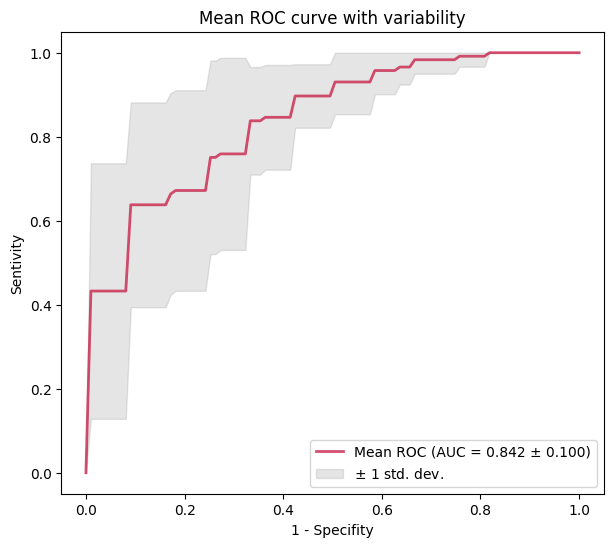

ROC curves saved successfully.


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)



fig, ax = plt.subplots(figsize=(7, 6))

tprs = []
aucs = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/inter_roc_fold.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

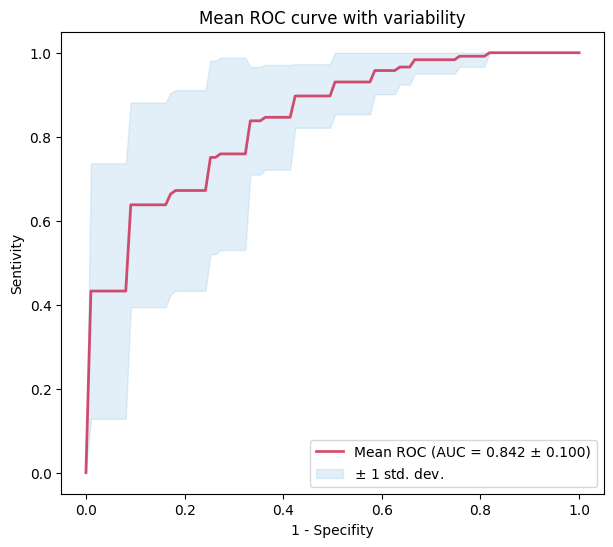

ROC curves saved successfully.


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)



fig, ax = plt.subplots(figsize=(7, 6))

tprs = []
aucs = []

for fold in cross_fold:
    label_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/label.npy')
    score_three = np.load(f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/{fold}/score.npy')

    fpr, tpr, thresholds = roc_curve(label_three, score_three)
    three_auc = roc_auc_score(label_three, score_three)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(three_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color='#C9244C',
    label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#6EB1DE",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="1 - Specifity",
    ylabel="Sentivity",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")

plt.savefig((f'/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/inter_roc_fold1.png'), dpi=300)
plt.show()
plt.close()

print("ROC curves saved successfully.")

In [25]:
import os
import glob
import pydicom
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
# 路径
base_path = "/home/uii/loraya/DDR_carat/DDR_data_235/abnormal/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义数据转换
data_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.float32)),  # 将 uint16 转换为 float32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # 使用灰度图像的均值和标准差
])

# 遍历每个以病人名命名的文件夹
for patient_folder in glob.glob(os.path.join(base_path, "*")):
    if not os.path.isdir(patient_folder):
        continue  # 如果不是文件夹，跳过
    
    print("处理病人文件夹:", patient_folder)
    
    # 在每个病人文件夹中遍历 DICOM 图像
    for img_path in glob.glob(os.path.join(patient_folder, "HUI.dcm")):
        print("处理 DICOM 图像:", img_path)
        
        # 读取 DICOM 文件
        dcm = pydicom.dcmread(img_path)
        
        # 检查 DICOM 文件是否包含像素数据
        if 'PixelData' in dcm:
            img_data = dcm.pixel_array
            
            # 应用转换
            img_data = data_transform(img_data)
            img_data = torch.unsqueeze(img_data, dim=0)
                
            # 创建模型并加载权重
            model = models.resnet18(num_classes=2).to(device)
            weights_path = "/home/uii/loraya/DDR_carat/res_18_hui_good_good/weight/7/best_val_auc.pth"
            assert os.path.exists(weights_path), "文件 '{}' 不存在.".format(weights_path)
            model.load_state_dict(torch.load(weights_path, map_location=device))

            # 图像数据移动到设备上
            img_data = img_data.to(device)

            # 模型预测
            model.eval()
            with torch.no_grad():
                output = model(img_data)
                predict = torch.softmax(output, dim=1)
                predict_cla = torch.argmax(predict, dim=1).item()

            print_res = "类别: {}   概率: {:.3}".format(class_indict[str(predict_cla)],
                                                     predict[0][predict_cla].item())
            print(print_res)

处理 DICOM 图像: /home/uii/loraya/DDR_carat/DDR_data_235/abnormal/ZHONG SHI LONG/HUI.dcm


ValueError: pic should be 2/3 dimensional. Got 5 dimensions.

In [ ]:
import glob
img_path_all = glob.glob(r"/home/uii/loraya/DDR_carat/DDR_data_235/abnormal/*")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
for i in range(0, len(img_path_all)):
    # load image
    print(img_path_all[i])
    
    img_path = img_path_all[i]
    img_path_c = img_path.split(os.sep)[-1]
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    img_cam = cv2.resize(np.array(img),[224,224],cv2.INTER_LINEAR)
#     plt.savefig('res101-BM-IMG/'+str(i)[58:]+'.png',dpi=500)
    
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)
    
    plt.imshow(img_cam)
    # read class_indict
    json_path = './class_indices-AD.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)
        
    # create model
    model = resnet34(num_classes=2).to(device)
       
    # load model weights
    weights_path = './resNet34-AD.pth'
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # prediction
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.savefig('./res34-TAD-IMG/'+img_path_c,dpi=500)
    plt.axis('off')
    plt.show()

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import os
import json
import cv2

def main():
#     model = models.mobilenet_v3_large(pretrained=True)
#     target_layers = [model.features[-1]]

    # model = models.vgg16(pretrained=True)
    # target_layers = [model.features]
    
   

    # model = models.regnet_y_800mf(pretrained=True)
    # target_layers = [model.trunk_output]

#     model = models.efficientnet_b0(pretrained=True)
#     target_layers = [model.features]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    img_path_all = glob.glob(r"/home/uii/loraya/2AD404case/data1/stru_image/val/TAD/*")
    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

   
    for i in range(0, len(img_path_all)):
        print(img_path_all[i])

        img_path = img_path_all[i]
        img_path_c = img_path.split(os.sep)[-1]
        assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
        img = Image.open(img_path).convert('RGB')
    #     plt.savefig('res101-BM-IMG/'+str(i)[58:]+'.png',dpi=500)
        plt.imshow(img)

        img = data_transform(img)
        # expand batch dimension
        img = torch.unsqueeze(img, dim=0)

        img = Image.open(img_path).convert('RGB')
        img_cam = cv2.resize(np.array(img),[224,224],cv2.INTER_LINEAR)
        
        # img = center_crop_img(img, 224)

        # [C, H, W]
        img_tensor = data_transform(img)
        img_cam = np.array(img_cam, dtype=np.uint8)
        # expand batch dimension
        # [C, H, W] -> [N, C, H, W]
        input_tensor = torch.unsqueeze(img_tensor, dim=0)
        
        model = resnet34(num_classes=2).to(device)
        model_weight_path = "./resNet34-AD.pth"
        assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
        model.load_state_dict(torch.load(model_weight_path, map_location='cpu'),strict = False)
        
        
        target_layers = [model.layer4]
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        targets = [ClassifierOutputTarget(1)]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets,eigen_smooth=True)

        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(img_cam.astype(dtype=np.float32) / 255,grayscale_cam,use_rgb=True,image_weight=0.8)
        plt.imshow(visualization)
        plt.savefig('./res34-TAD-cam/'+img_path_c,dpi=500)
        plt.axis('off')
        plt.show()


if __name__ == '__main__':
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/home/uii/loraya/DDR_carat/res_18_lung_lung_good/weight/0/label.npy'

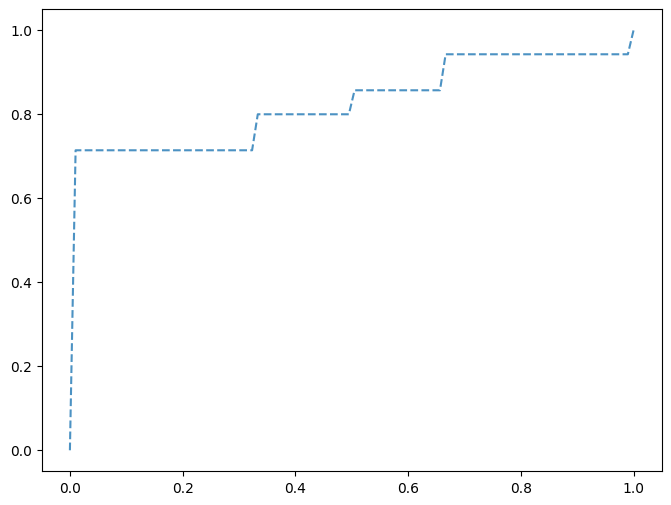

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import numpy as np

cross_fold = [0, 1, 2, 3, 4]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)
input_name = ['res_18_three', 'res_18_lung_lung_good', 'res_18_lung_good_good', 'res_18_hui_lung_lung', 'res_18_hui_hui_lung', 'res_18_hui_hui_good', 'res_18_hui_good_good', 'res_18_all_lung', 'res_18_all_hui', 'res_18_all_good']

fig, ax = plt.subplots(figsize=(8, 6))
best_auc = 0.0
best_mean_tpr = None
best_input = None
for input_ in input_name:
    tprs = []
    aucs = []
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/weight/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/weight/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_mean_tpr = mean_tpr
        best_input = input_

    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{input_} (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        linestyle="--",
        alpha=0.8,
    )

ax.plot(
    mean_fpr,
    best_mean_tpr,
    label=f"{best_input} (Best AUC = {best_auc:.2f})",
    color="red",
    lw=2,
)

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.5)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve for Different Inputs",
)
ax.legend(loc="lower right")

# 保存到指定路径
plt.savefig('/home/uii/loraya/DDR_carat/mean_roc_curve.png', dpi=300)
plt.close()

print("Mean ROC curve saved successfully.")

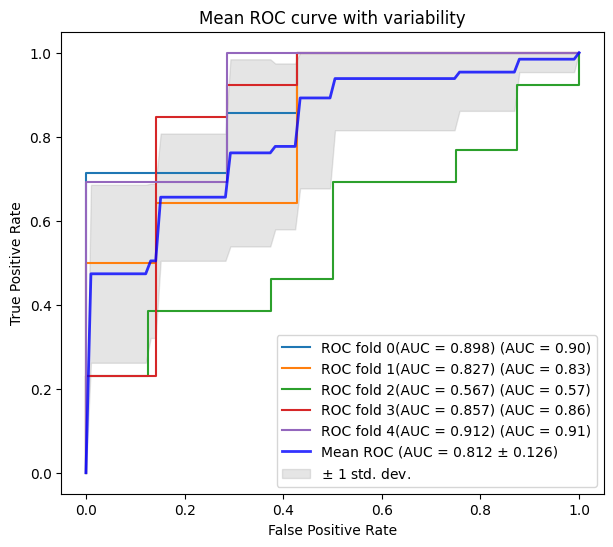

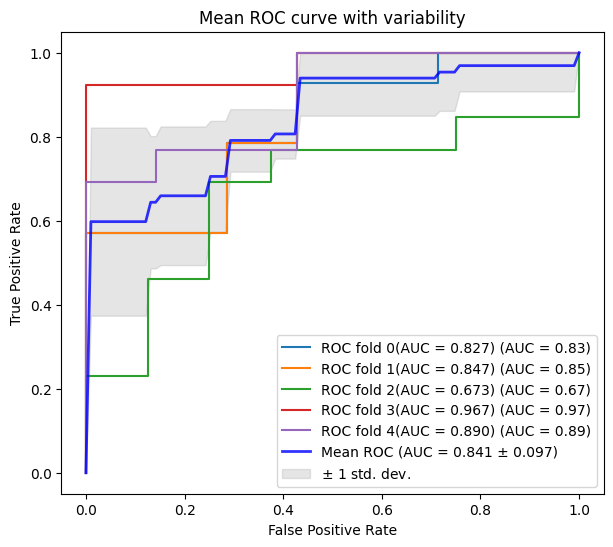

ROC curves saved successfully.


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import numpy as np

cross_fold = [0, 1, 2, 3, 4]
tprs = []
aucs = []
target_names = ["Abnormal"]
mean_fpr = np.linspace(0, 1, 100)

input_name = ['res_18_three', 'res_18_hui_good_good']

for input_ in input_name:
    fig, ax = plt.subplots(figsize=(7, 6))
    tprs = []
    aucs = []
    for fold in cross_fold:
        label_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/weight/{fold}/label.npy')
        score_three = np.load(f'/home/uii/loraya/DDR_carat/{input_}/weight/{fold}/score.npy')

        fpr, tpr, thresholds = roc_curve(label_three, score_three)
        three_auc = roc_auc_score(label_three, score_three)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(three_auc)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=three_auc)
        roc_display.plot(ax=ax, name=f"ROC fold {fold}(AUC = {three_auc:.3f})")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")

    plt.savefig((f'/home/uii/loraya/DDR_carat/{input_}/weight/inter_roc_fold.png'), dpi=300)
    plt.show()
    plt.close()

print("ROC curves saved successfully.")

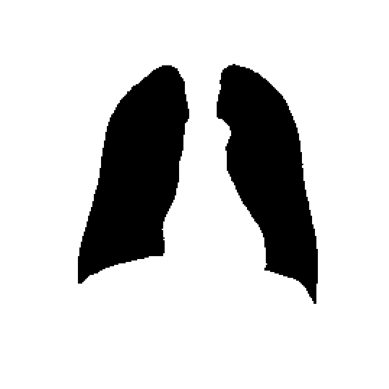

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
import cv2


mask = np.load('/home/uii/loraya/DDR SEGMENT/loraya image/YI RONG YI/mask.npy')

t = 0.6
mask[mask<t] = 0
mask[mask>=t] = 1
inverted_mask = 1 - mask
plt.axis('off')
plt.imshow(inverted_mask[0],'gray')

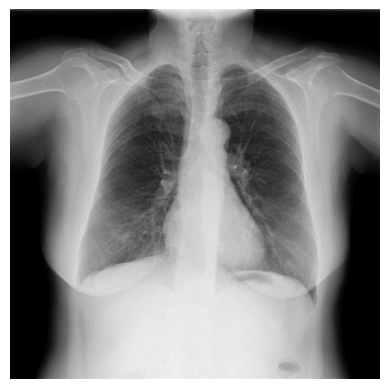

In [18]:
dcm = pydicom.dcmread('/home/uii/loraya/DDR SEGMENT/loraya image/YI RONG YI/HUI.dcm')
pixels = dcm.pixel_array
pixels = np.max(pixels)-pixels
plt.imshow(pixels[0], cmap='gray')
plt.axis('off')
plt.show()

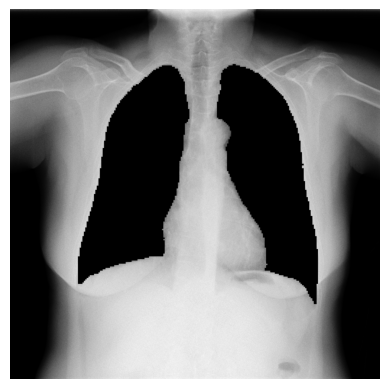

In [22]:
pixels_a = pixels[0].astype(float)
resized_mask = cv2.resize(inverted_mask[0], (pixels_a.shape[1], pixels_a.shape[0]), interpolation=cv2.INTER_NEAREST)
result = pixels_a * resized_mask


# 显示结果图像
# cv2.imshow('Result', result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imwrite('/path/to/save/image.jpg', result) #

plt.imshow(result,'gray')
plt.axis('off')
# plt.savefig('/path/to/save/image.jpg') 
plt.show()

In [36]:
pixels.shape

()

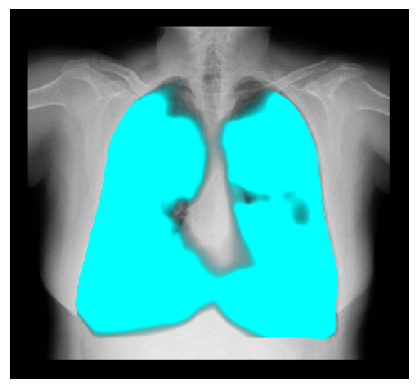

In [58]:
import cv2
import matplotlib.pyplot as plt

dcm_1 = cv2.imread('/home/uii/loraya/DDR SEGMENT/loraya image/YI RONG YI/PL.png')

dcm_show = cv2.cvtColor(dcm_1, cv2.COLOR_BGR2RGB)

plt.imshow(dcm_show)
plt.axis('off')
plt.show()

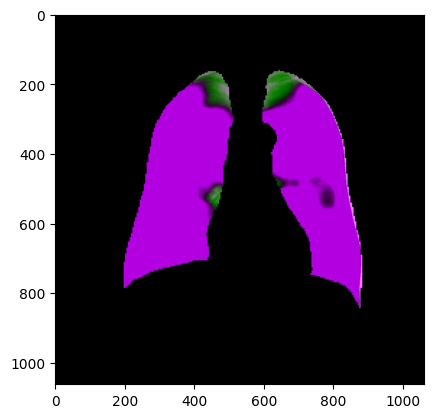

In [63]:
import numpy as np
import cv2
import pydicom as pd
import matplotlib.pyplot as plt
dcm = pd.dcmread('/home/uii/loraya/DDR SEGMENT/loraya image/YI RONG YI/PL.dcm')
img = dcm.pixel_array[0]

mask = np.load('/home/uii/loraya/DDR SEGMENT/loraya image/YI RONG YI/mask.npy')
t=0.6
mask[mask>t] = 1
mask[mask<t] = 0

mask_0 = cv2.resize(mask[0],(img.shape[1],img.shape[0]),cv2.INTER_NEAREST)

result = img * np.concatenate((mask_0[:,:,None],mask_0[:,:,None],mask_0[:,:,None]),axis=2).astype(np.uint8)

plt.imshow(result)
plt.show()